<a href="https://colab.research.google.com/github/Birkbeck/msc-projects-2023-4-chorltonm/blob/main/notebooks/models/ml_models_unseen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [36]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# Import user defined python functions. Used importlib as having stability issues with simple import and not picking up the files
spec = importlib.util.spec_from_file_location("create_model_results", "/content/drive/MyDrive/birkbeck_msc-project/python_files/create_model_results.py")
create_model_results = importlib.util.module_from_spec(spec)
spec.loader.exec_module(create_model_results)


In [38]:
# Authentication credentials and keys
# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [39]:
# Feature data for FA Cup

# Query Google Big Query
fa_cup_features_all = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_features_all_df = client.query(fa_cup_features_all).to_dataframe()
display(fa_cup_features_all_df)

test_flag = 'Unseen'


season_year  match_id                         match_name  \
0         09/10    505337                 Chelsea vs Watford   
1         14/15   1138603                 Chelsea vs Watford   
2         16/17   1345813     Chelsea vs Peterborough United   
3         20/21    201912       Manchester United vs Watford   
4         09/10    505338  Manchester United vs Leeds United   
..          ...       ...                                ...   
345       14/15   1142554  Blyth Spartans vs Birmingham City   
346       17/18    949974       Yeovil Town vs Bradford City   
347       18/19     50205                  Woking vs Watford   
348       20/21    200806         Chorley FC vs Derby County   
349       21/22   1621149  Kidderminster Harriers vs Reading   

    match_final_score  arena_stadium_capacity  home_team_league_level  \
0                 5-0                   41837                       1   
1                 3-0                   41837                       1   
2                 4-1                   41837                       1   
3                 1-0                   74879                       1   
4                 0-1                   74879                       1   
..                ...                     ...                     ...   
345               2-3                    <NA>                       6   
346               2-0                    9527                       4   
347               0-2                    6064                       6   
348               2-0                    4100                       6   
349               2-1                    6238                       6   

     home_win  home_team_round_3_position  home_team_massey  home_team_colley  \
0           1                           1                 1                 1   
1           1                           1                 1                 1   
2           1                           1                 1                 1   
3           1                           1                 1                 1   
4           0                           2                 4                 7   
..        ...                         ...               ...               ...   
345         0                          64                59                64   
346         1                          64                59                64   
347         0                          64                59                64   
348         1                          64                59                64   
349         1                          64                59                64   

     ...  match_weather_data_hours_dew  match_weather_data_hours_precip  \
0    ...                           NaN                              NaN   
1    ...                         34.70                            0.000   
2    ...                         47.00                            0.000   
3    ...                         71.20                            0.000   
4    ...                           NaN                              NaN   
..   ...                           ...                              ...   
345  ...                           NaN                              NaN   
346  ...                         37.15                            0.000   
347  ...                         41.45                            0.000   
348  ...                         32.75                            0.001   
349  ...                         40.40                            0.000   

     match_weather_data_hours_snow  match_weather_data_hours_snowdepth  \
0                              NaN                                 NaN   
1                              0.0                                0.00   
2                              0.0                                0.00   
3                              NaN                                0.00   
4                              NaN                                 NaN   
..                             ...      

In [40]:
# Function to calculate home advantage
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [41]:
# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}


In [42]:
def classifer_models_optimisation_single_split (fa_cup_features_all_df, model_name, home_advt, weighted, model_classifier, random_state):

    # Empty df for consolidating results
    all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
    all_data_act_pred_df = pd.DataFrame()

    # Define the ranking systems
    ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

    # Split data into training and test sets
    fa_cup_features_train = fa_cup_features_all_df[~fa_cup_features_all_df['season_year'].isin(['21/22', '22/23'])]
    fa_cup_features_test = fa_cup_features_all_df[fa_cup_features_all_df['season_year'].isin(['21/22', '22/23'])]

    if home_advt == 'yes':
            fa_cup_features_train, home_advantage_column = add_home_advantage(fa_cup_features_train)
            fa_cup_features_test, home_advantage_column = add_home_advantage(fa_cup_features_test)
            #numeric_features = [home_advantage_column] + numeric_features

    # Drop 'season_year, match id, match name' column from both sets so not included in model training but then retain for vlaidation set for futher analysis and comparision
    analysis_columns = ['season_year', 'match_id', 'match_name','match_final_score']

    fa_cup_features_train = fa_cup_features_train.drop(analysis_columns, axis=1)

    test_analysis_columns = fa_cup_features_test[analysis_columns].copy()
    fa_cup_features_test = fa_cup_features_test.drop(analysis_columns, axis=1)

    # Get all columns except the target and ranking columns
    target_variable = 'target_variable'
    base_features = [col for col in fa_cup_features_train.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

    # Identify numeric and categorical columns
    numeric_features = fa_cup_features_train[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = fa_cup_features_train[base_features].select_dtypes(include=['object']).columns.tolist()

    # Define preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    ranking_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])

    for ranking in ranking_systems:
        model_name_ranking = f"{model_name} {ranking}"
        print(model_name_ranking)

        # Initialize lists to store results for the model
        train_accuracies = []
        train_recalls = []
        test_accuracies = []
        test_recalls = []
        all_y_train_true = []
        all_y_train_pred = []
        all_y_train_pred_proba = []  # Store probabilities for ROC
        all_y_test_true = []
        all_y_test_pred = []
        all_y_test_pred_proba = []  # Store probabilities for ROC

        # Fetch parameter grid from BigQuery for model name ranking
        query = """
        SELECT param_grid FROM analysis_layer.view_ml_models_best_recall_param_grid
        WHERE model_name_ranking = @model_name_ranking
        """

        # Set up the query configuration with the parameter
        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter("model_name_ranking", "STRING", model_name_ranking)
            ]
        )

        # Execute the query
        query_job = client.query(query, job_config=job_config)
        results = query_job.result()

        # Process the results and remove 'Classifier__' prefix
        param_grid_raw = eval(next(iter(results)).param_grid)
        param_grid = {k.replace('classifier__', ''): v for k, v in param_grid_raw.items()}

        # Update the model_classifier with the fetched parameters
        model_classifier.set_params(**param_grid)

        print("Updated model parameters:")

        for param, value in model_classifier.get_params().items():
            print(f"  {param}: {value}")

        if  ranking == 'no_ranking':
            features = base_features
        else:
            features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']

        # Create X_train and y_train
        X_train = fa_cup_features_train[features]
        y_train = fa_cup_features_train[target_variable]

        # Create X_val and y_val
        X_test = fa_cup_features_test[features]
        y_test = fa_cup_features_test[target_variable]

        # Drop home win and league level feature so not used in modelling as impact predictability be providing the winner
        columns_to_drop = ['home_win', 'home_team_league_level', 'away_team_league_level']
        X_train = X_train.drop(columns_to_drop, axis=1)
        X_test = X_test.drop(columns_to_drop, axis=1)
        numeric_features = [feat for feat in numeric_features if feat not in columns_to_drop]
        print(f'numeric features {numeric_features}')

        # Create preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        if  ranking != 'no_ranking':
            preprocessor.transformers.append(('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}']))

        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Calculate train metrics

        y_train_pred = pipeline.predict(X_train).astype(int)
        y_train_pred_proba = pipeline.predict_proba(X_train)[:, 1]

        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)

        train_accuracies.append(train_accuracy)
        train_recalls.append(train_recall)

        # Calculate test metrics
        y_test_pred = pipeline.predict(X_test).astype(int)
        y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)

        test_accuracies.append(test_accuracy)
        test_recalls.append(test_recall)

        # Store true and predicted testues for later analysis
        all_y_train_true.extend(y_train)
        all_y_train_pred.extend(y_train_pred)
        all_y_train_pred_proba.extend(y_train_pred_proba)
        all_y_test_true.extend(y_test)
        all_y_test_pred.extend(y_test_pred)
        all_y_test_pred_proba.extend(y_test_pred_proba)

        print(f"{model_name_ranking} Train Accuracy: {train_accuracy:.3f}, test Accuracy: {test_accuracy:.3f}")
        print(f"{model_name_ranking} Train Recall: {train_recall:.3f}, test Recall: {test_recall:.3f}")

        results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)
        results_df = results_df.reset_index()
        results_df['metric_id'] = results_df.index + 1
        results_df = results_df[['metric_id', 'metric', model_name_ranking]]
        results_df = results_df[~results_df['metric'].str.startswith('Cross')]

        all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')



        # Create a DataFrame with features, actual target, and predicted target
        data_act_pred_df = pd.DataFrame({
            'ml_name_ranking': model_name_ranking,
            'Actual': y_test,
            'Predicted': y_test_pred
        })

        # Ensure X_test has the same index as y_test
        X_test_aligned = X_test.loc[y_test.index]

        # Align test_analysis_columns with y_test index
        test_analysis_aligned = test_analysis_columns.loc[y_test.index]

        # Concatenate the DataFrames
        data_act_pred_df = pd.concat([
            data_act_pred_df,
            X_test_aligned,
            test_analysis_aligned[analysis_columns]
        ], axis=1).reset_index(drop=True)

        all_data_act_pred_df = pd.concat([all_data_act_pred_df, data_act_pred_df], axis=0).reset_index(drop=True)

    return all_results_df, all_data_act_pred_df



Standard LogisticRegression no_ranking
Updated model parameters:
  C: 1000.0
  class_weight: None
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: auto
  n_jobs: None
  penalty: l1
  random_state: None
  solver: liblinear
  tol: 0.0001
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_c

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Standard LogisticRegression no_ranking  \
0                                   0.757   
1                                   0.000   
2                                   0.556   
3                                   0.000   
4                                   0.232   
5                                   0.000   
6                                   0.125   
7                                   0.000   
8                                   0.486   
9                                   1.454   
10                                  0.556   
11                                 23.000   
12                                  6.000   
13                                 14.000   
14                                  2.000   
15                                  0.622   
16                                  0.793   
17                                  0.697   
18                                  0.250   
19                                  0.125   
20                                  0.167   
21                                  0.436   
22                                  0.459   
23                                  0.432   
24                                  0.489   
25                                  0.556   
26                                  0.508   
27                                  0.459   

   Standard LogisticRegression round_3_position  \
0                                         0.751   
1                                         0.000   
2                                         0.578   
3                                         0.000   
4                                         0.232   
5                                         0.000   
6                                         0.188   
7                                         0.000   
8                                         0.489   
9                                         0.850   
10                                        0.578   
11                                       23.000   
12                                        6.000   
13                                       13.000   
14                                        3.000   
15                                        0.639   
16                              

ml_name_ranking  Actual  Predicted  \
0               Standard LogisticRegression no_ranking       0          0   
1               Standard LogisticRegression no_ranking       0          0   
2               Standard LogisticRegression no_ranking       0          0   
3               Standard LogisticRegression no_ranking       0          0   
4               Standard LogisticRegression no_ranking       0          0   
..                                                 ...     ...        ...   
355  Standard LogisticRegression local_kemeny_optim...       0          0   
356  Standard LogisticRegression local_kemeny_optim...       0          0   
357  Standard LogisticRegression local_kemeny_optim...       1          1   
358  Standard LogisticRegression local_kemeny_optim...       0          0   
359  Standard LogisticRegression local_kemeny_optim...       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

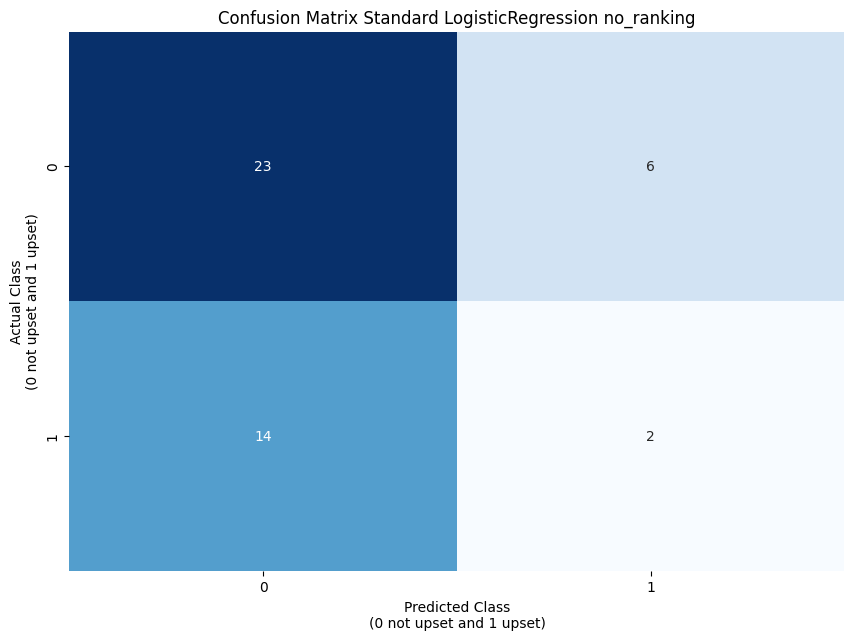

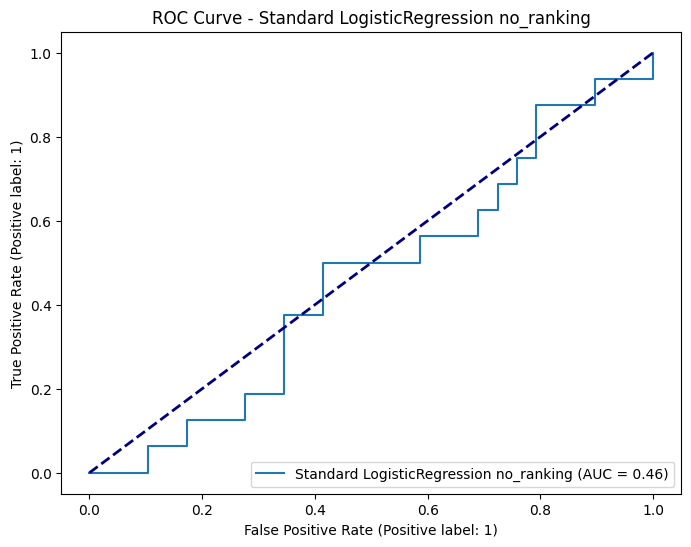

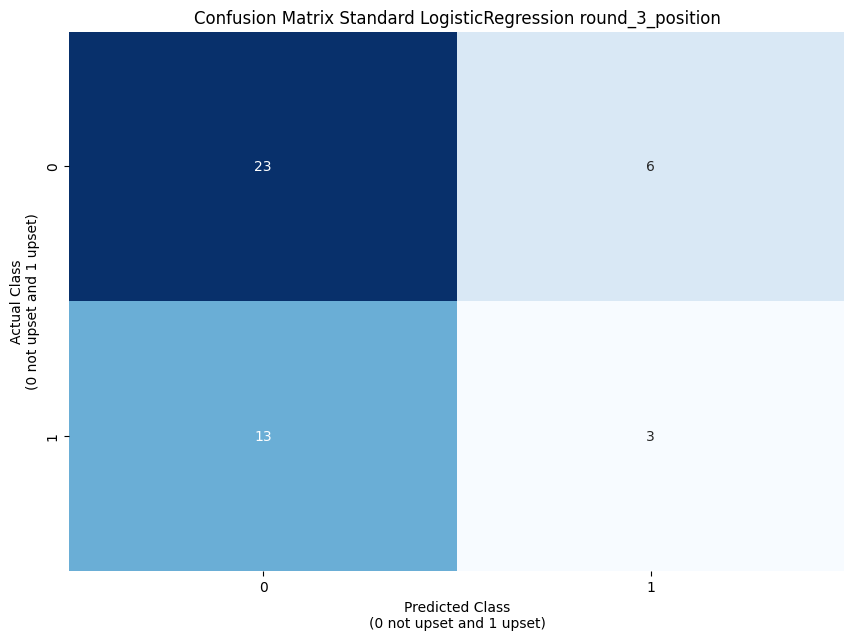

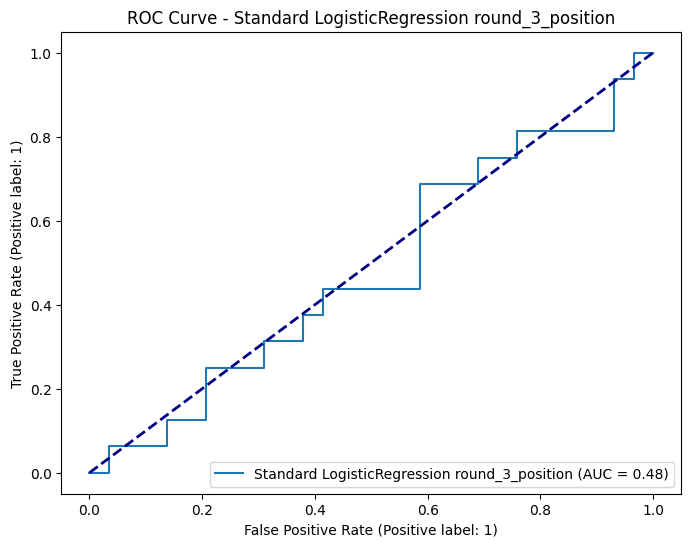

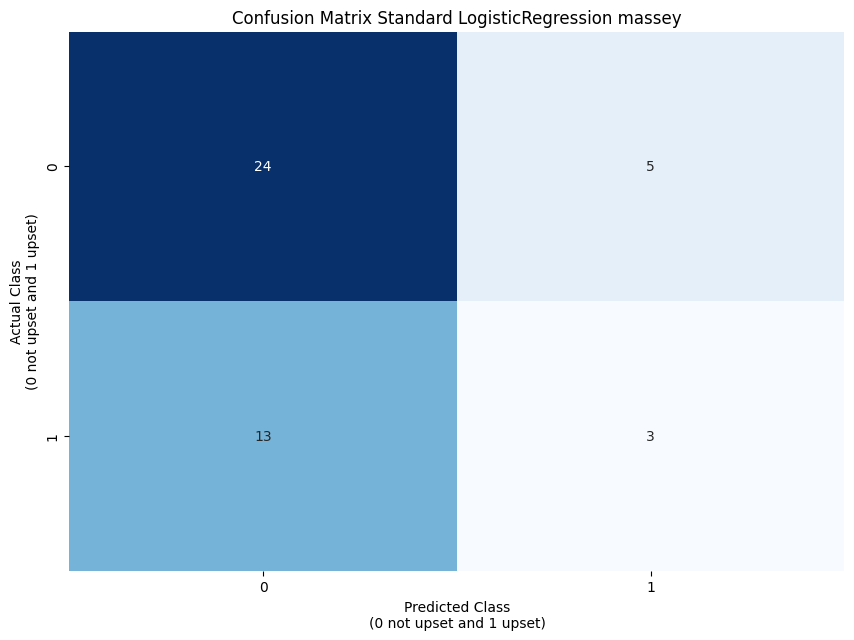

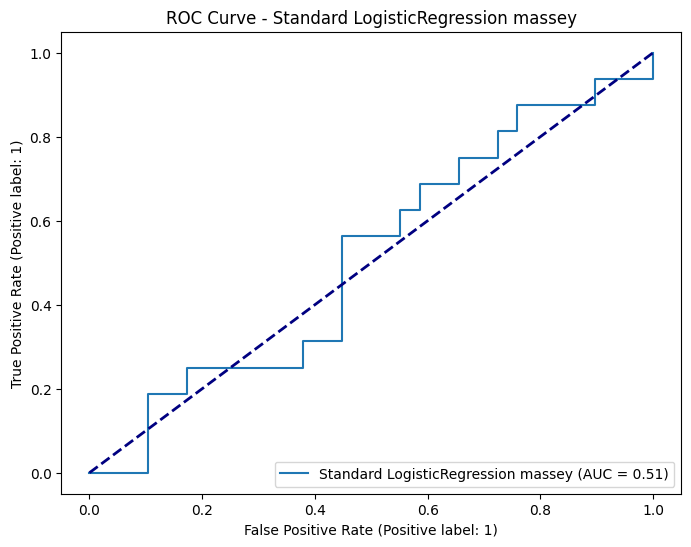

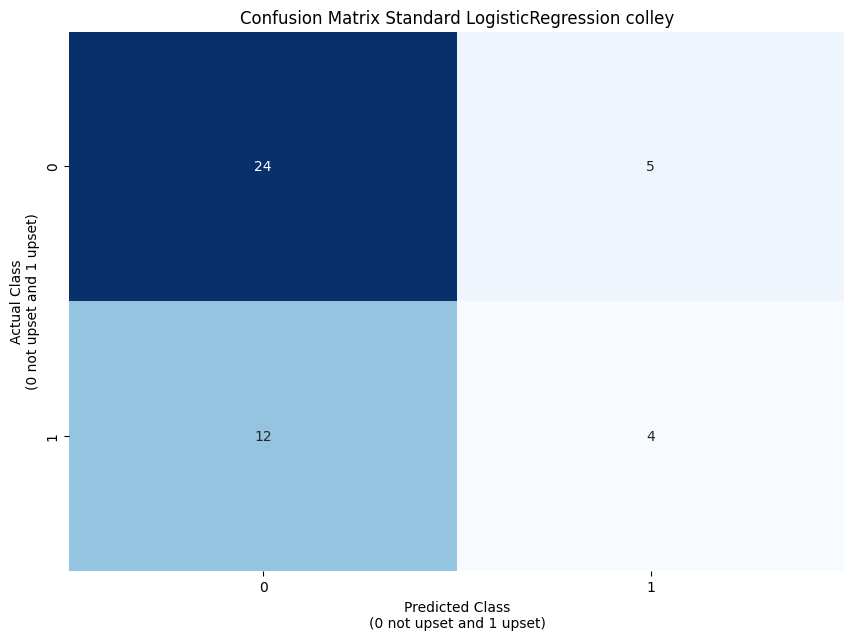

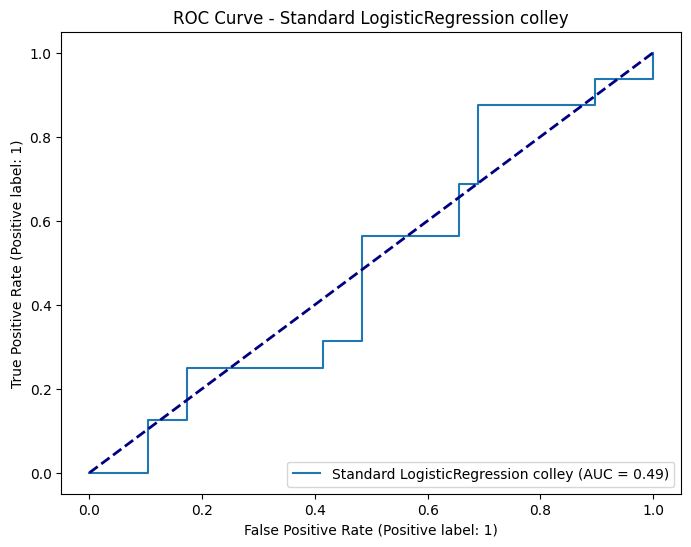

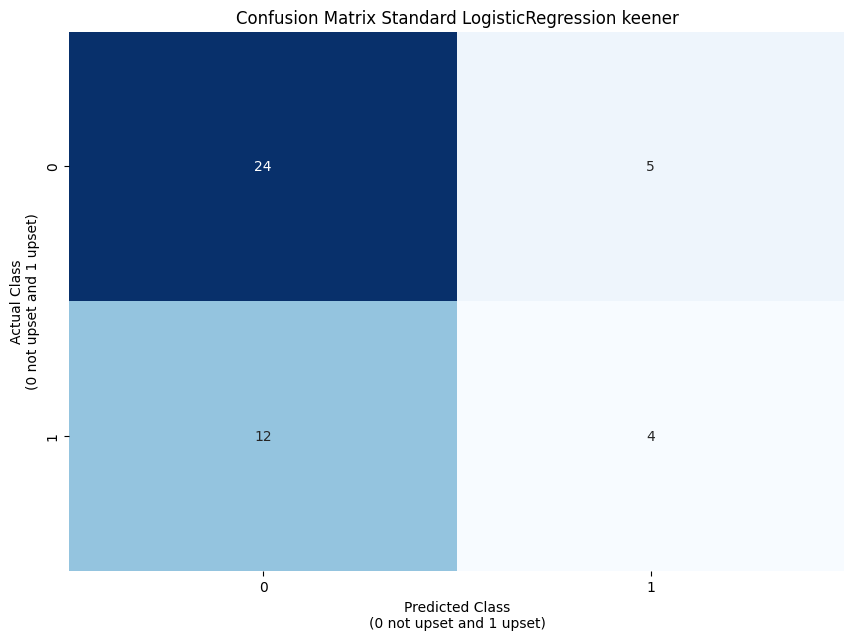

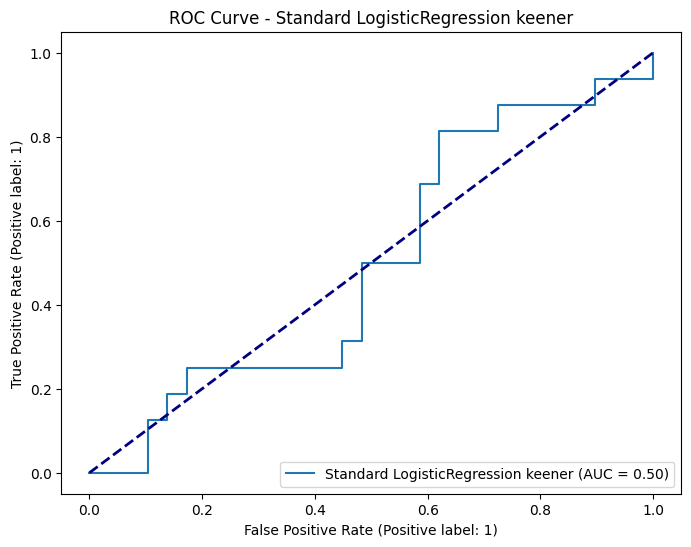

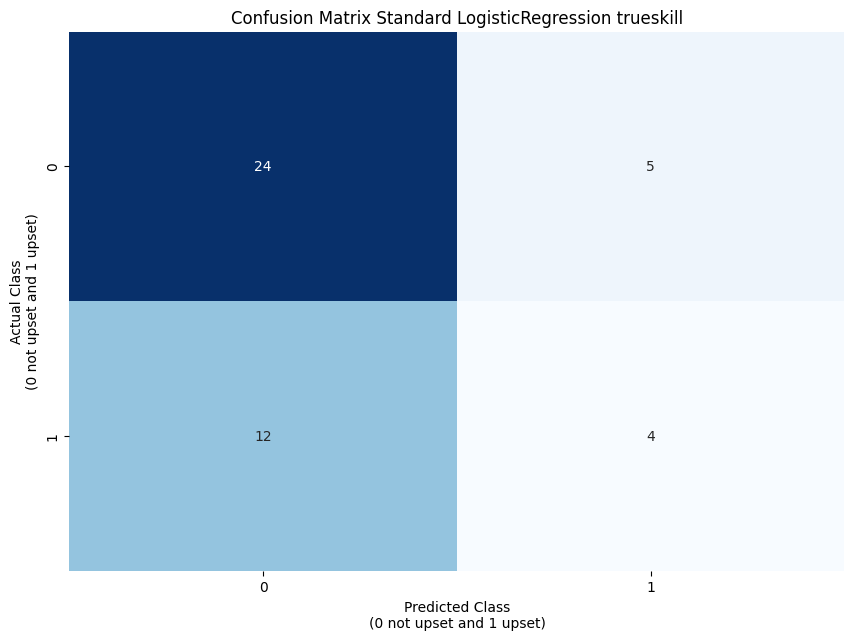

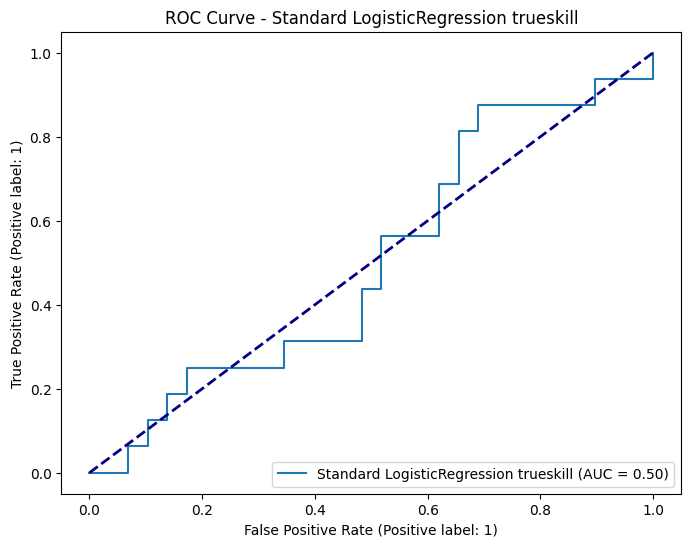

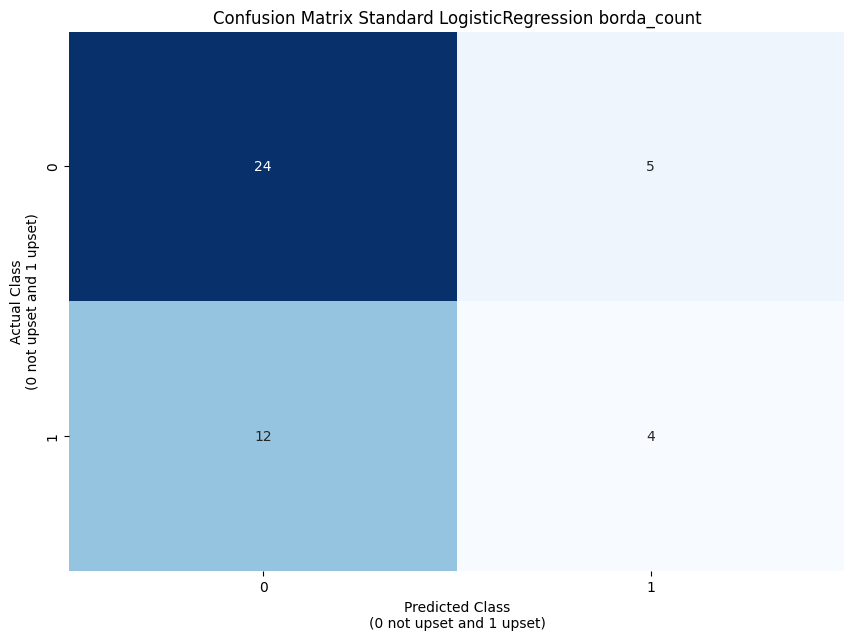

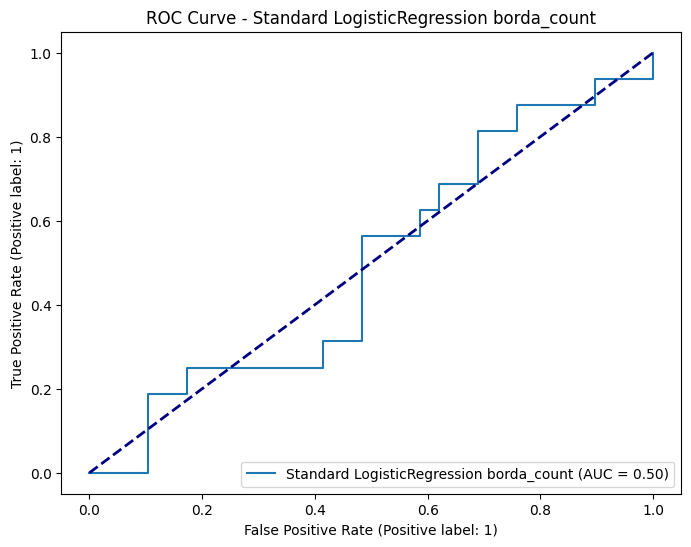

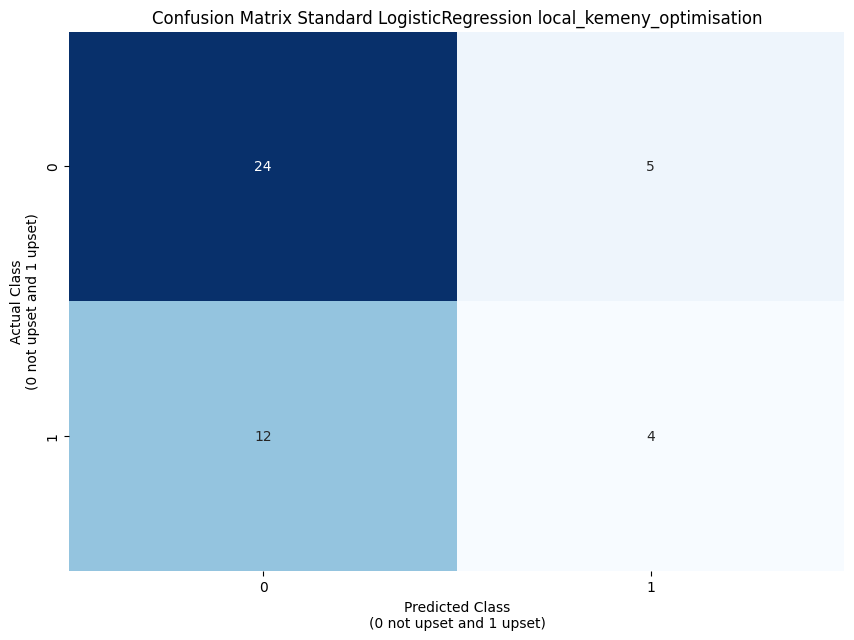

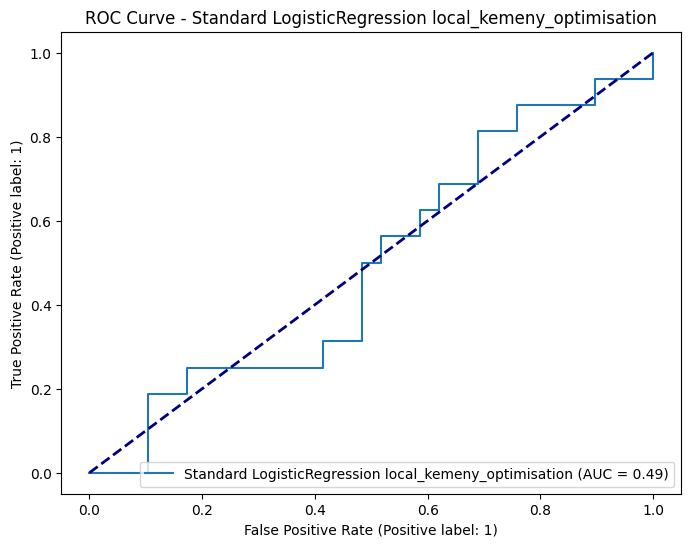

In [43]:
# Standard, no weights
model_name = "Standard LogisticRegression"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_slr = all_results_df
display(all_results_df_slr)

all_data_act_pred_df_slr = all_data_act_pred_df
display(all_data_act_pred_df)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results_unseen.xlsx")
all_data_act_pred_df_slr.to_excel("all_data_act_pred_slr_unseen.xlsx")



Standard LogisticRegression with home advantage no_ranking
Updated model parameters:
  C: 100.0
  class_weight: None
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: auto
  n_jobs: None
  penalty: l1
  random_state: None
  solver: liblinear
  tol: 0.0001
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_w

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Standard LogisticRegression with home advantage no_ranking  \
0                                               0.761           
1                                               0.000           
2                                               0.556           
3                                               0.000           
4                                               0.232           
5                                               0.000           
6                                               0.125           
7                                               0.000           
8                                               0.485           
9                                               1.243           
10                                              0.556           
11                                             23.000           
12                                              6.000           
13                                             14.000           
14                                              2.000           
15                                              0.622           
16                                              0.793           
17                                              0.697           
18                                              0.250           
19                                              0.125           
20                                              0.167           
21                                              0.436           
22                                              0.459           
23                                              0.432           
24                                              0.489           
25                                              0.556           
26                                              0.508           
27                                              0.478           

   Standard LogisticRegression with home advantage round_3_position  \
0                                               0.764                 
1                                               0.000                 
2                                               0.556                 
3                                  

ml_name_ranking  Actual  Predicted  \
0    Standard LogisticRegression with home advantag...       0          0   
1    Standard LogisticRegression with home advantag...       0          0   
2    Standard LogisticRegression with home advantag...       0          0   
3    Standard LogisticRegression with home advantag...       0          0   
4    Standard LogisticRegression with home advantag...       0          0   
..                                                 ...     ...        ...   
355  Standard LogisticRegression with home advantag...       0          0   
356  Standard LogisticRegression with home advantag...       0          0   
357  Standard LogisticRegression with home advantag...       1          1   
358  Standard LogisticRegression with home advantag...       0          0   
359  Standard LogisticRegression with home advantag...       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

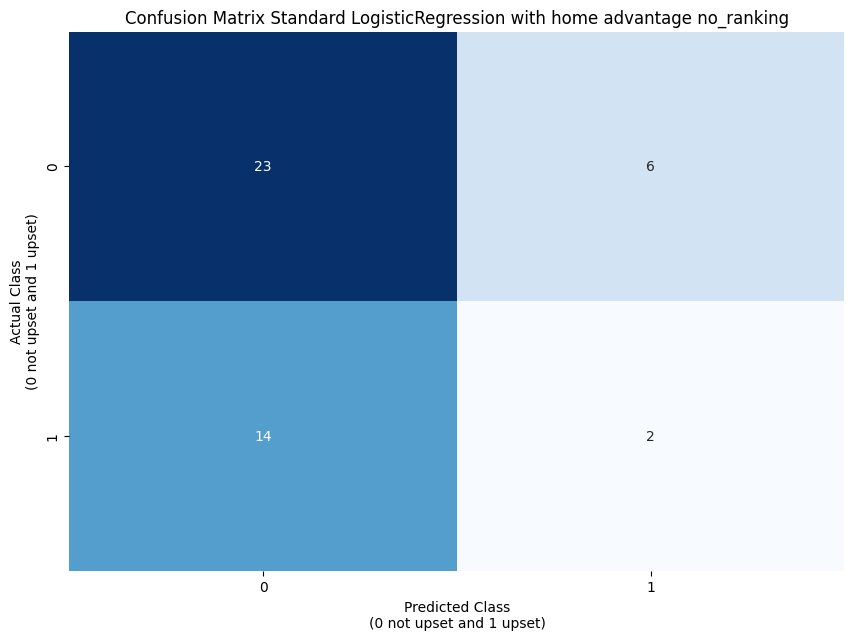

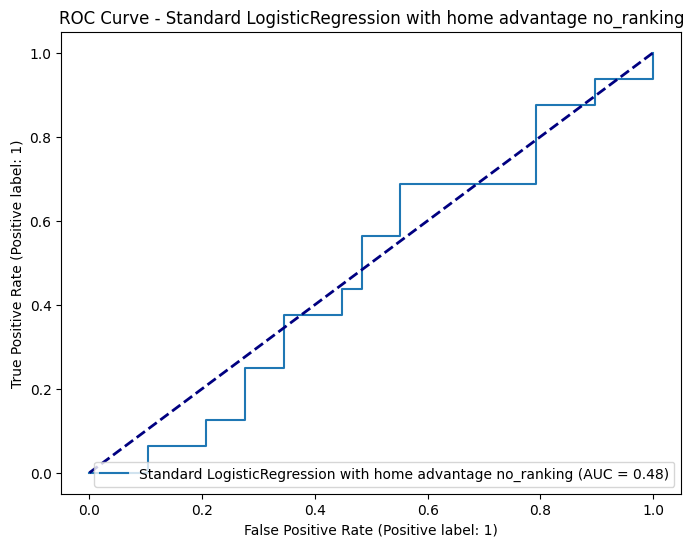

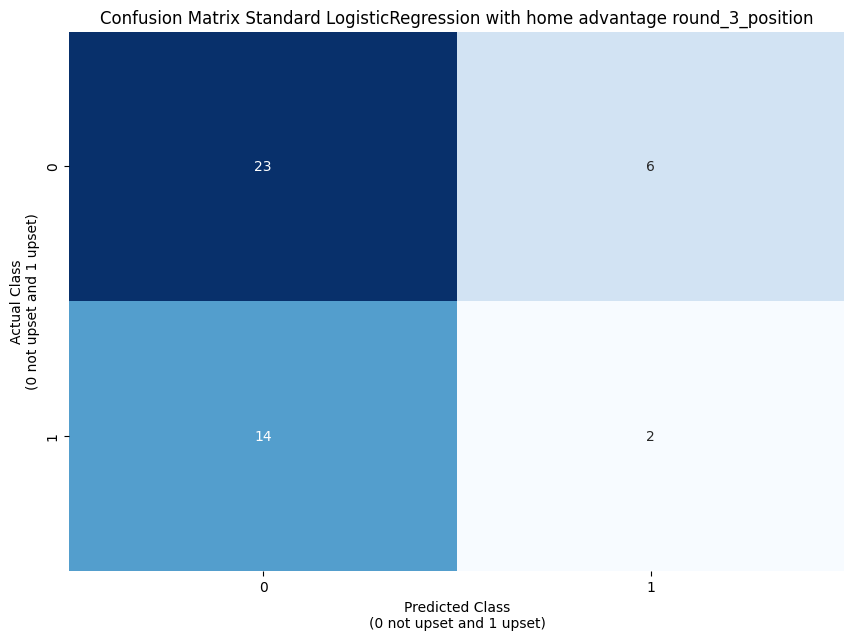

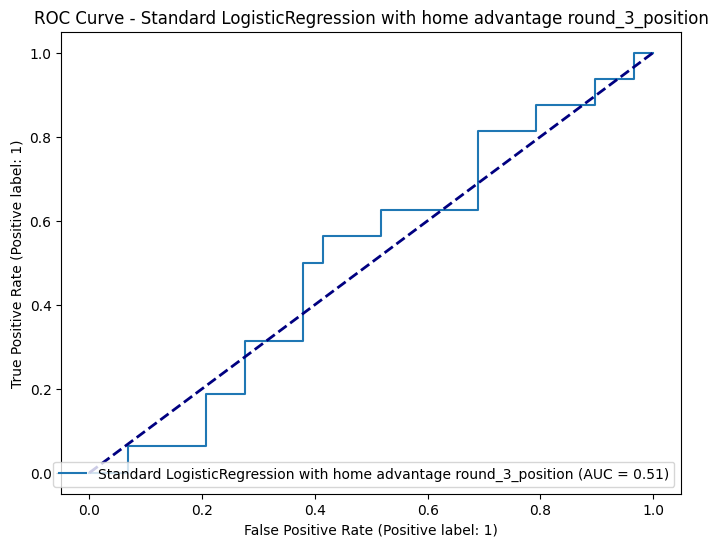

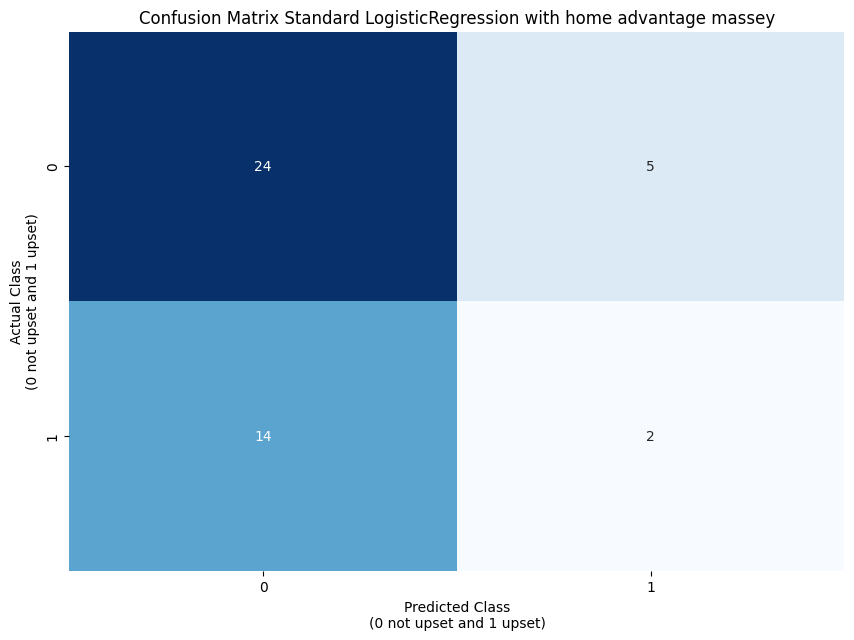

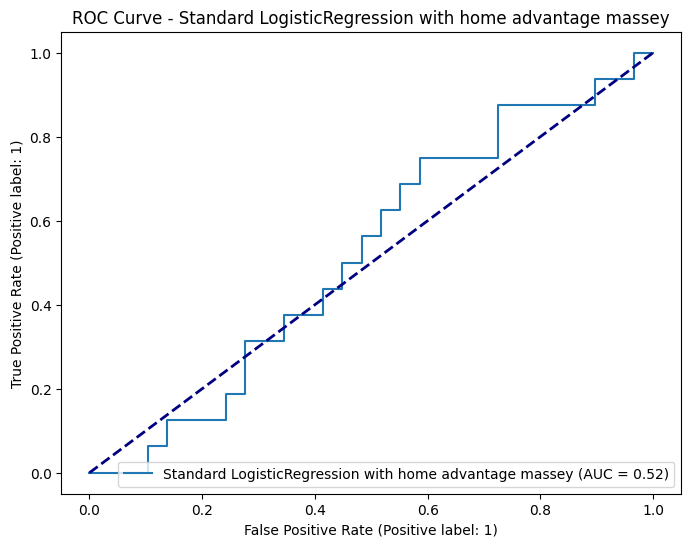

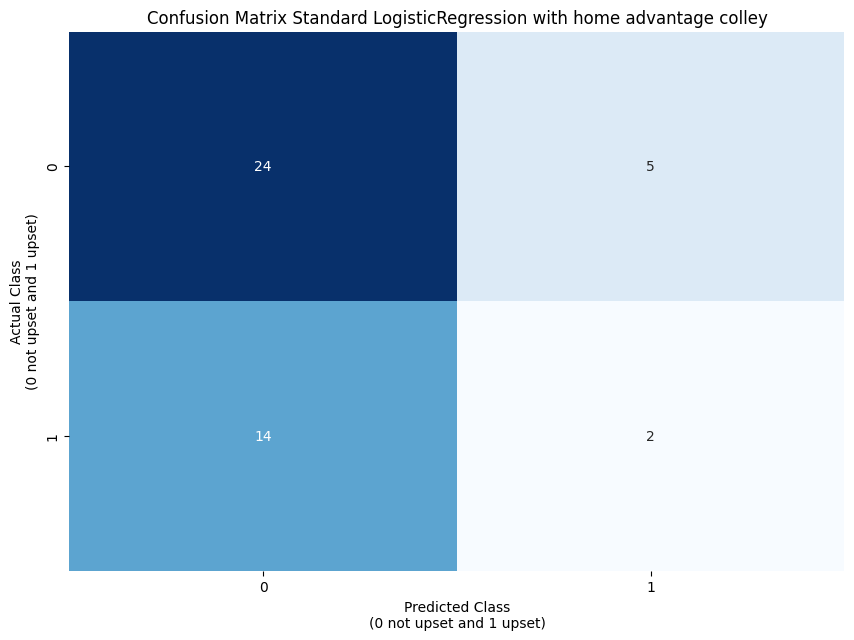

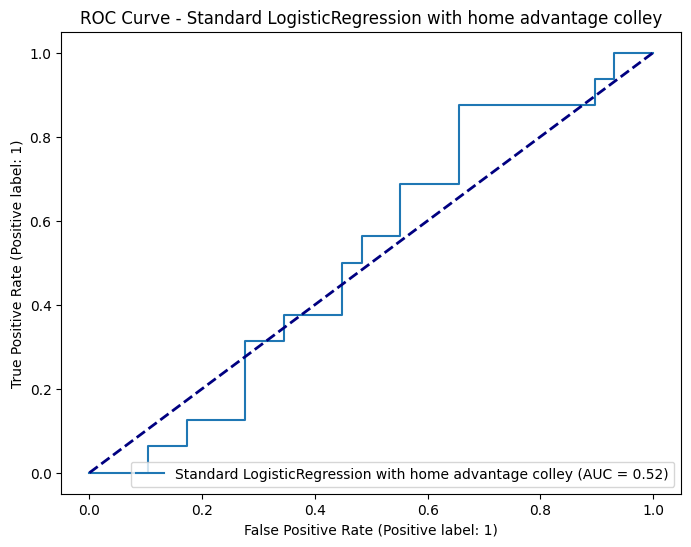

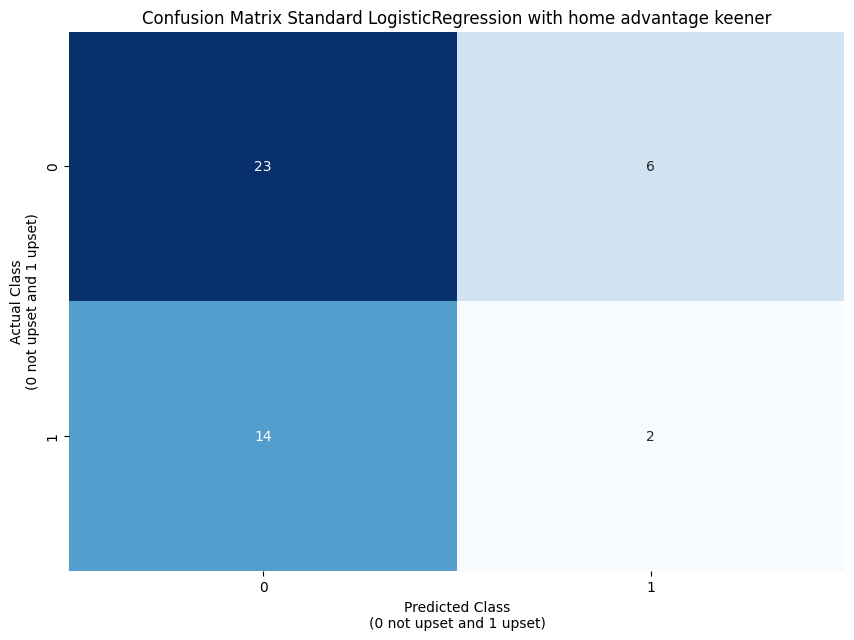

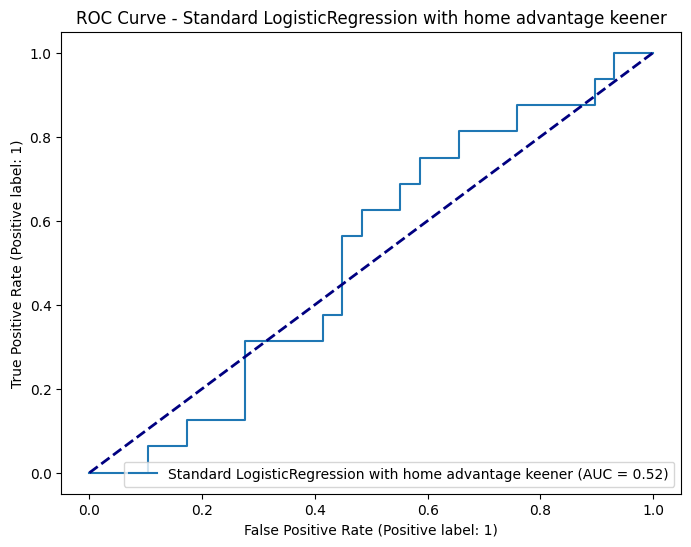

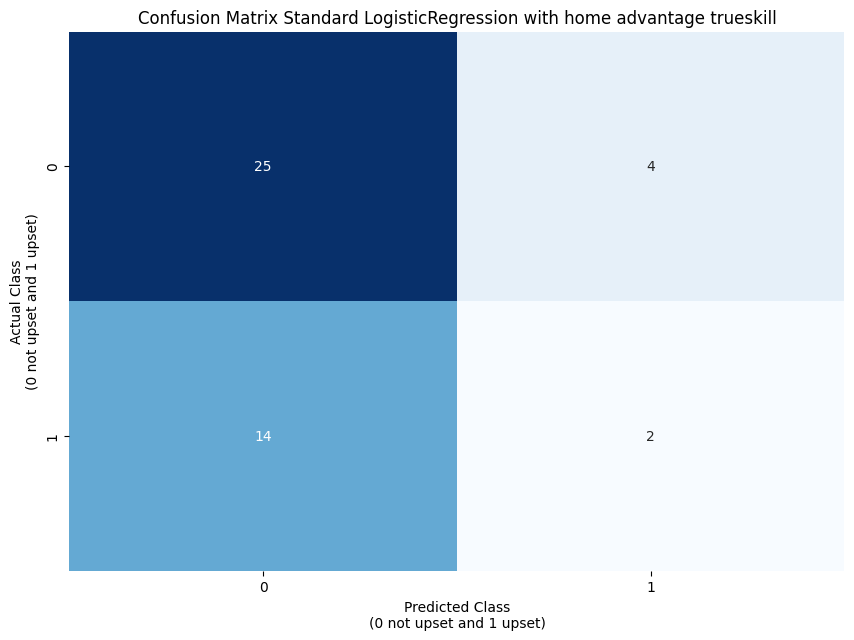

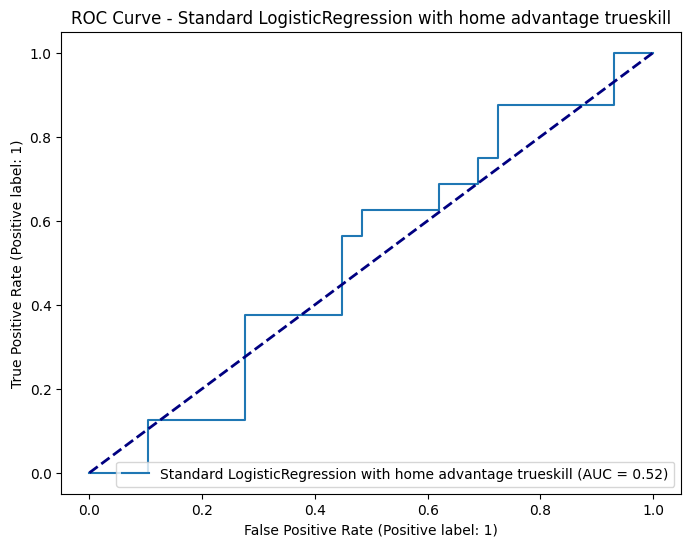

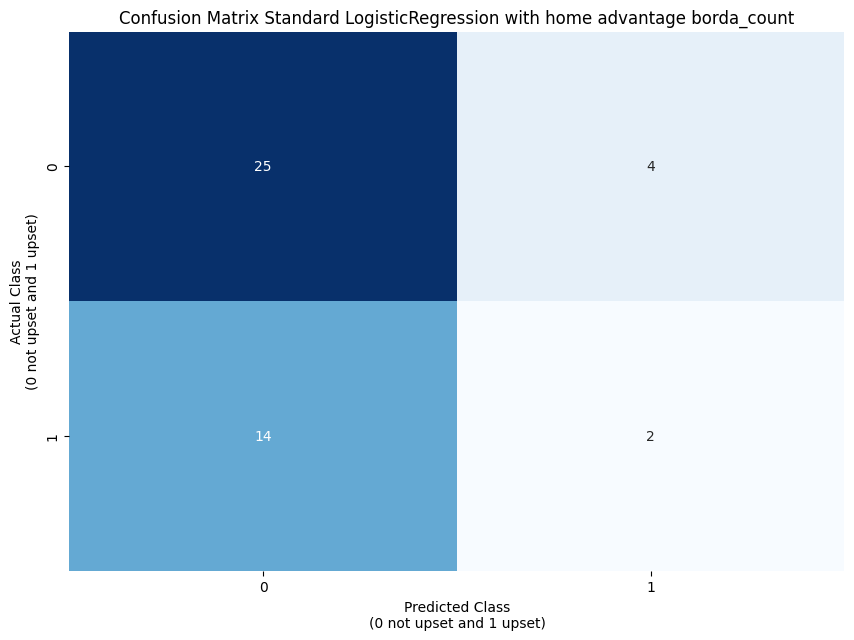

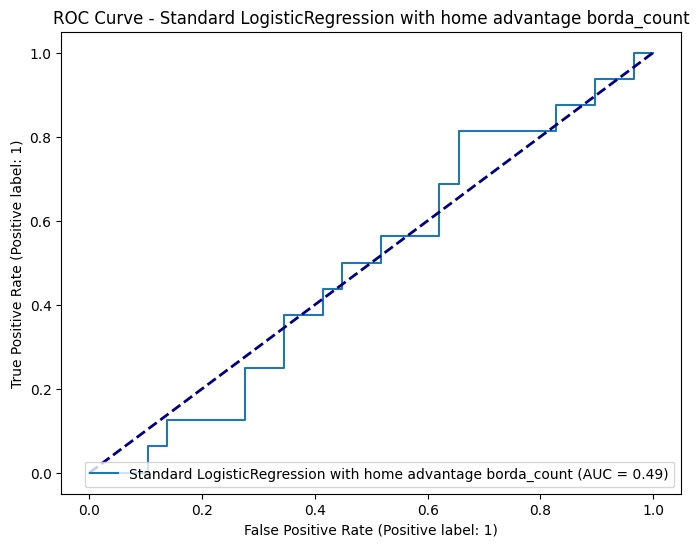

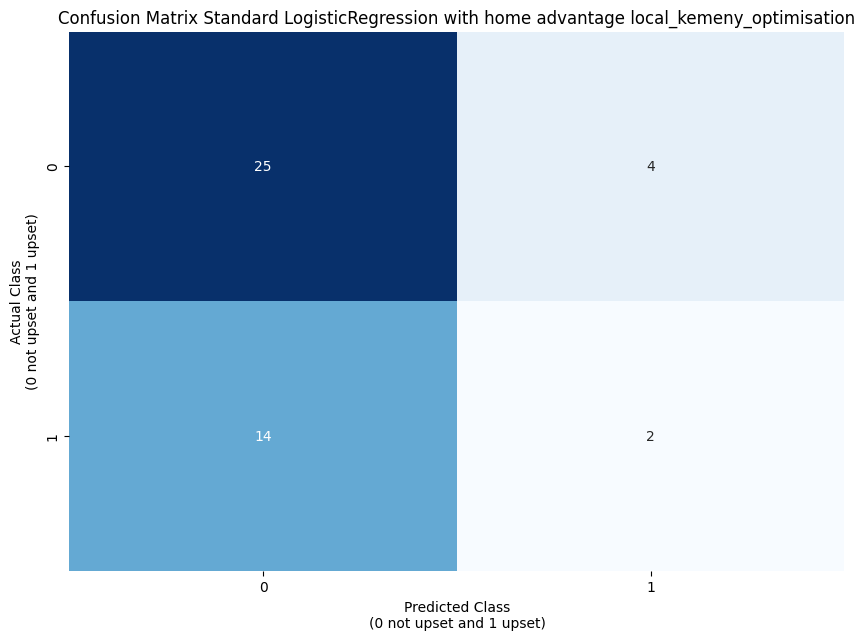

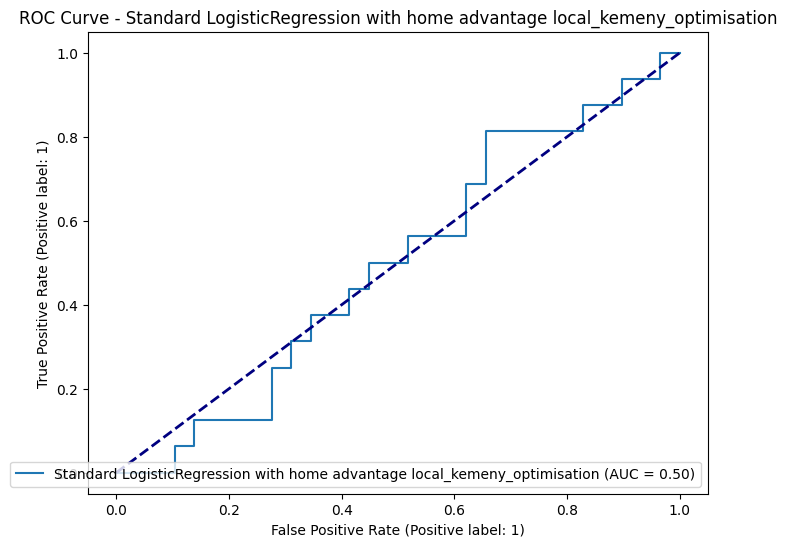

In [44]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)


all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_slrh = all_results_df
display(all_results_df_slrh)

all_data_act_pred_df_slrh = all_data_act_pred_df
display(all_data_act_pred_df_slrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slrh.to_excel("all_slrh_results_unseen.xlsx")
all_data_act_pred_df_slrh.to_excel("fold_results_slrh_unseen.xlsx")


Weighted LogisticRegression no_ranking
Updated model parameters:
  C: 1.0
  class_weight: {0: 50, 1: 50}
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: auto
  n_jobs: None
  penalty: l1
  random_state: None
  solver: liblinear
  tol: 0.0001
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Weighted LogisticRegression no_ranking  \
0                                   0.757   
1                                   0.000   
2                                   0.556   
3                                   0.000   
4                                   0.232   
5                                   0.000   
6                                   0.125   
7                                   0.000   
8                                   0.486   
9                                   1.223   
10                                  0.556   
11                                 23.000   
12                                  6.000   
13                                 14.000   
14                                  2.000   
15                                  0.622   
16                                  0.793   
17                                  0.697   
18                                  0.250   
19                                  0.125   
20                                  0.167   
21                                  0.436   
22                                  0.459   
23                                  0.432   
24                                  0.489   
25                                  0.556   
26                                  0.508   
27                                  0.472   

   Weighted LogisticRegression round_3_position  \
0                                         0.761   
1                                         0.000   
2                                         0.578   
3                                         0.000   
4                                         0.232   
5                                         0.000   
6                                         0.312   
7                                         0.000   
8                                         0.490   
9                                         0.812   
10                                        0.578   
11                                       21.000   
12                                        8.000   
13                                       11.000   
14                                        5.000   
15                                        0.656   
16                              

ml_name_ranking  Actual  Predicted  \
0               Weighted LogisticRegression no_ranking       0          0   
1               Weighted LogisticRegression no_ranking       0          0   
2               Weighted LogisticRegression no_ranking       0          0   
3               Weighted LogisticRegression no_ranking       0          0   
4               Weighted LogisticRegression no_ranking       0          0   
..                                                 ...     ...        ...   
355  Weighted LogisticRegression local_kemeny_optim...       0          0   
356  Weighted LogisticRegression local_kemeny_optim...       0          0   
357  Weighted LogisticRegression local_kemeny_optim...       1          1   
358  Weighted LogisticRegression local_kemeny_optim...       0          0   
359  Weighted LogisticRegression local_kemeny_optim...       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

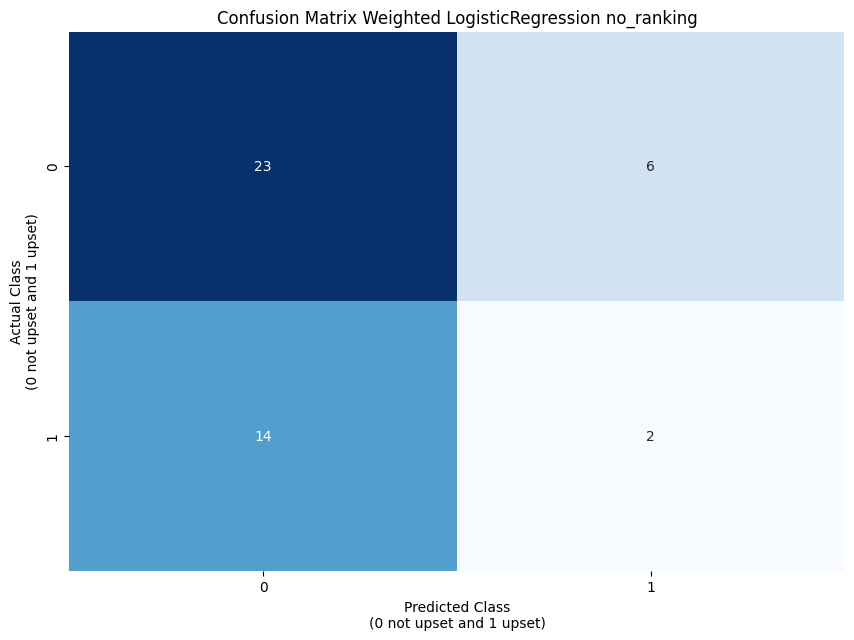

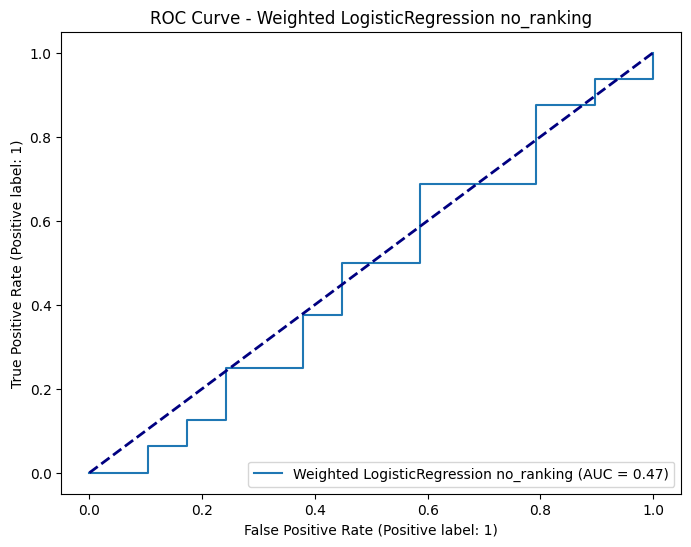

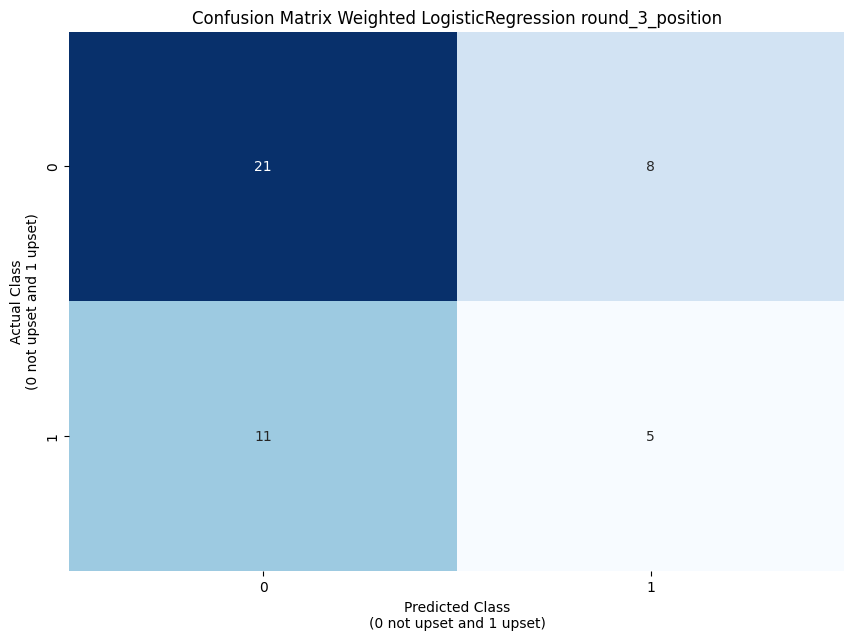

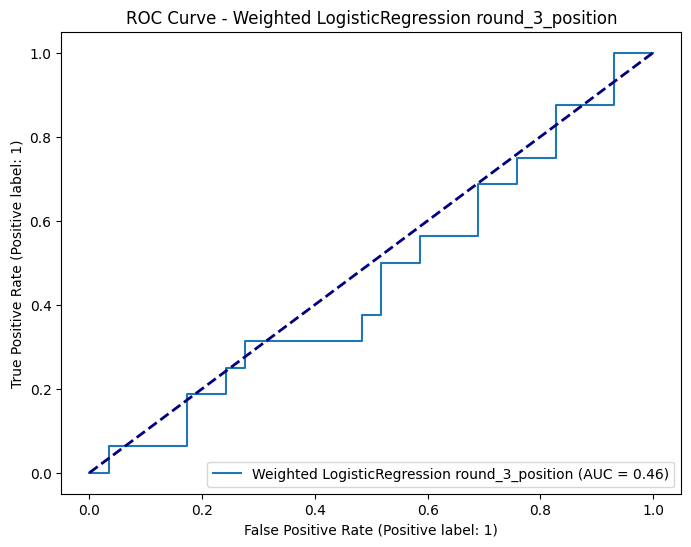

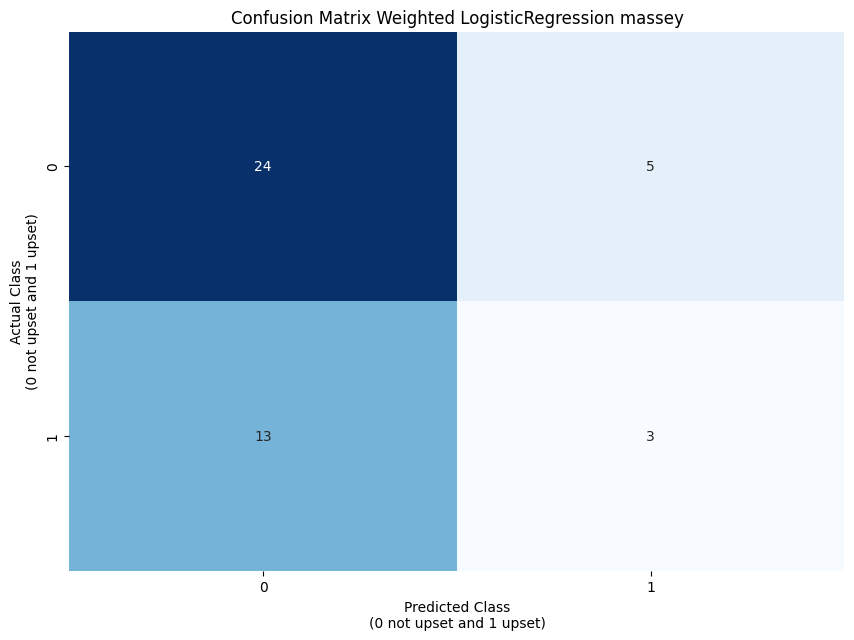

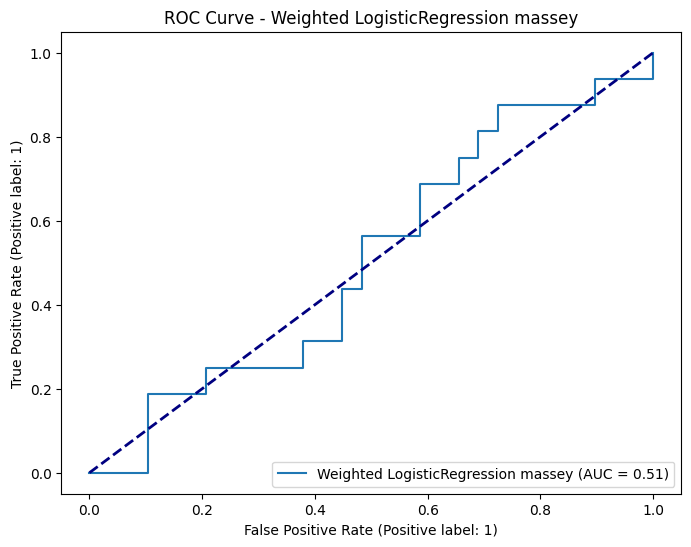

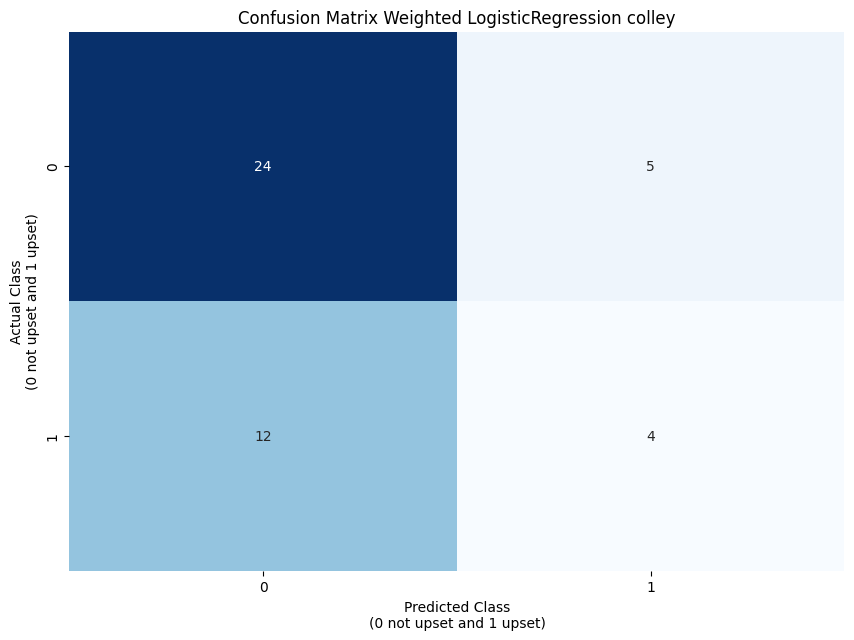

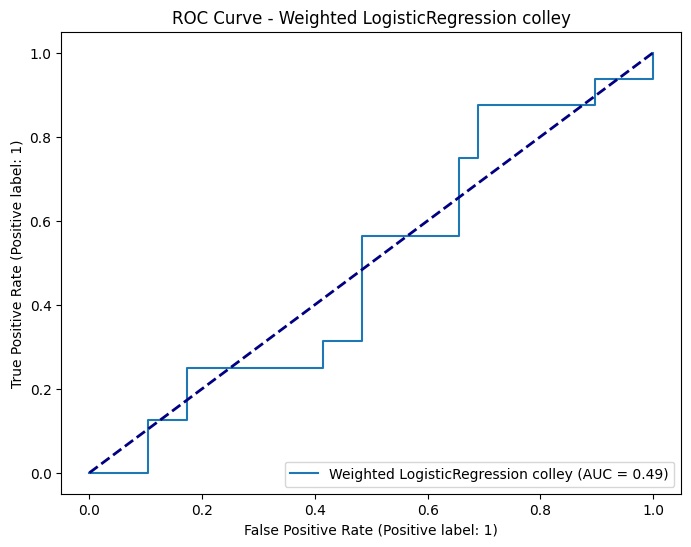

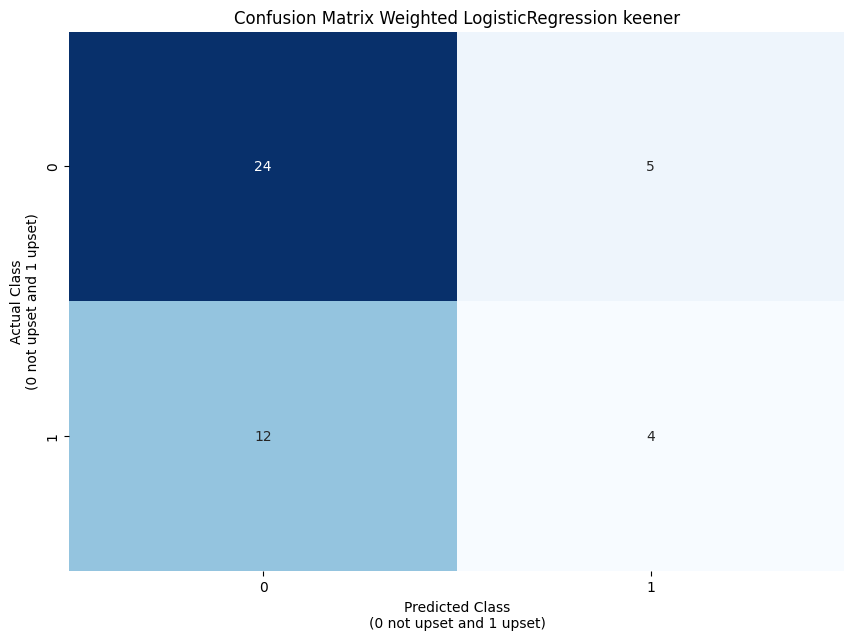

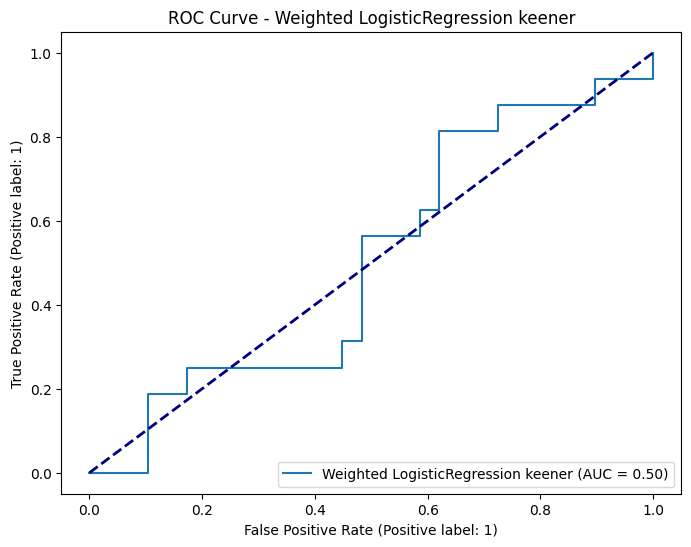

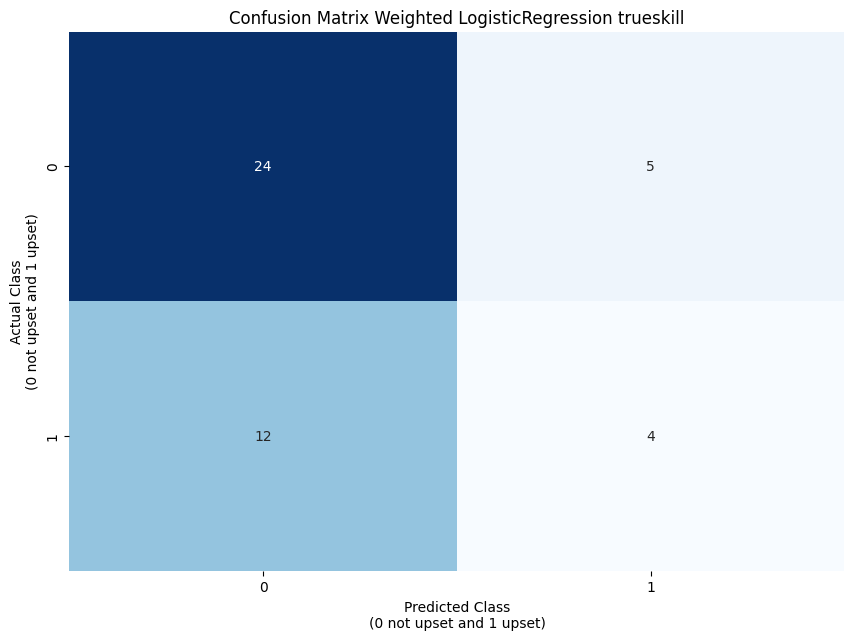

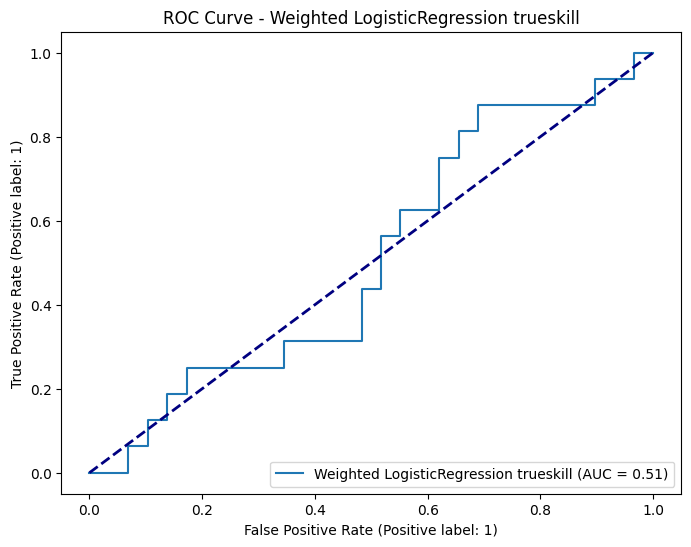

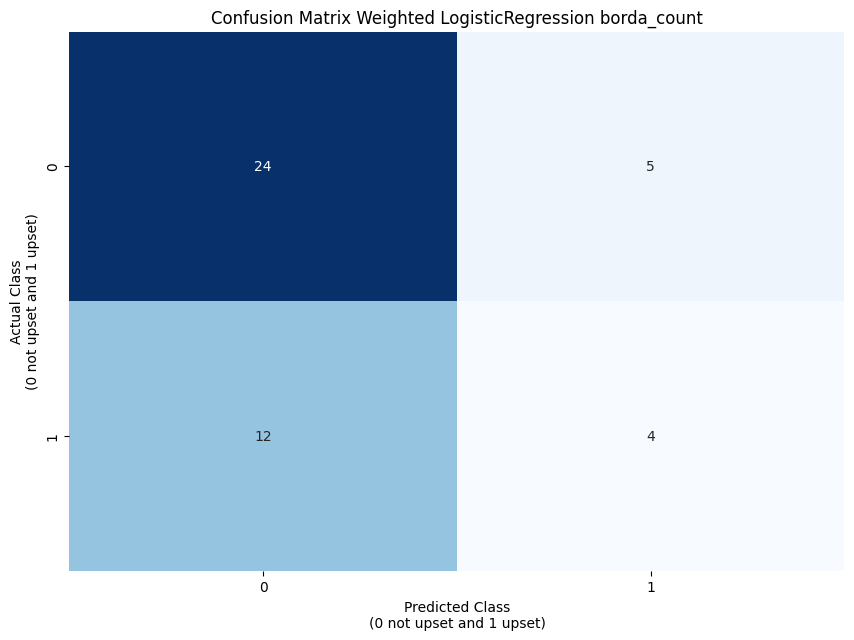

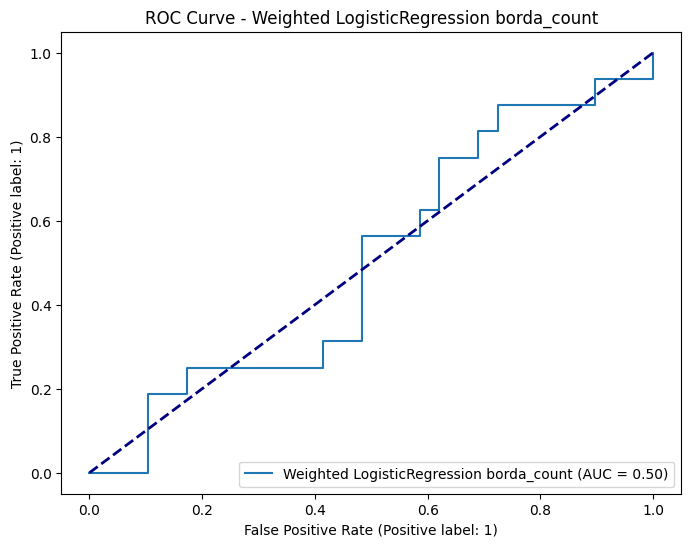

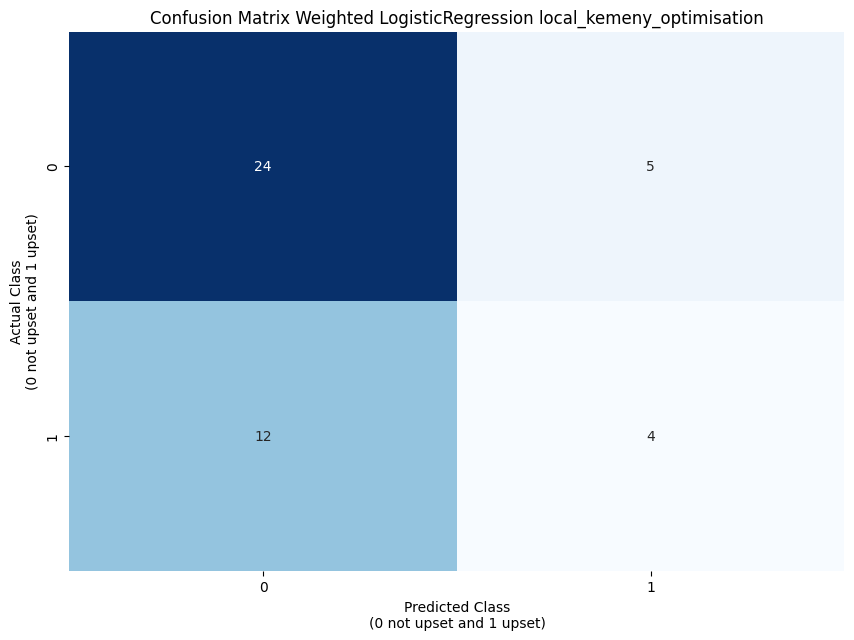

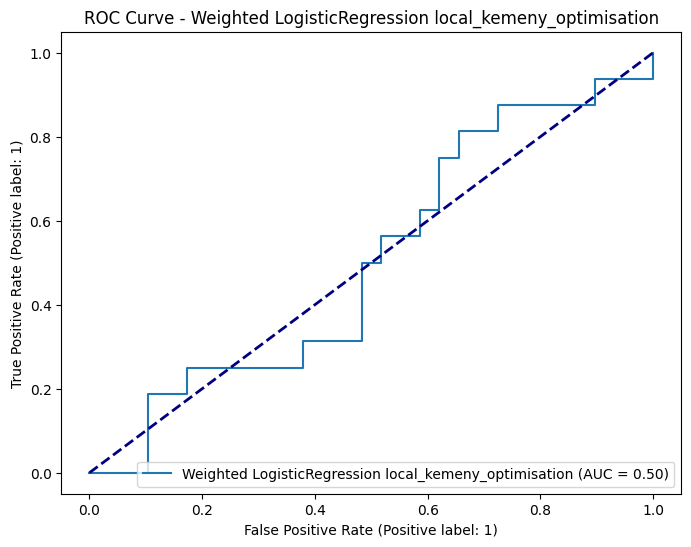

In [45]:
0# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
home_advt = 'no'
weighted = 'yes'
random_state = 47
weights = {0: 50, 1: 50} # intial value before recalauclating
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_wlr = all_results_df
display(all_results_df_wlr)

all_data_act_pred_df_wlr = all_data_act_pred_df
display(all_data_act_pred_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results_unseen.xlsx")
all_data_act_pred_df_wlr.to_excel("fold_results_wlr_unseen.xlsx")

Weighted LogisticRegression with home advantage no_ranking
Updated model parameters:
  C: 10.0
  class_weight: {0: 50, 1: 50}
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: auto
  n_jobs: None
  penalty: l1
  random_state: None
  solver: liblinear
  tol: 0.0001
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility',

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Weighted LogisticRegression with home advantage no_ranking  \
0                                               0.764           
1                                               0.000           
2                                               0.556           
3                                               0.000           
4                                               0.244           
5                                               0.000           
6                                               0.125           
7                                               0.000           
8                                               0.485           
9                                               1.373           
10                                              0.556           
11                                             23.000           
12                                              6.000           
13                                             14.000           
14                                              2.000           
15                                              0.622           
16                                              0.793           
17                                              0.697           
18                                              0.250           
19                                              0.125           
20                                              0.167           
21                                              0.436           
22                                              0.459           
23                                              0.432           
24                                              0.489           
25                                              0.556           
26                                              0.508           
27                                              0.463           

   Weighted LogisticRegression with home advantage round_3_position  \
0                                               0.757                 
1                                               0.000                 
2                                               0.533                 
3                                  

ml_name_ranking  Actual  Predicted  \
0    Weighted LogisticRegression with home advantag...       0          0   
1    Weighted LogisticRegression with home advantag...       0          0   
2    Weighted LogisticRegression with home advantag...       0          0   
3    Weighted LogisticRegression with home advantag...       0          0   
4    Weighted LogisticRegression with home advantag...       0          0   
..                                                 ...     ...        ...   
355  Weighted LogisticRegression with home advantag...       0          0   
356  Weighted LogisticRegression with home advantag...       0          0   
357  Weighted LogisticRegression with home advantag...       1          1   
358  Weighted LogisticRegression with home advantag...       0          1   
359  Weighted LogisticRegression with home advantag...       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

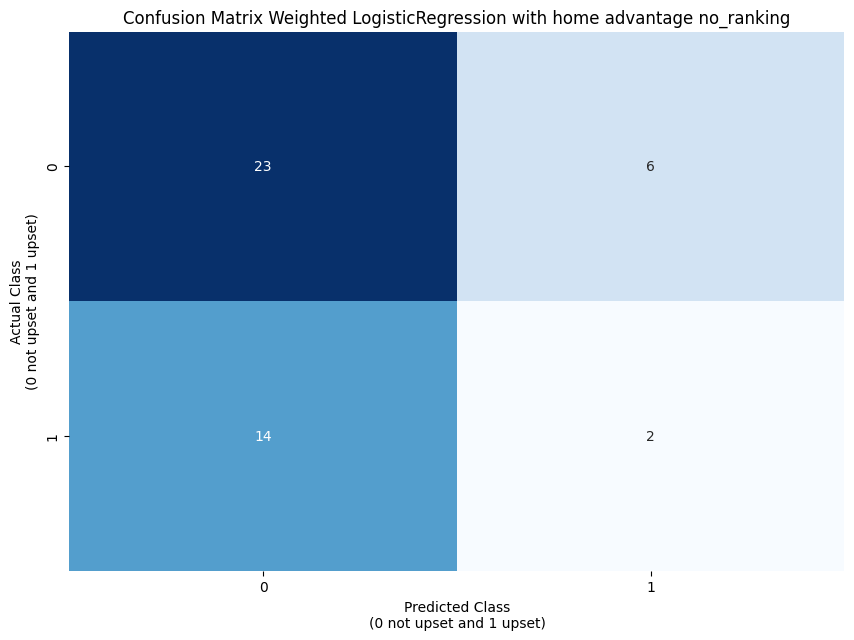

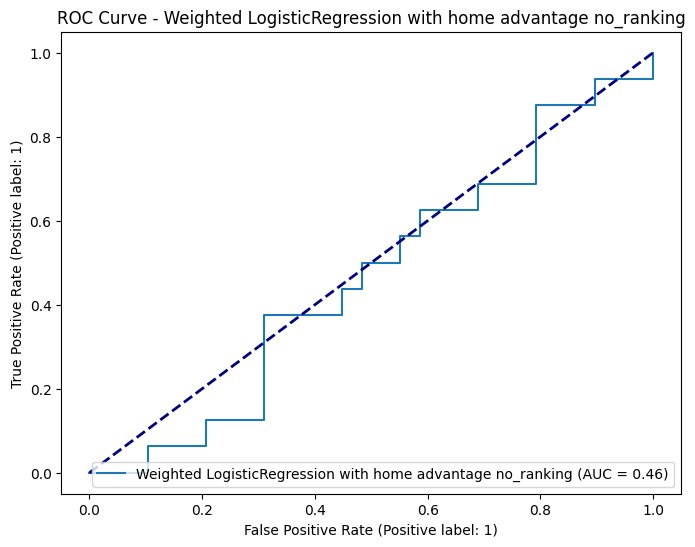

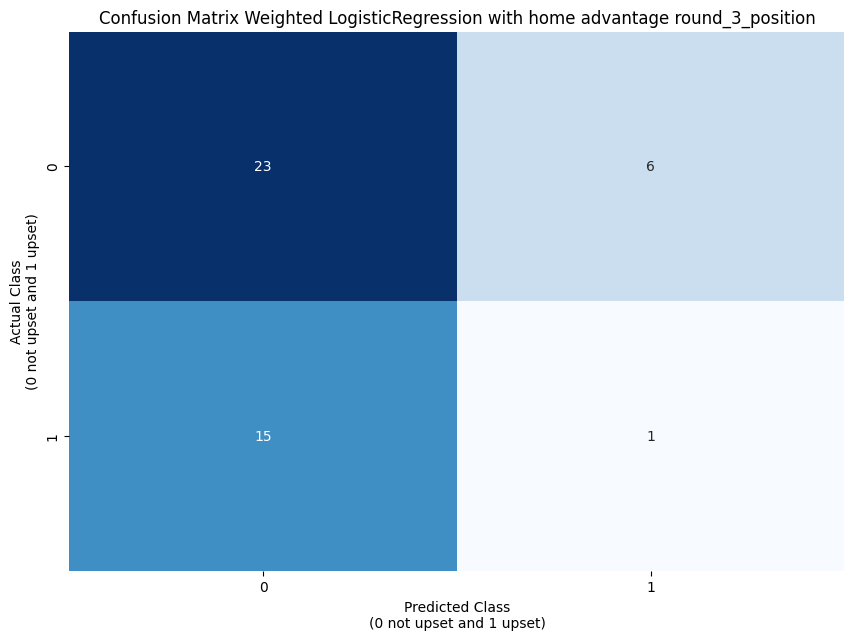

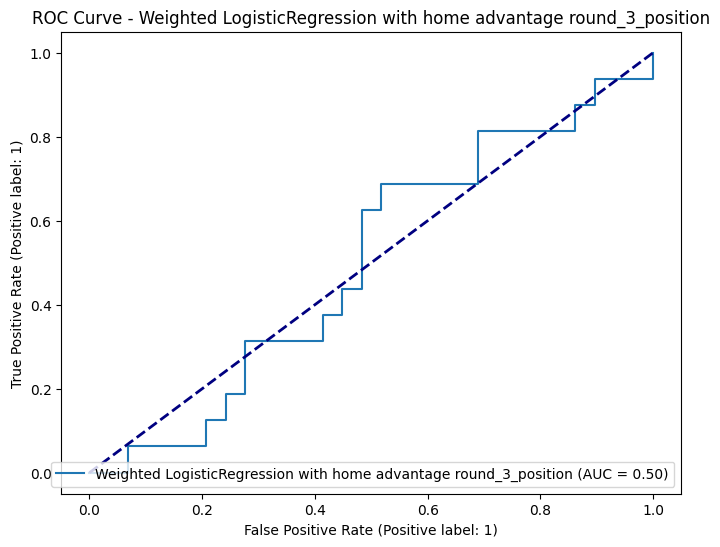

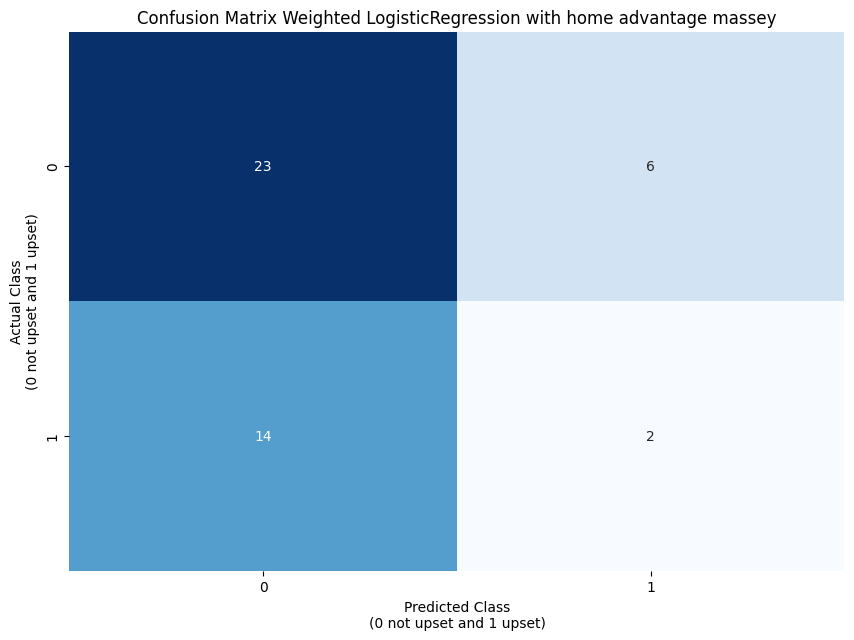

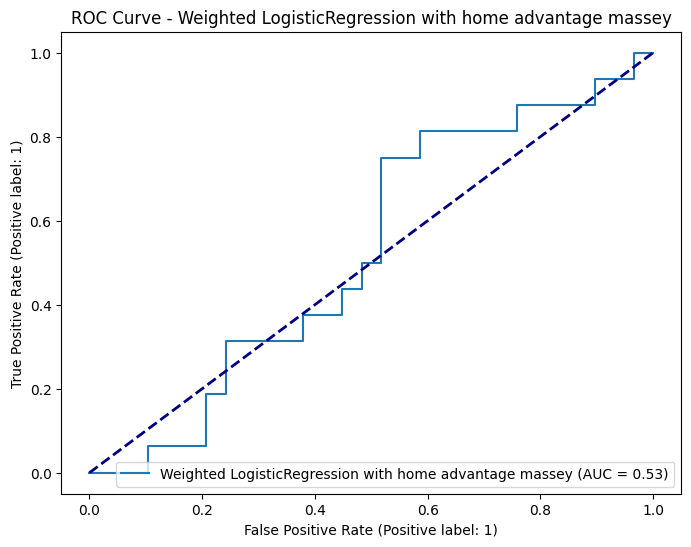

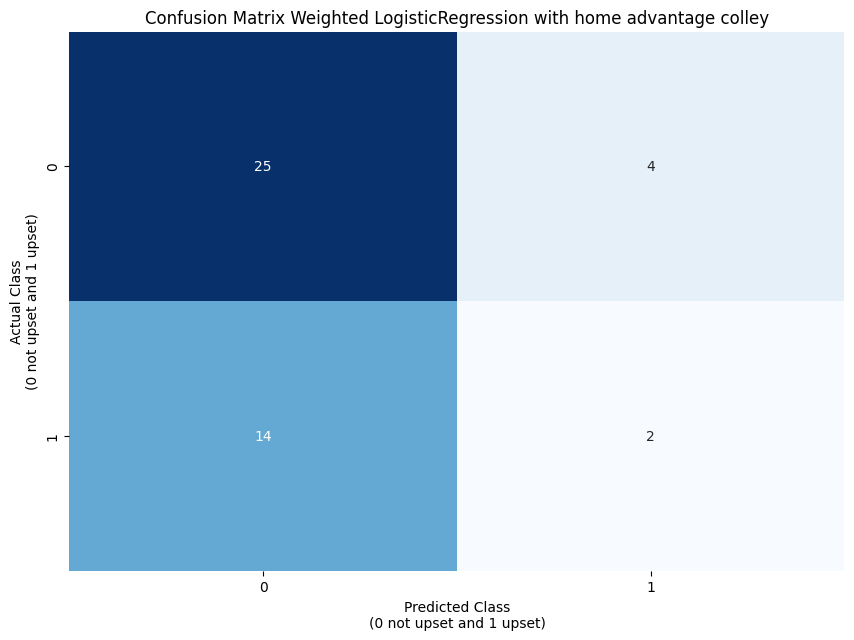

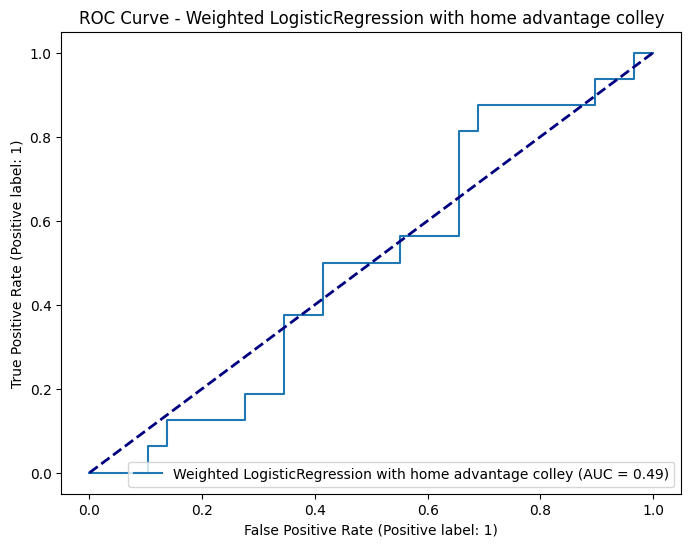

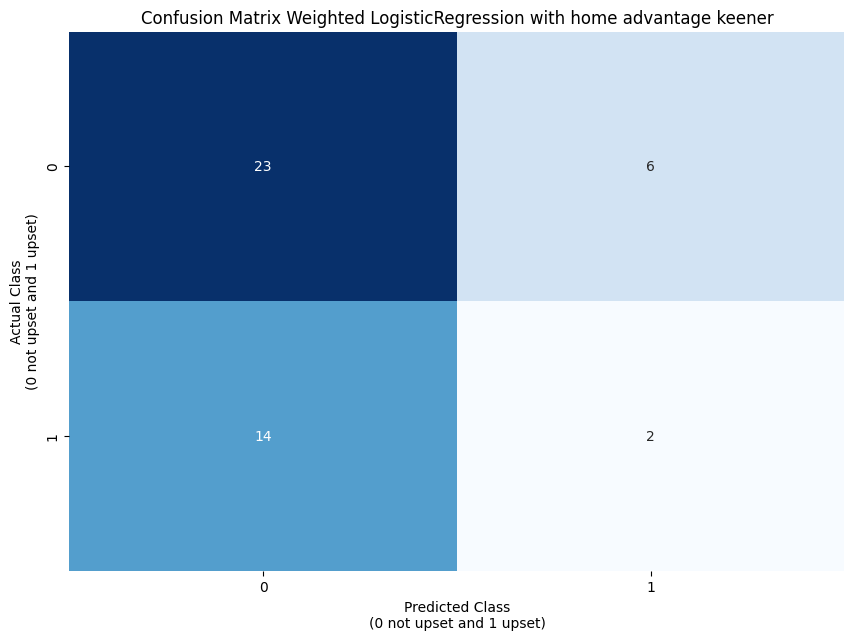

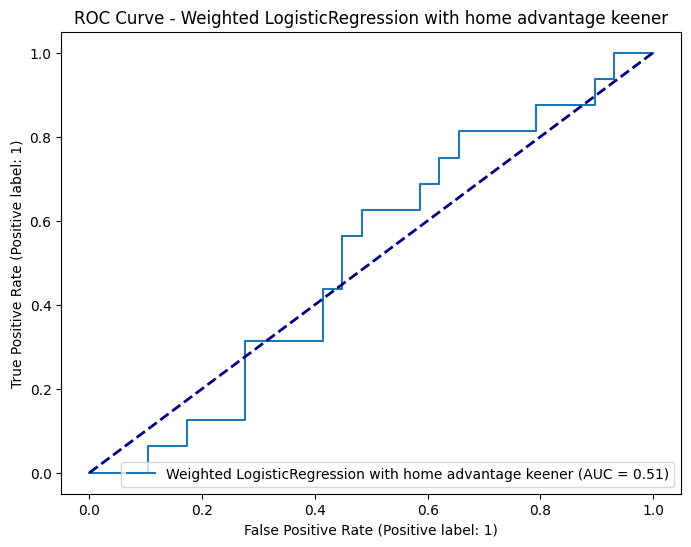

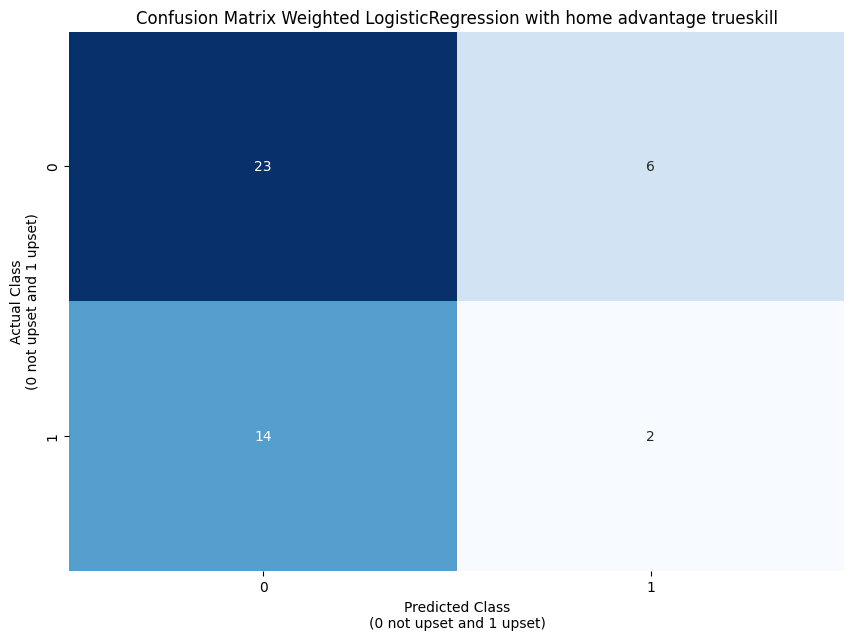

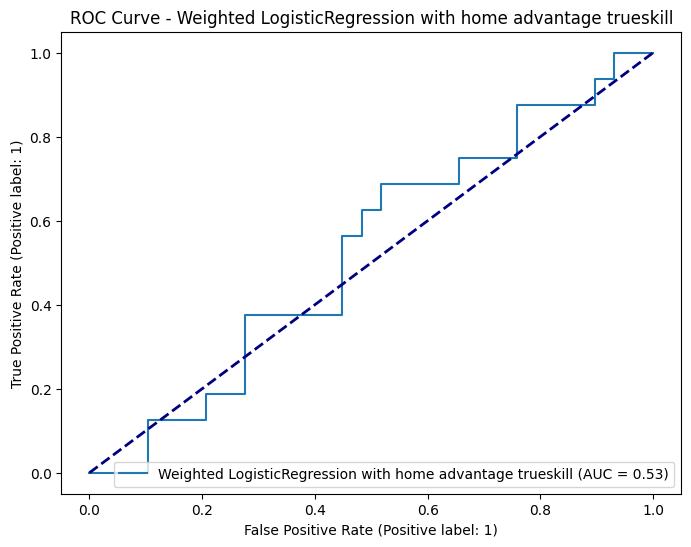

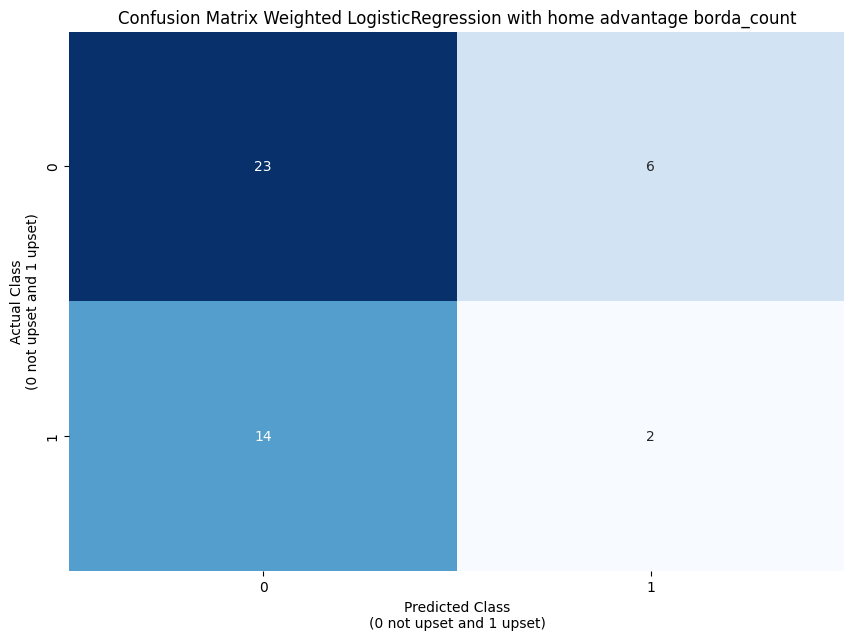

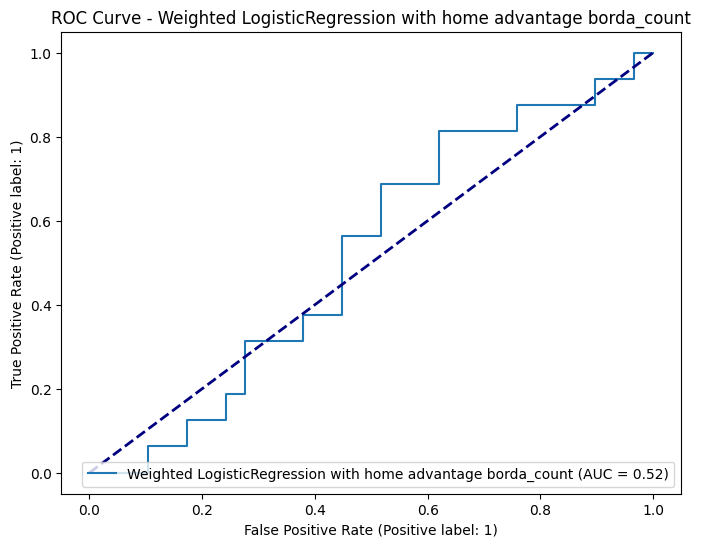

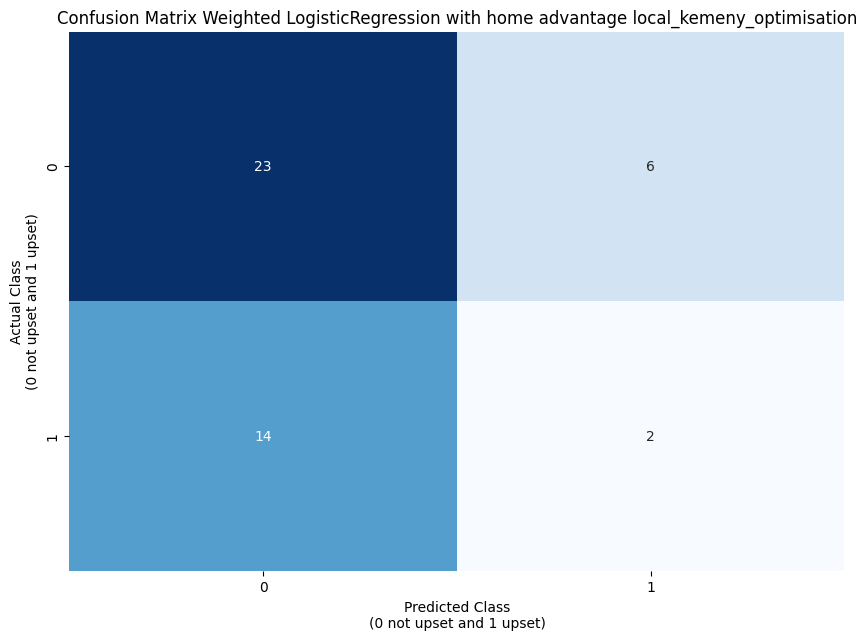

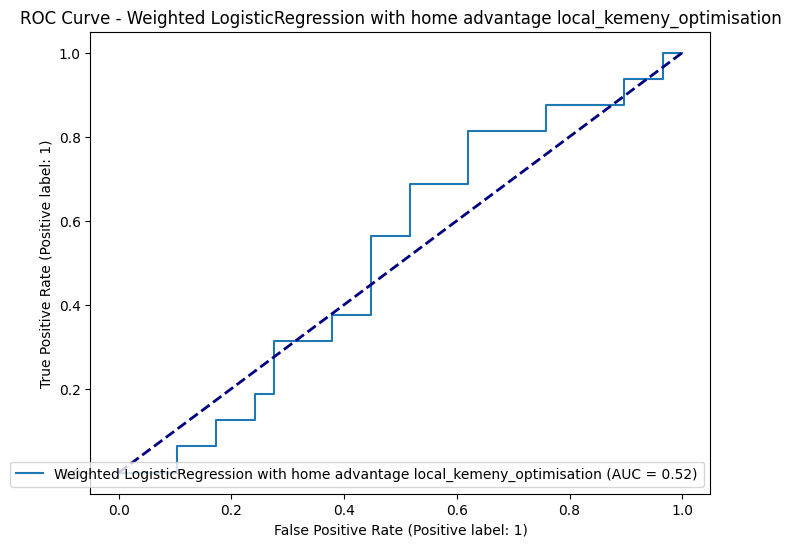

In [46]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'yes'
random_state = 47
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

all_data_act_pred_df_wlrh = all_data_act_pred_df
display(all_data_act_pred_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
all_data_act_pred_df_wlrh.to_excel("all_data_act_pred_dfwlrh.xlsx")

MLP Classifier Neural Network no_ranking
Updated model parameters:
  activation: tanh
  alpha: 0.0001
  batch_size: auto
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: False
  epsilon: 1e-08
  hidden_layer_sizes: (10, 10, 10)
  learning_rate: constant
  learning_rate_init: 0.01
  max_fun: 15000
  max_iter: 10000
  momentum: 0.9
  n_iter_no_change: 10
  nesterovs_momentum: True
  power_t: 0.5
  random_state: 47
  shuffle: True
  solver: adam
  tol: 0.0001
  validation_fraction: 0.1
  verbose: False
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_d

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   MLP Classifier Neural Network no_ranking  \
0                                     1.000   
1                                     0.000   
2                                     0.511   
3                                     0.000   
4                                     1.000   
5                                     0.000   
6                                     0.312   
7                                     0.000   
8                                     0.003   
9                                     3.874   
10                                    0.511   
11                                   18.000   
12                                   11.000   
13                                   11.000   
14                                    5.000   
15                                    0.621   
16                                    0.621   
17                                    0.621   
18                                    0.312   
19                                    0.312   
20                                    0.312   
21                                    0.467   
22                                    0.467   
23                                    0.467   
24                                    0.511   
25                                    0.511   
26                                    0.511   
27                                    0.489   

   MLP Classifier Neural Network round_3_position  \
0                                           0.967   
1                                           0.000   
2                                           0.444   
3                                           0.000   
4                                           0.951   
5                                           0.000   
6                                           0.125   
7                                           0.000   
8                                           0.103   
9                                           3.173   
10                                          0.444   
11                                         18.000   
12                                         11.000   
13                                         14.000   
14                                          2.

ml_name_ranking  Actual  Predicted  \
0             MLP Classifier Neural Network no_ranking       0          0   
1             MLP Classifier Neural Network no_ranking       0          0   
2             MLP Classifier Neural Network no_ranking       0          0   
3             MLP Classifier Neural Network no_ranking       0          0   
4             MLP Classifier Neural Network no_ranking       0          0   
..                                                 ...     ...        ...   
355  MLP Classifier Neural Network local_kemeny_opt...       0          0   
356  MLP Classifier Neural Network local_kemeny_opt...       0          1   
357  MLP Classifier Neural Network local_kemeny_opt...       1          1   
358  MLP Classifier Neural Network local_kemeny_opt...       0          1   
359  MLP Classifier Neural Network local_kemeny_opt...       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

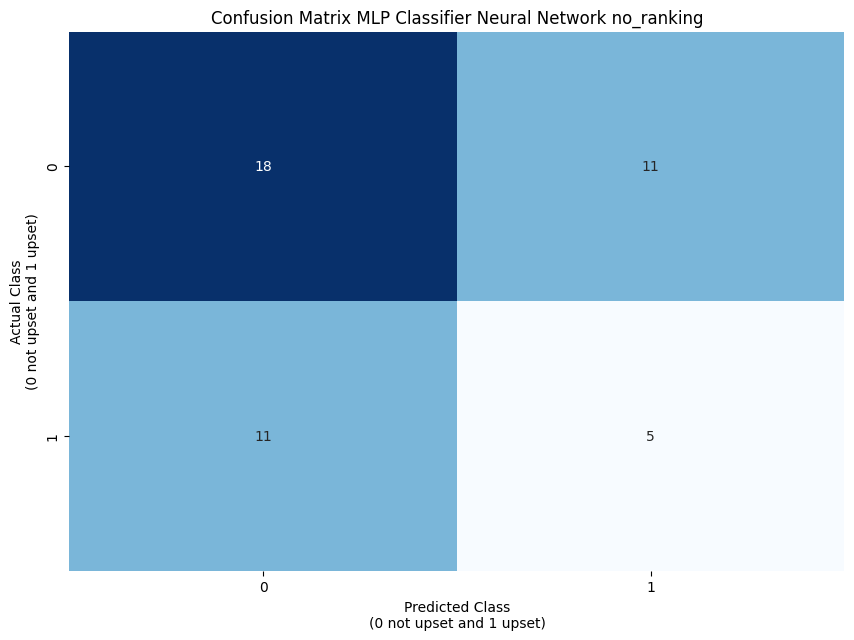

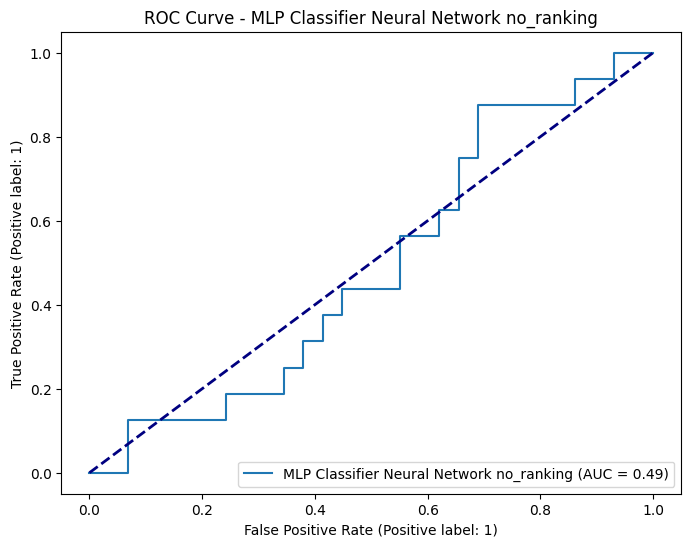

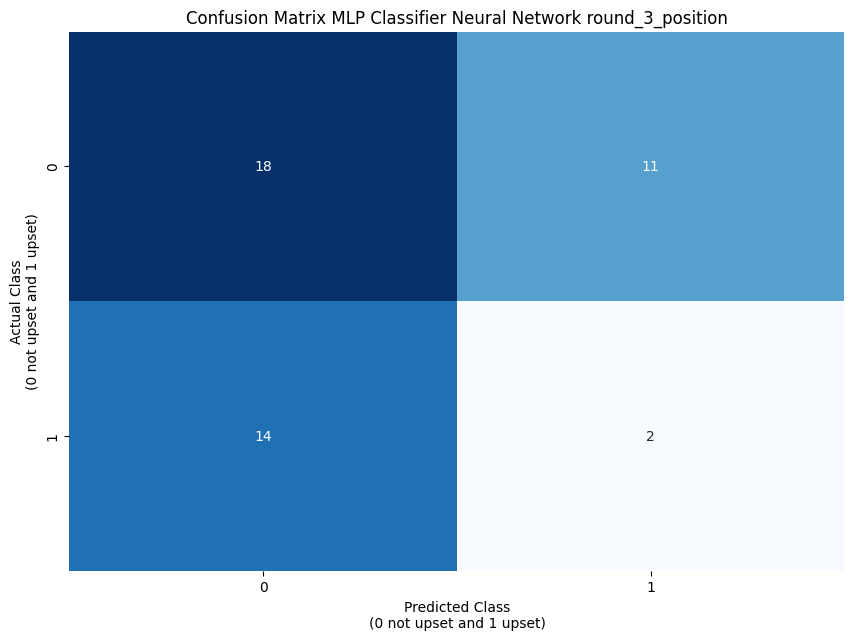

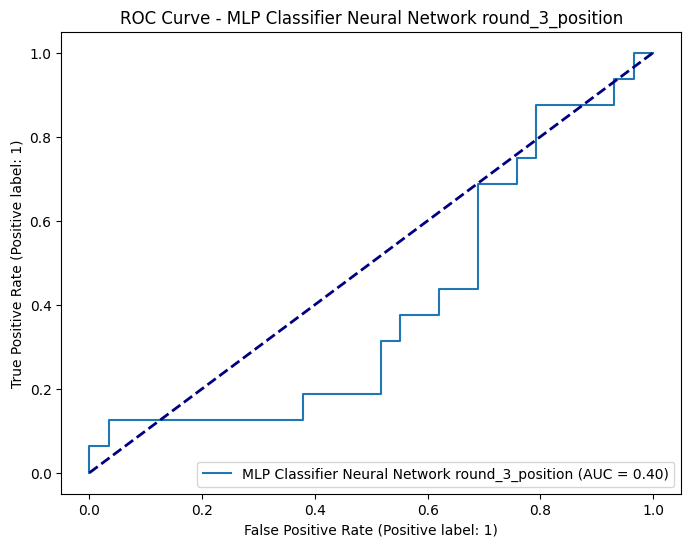

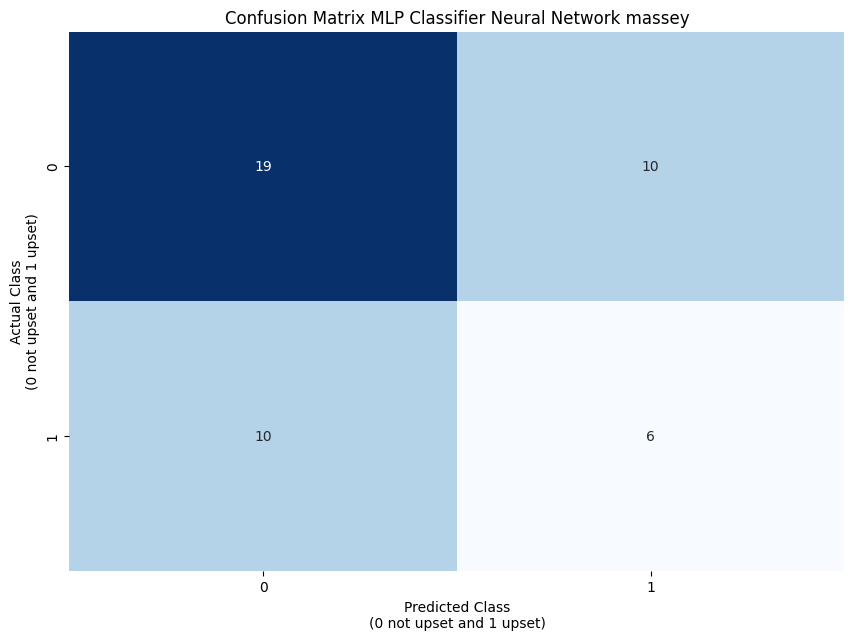

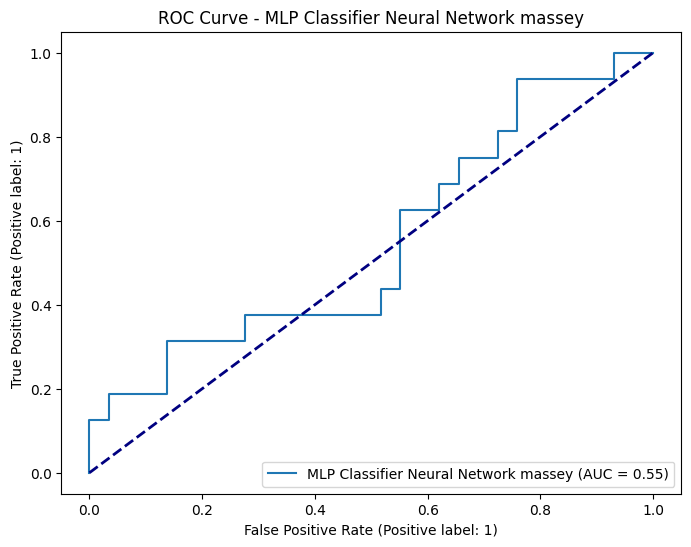

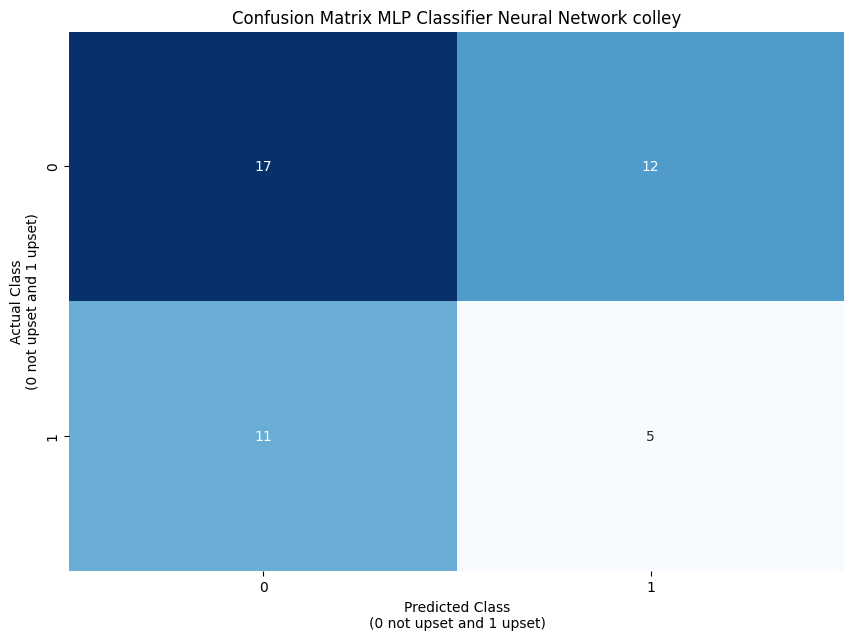

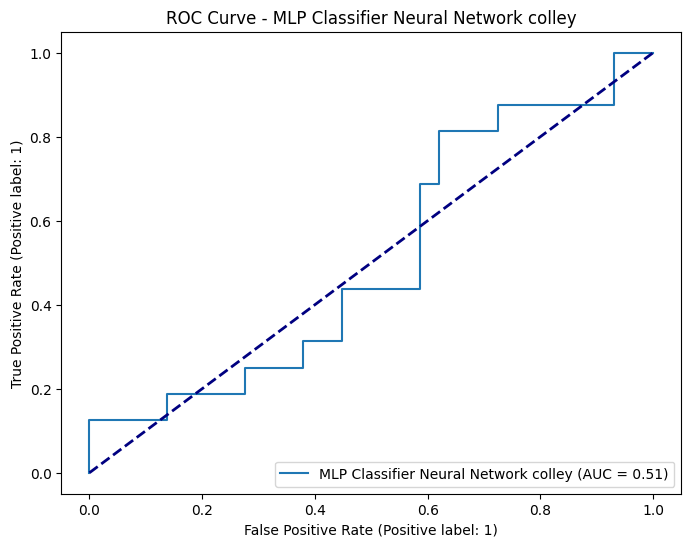

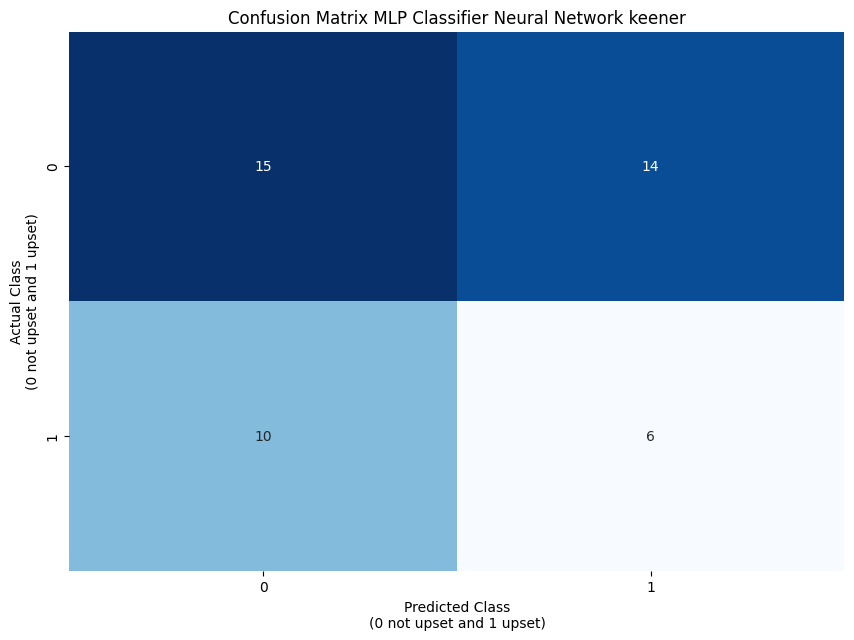

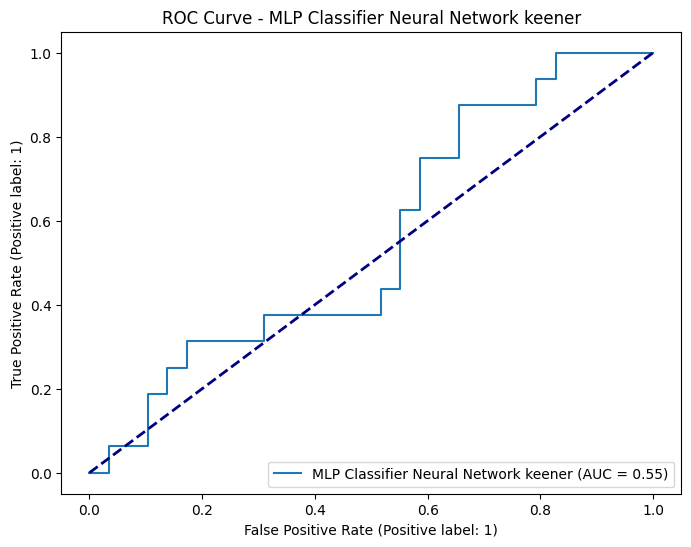

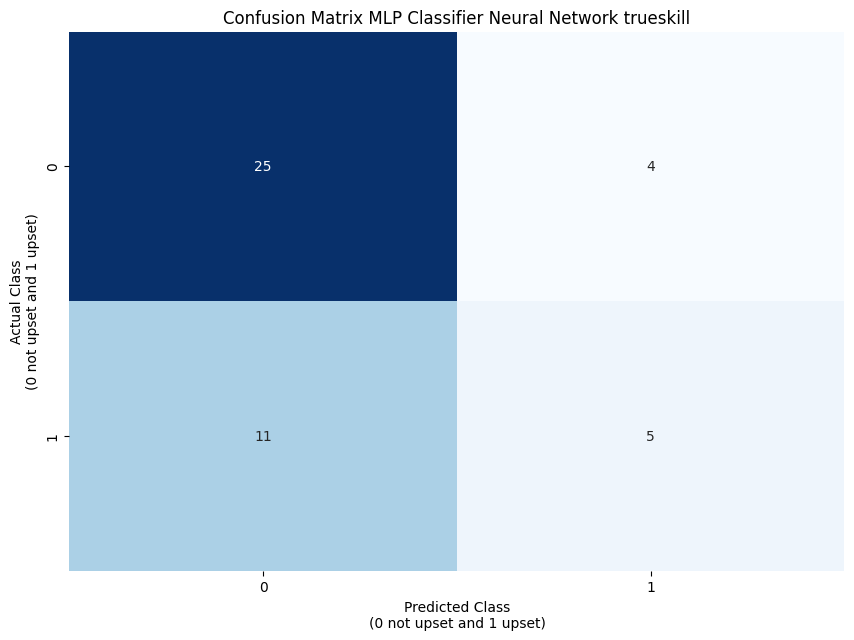

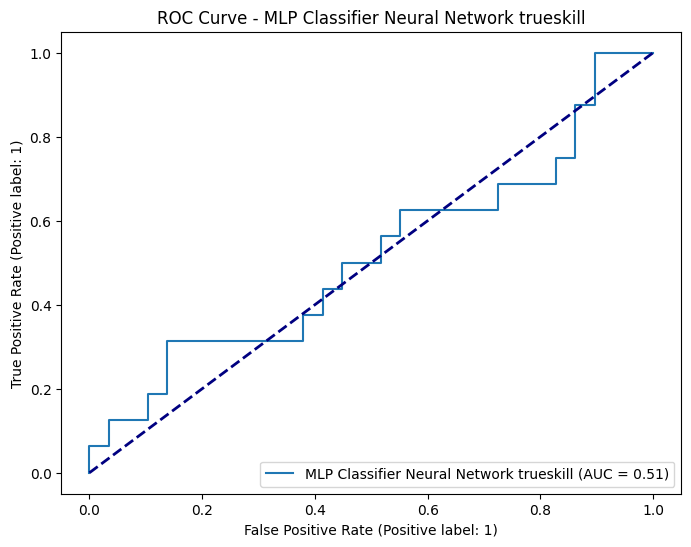

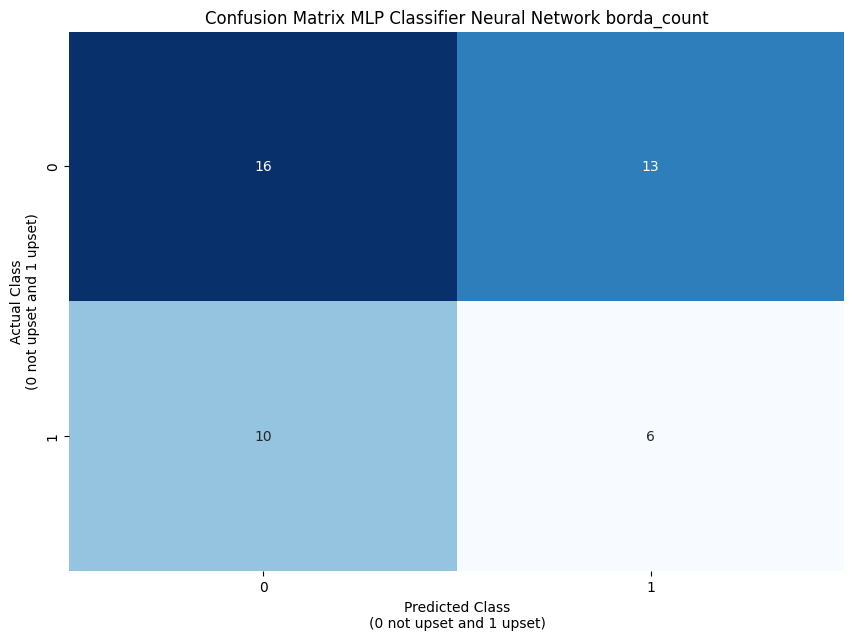

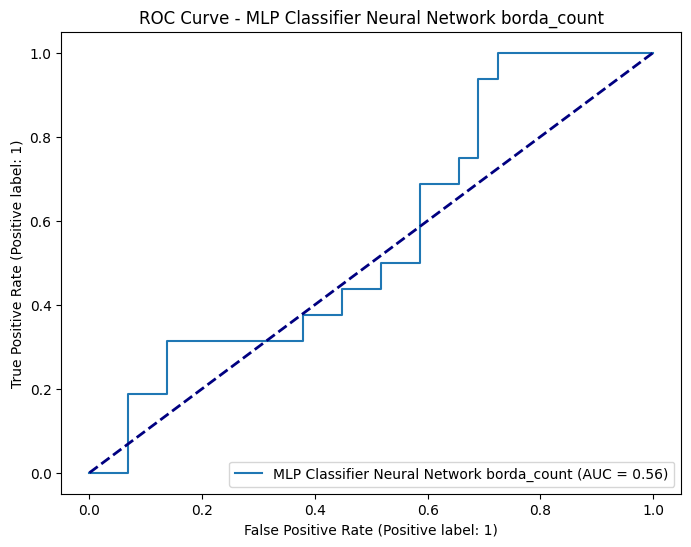

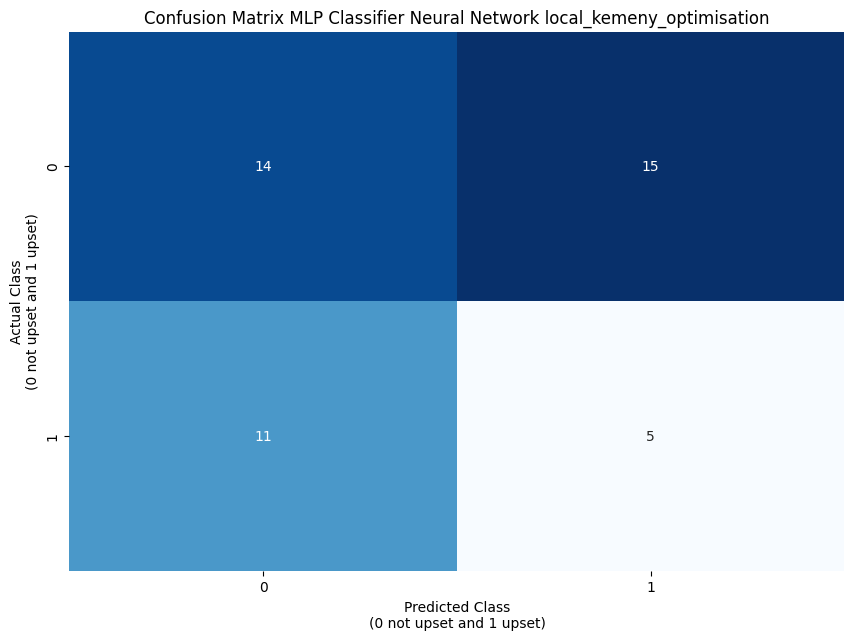

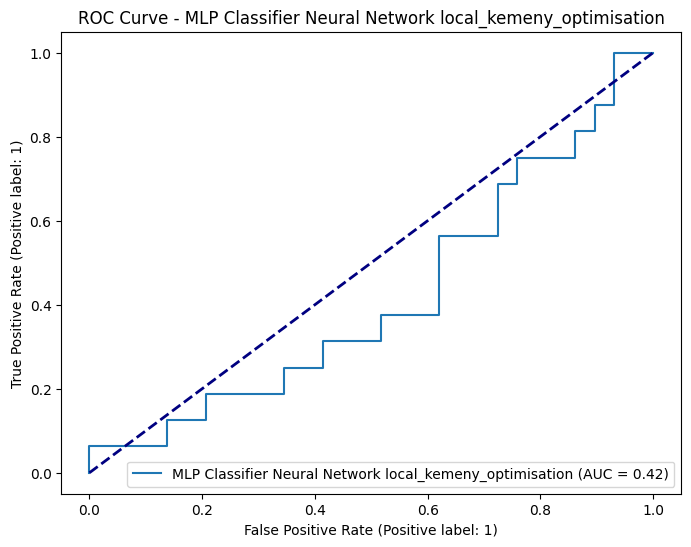

In [47]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = MLPClassifier(max_iter = 10000)

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_nn = all_results_df
display(all_results_df_nn)

all_data_act_pred_df_nn = all_data_act_pred_df
display(all_data_act_pred_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")
all_data_act_pred_df_nn.to_excel("fold_results_nn.xlsx")

MLP Classifier Neural Network with home advantage no_ranking
Updated model parameters:
  activation: relu
  alpha: 0.0001
  batch_size: auto
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: False
  epsilon: 1e-08
  hidden_layer_sizes: (20, 20)
  learning_rate: constant
  learning_rate_init: 0.01
  max_fun: 15000
  max_iter: 10000
  momentum: 0.9
  n_iter_no_change: 10
  nesterovs_momentum: True
  power_t: 0.5
  random_state: 47
  shuffle: True
  solver: adam
  tol: 0.0001
  validation_fraction: 0.1
  verbose: False
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   MLP Classifier Neural Network with home advantage no_ranking  \
0                                               1.000             
1                                               0.000             
2                                               0.489             
3                                               0.000             
4                                               1.000             
5                                               0.000             
6                                               0.125             
7                                               0.000             
8                                               0.004             
9                                               7.009             
10                                              0.489             
11                                             20.000             
12                                              9.000             
13                                             14.000             
14                                              2.000             
15                                              0.588             
16                                              0.690             
17                                              0.635             
18                                              0.182             
19                                              0.125             
20                                              0.148             
21                                              0.385             
22                                              0.407             
23                                              0.392             
24                                              0.444             
25                                              0.489             
26                                              0.462             
27                                              0.478             

   MLP Classifier Neural Network with home advantage round_3_position  \
0                                               1.000                   
1                                               0.000                   
2                                         

ml_name_ranking  Actual  Predicted  \
0    MLP Classifier Neural Network with home advant...       0          0   
1    MLP Classifier Neural Network with home advant...       0          0   
2    MLP Classifier Neural Network with home advant...       0          0   
3    MLP Classifier Neural Network with home advant...       0          0   
4    MLP Classifier Neural Network with home advant...       0          0   
..                                                 ...     ...        ...   
355  MLP Classifier Neural Network with home advant...       0          1   
356  MLP Classifier Neural Network with home advant...       0          1   
357  MLP Classifier Neural Network with home advant...       1          0   
358  MLP Classifier Neural Network with home advant...       0          0   
359  MLP Classifier Neural Network with home advant...       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

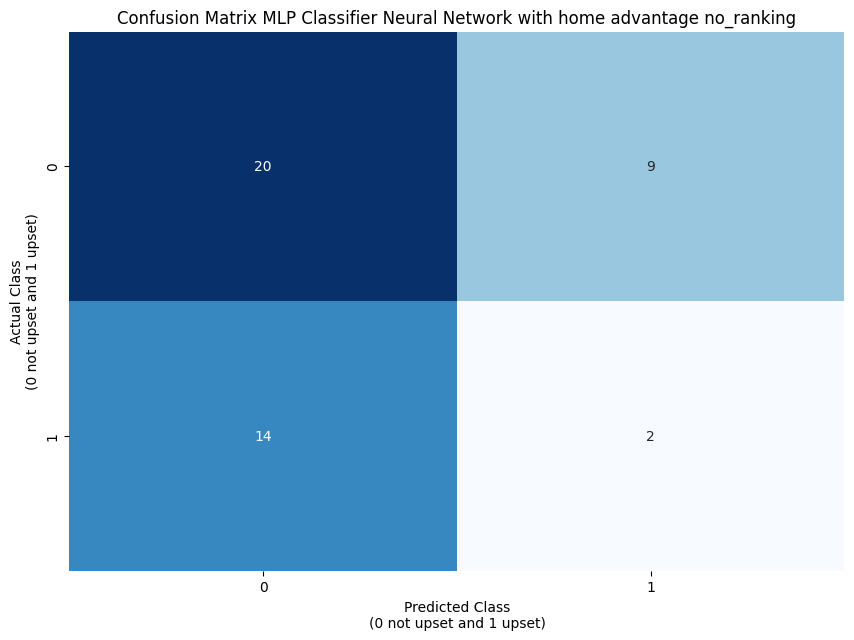

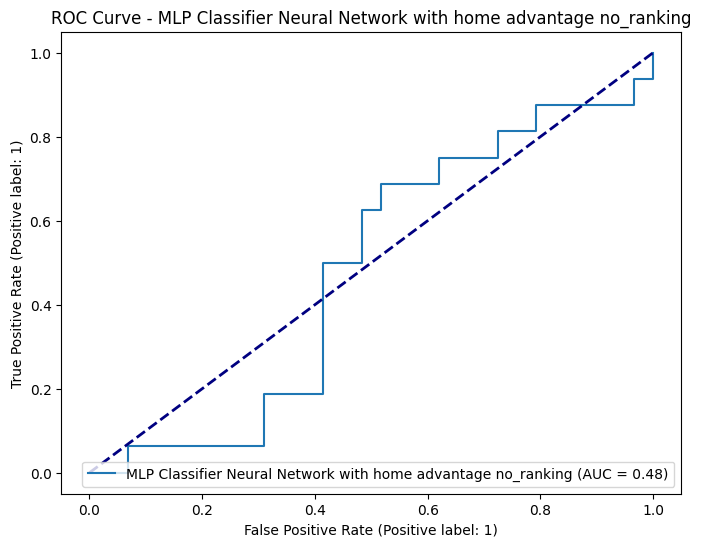

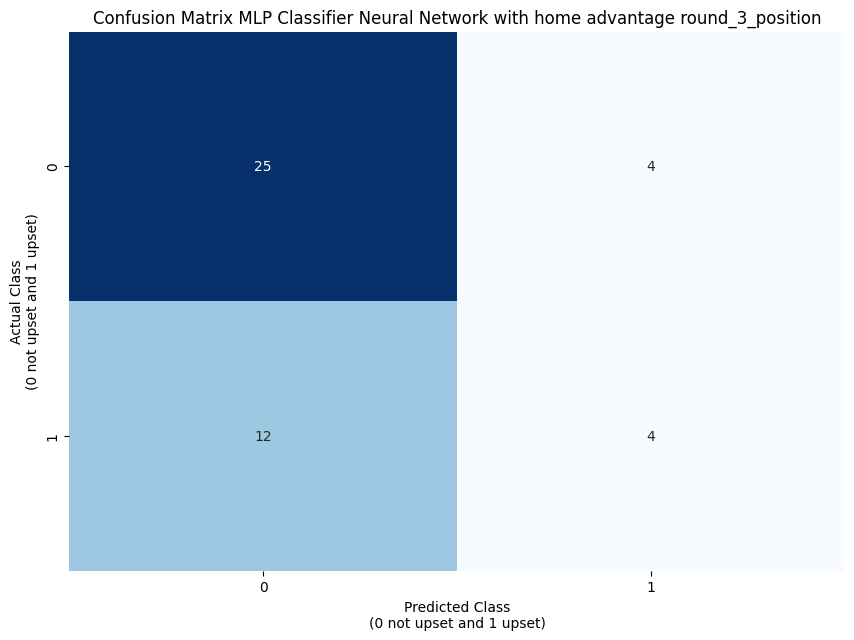

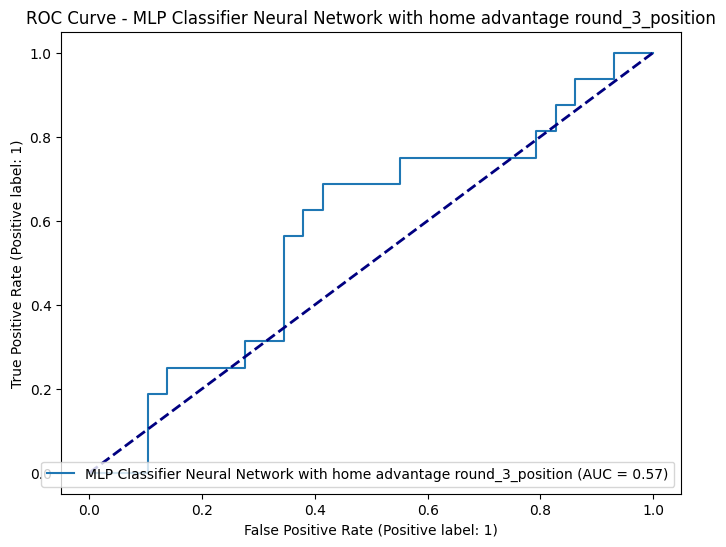

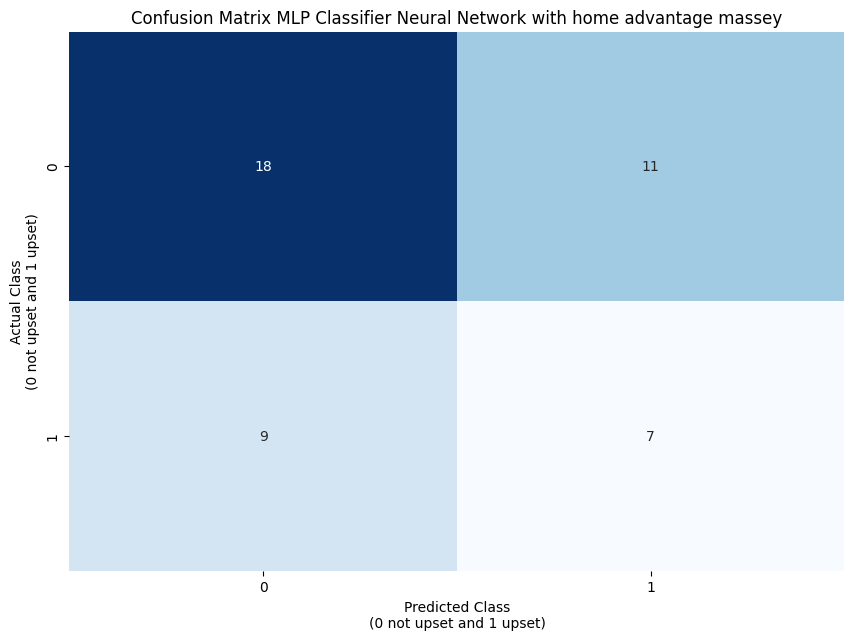

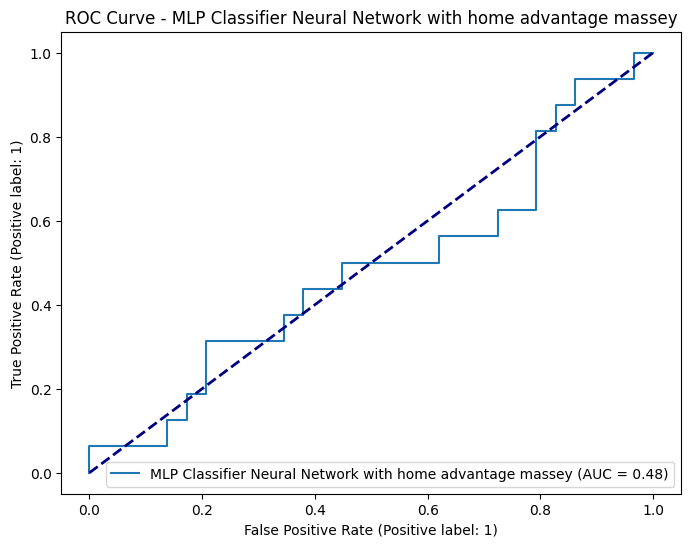

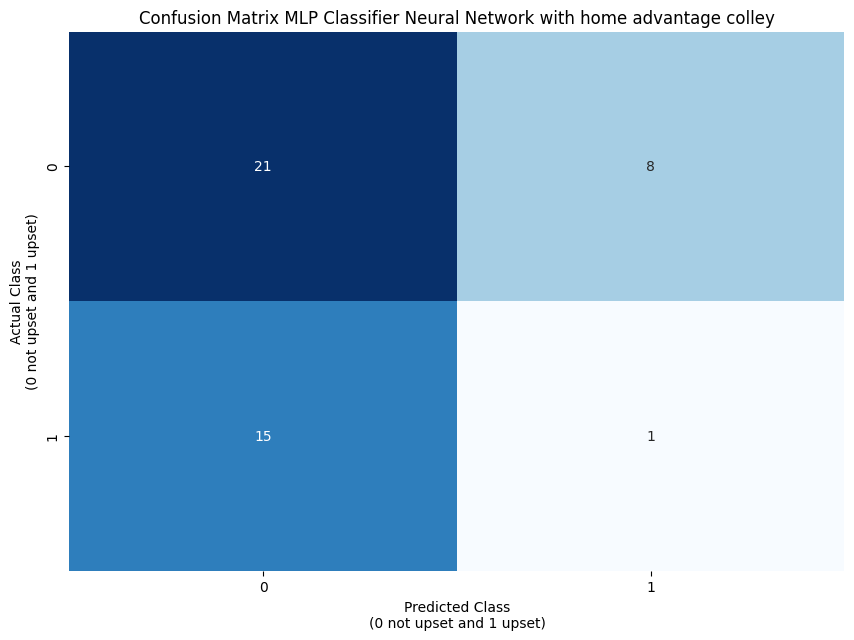

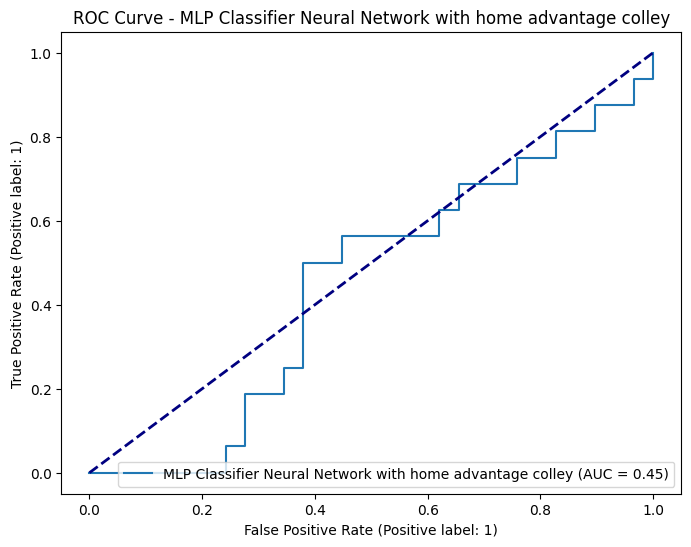

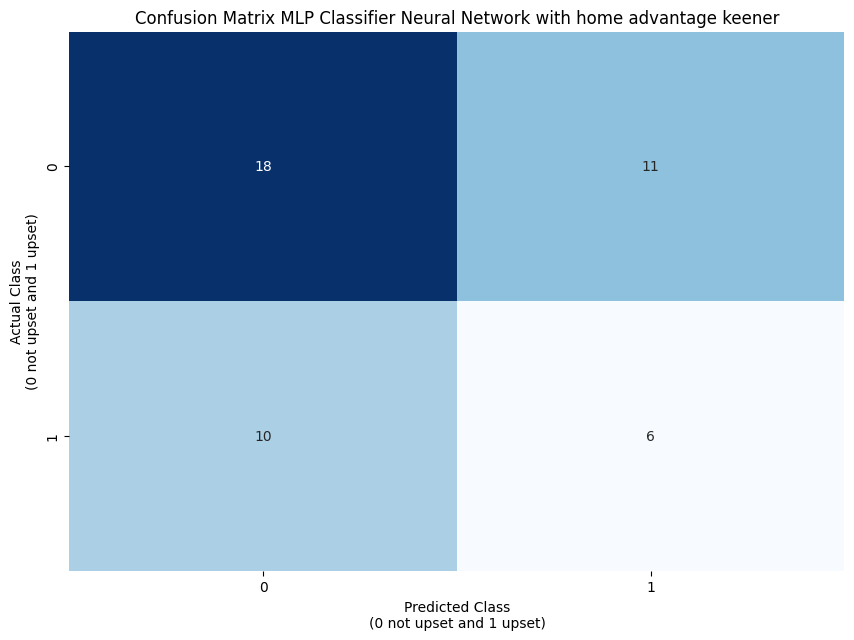

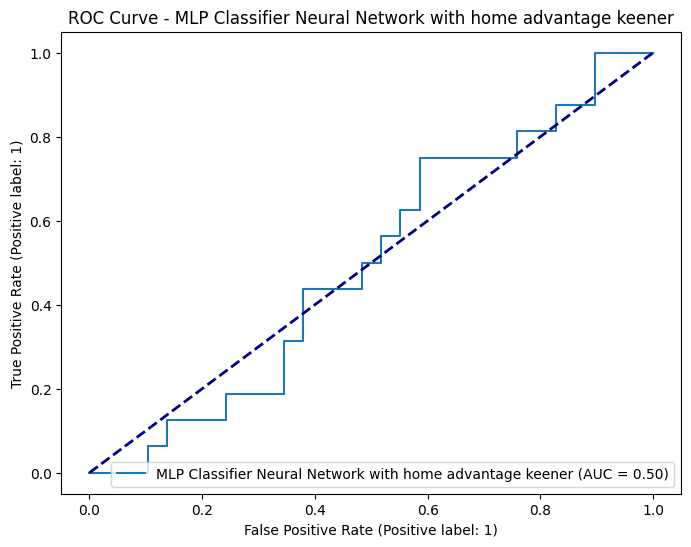

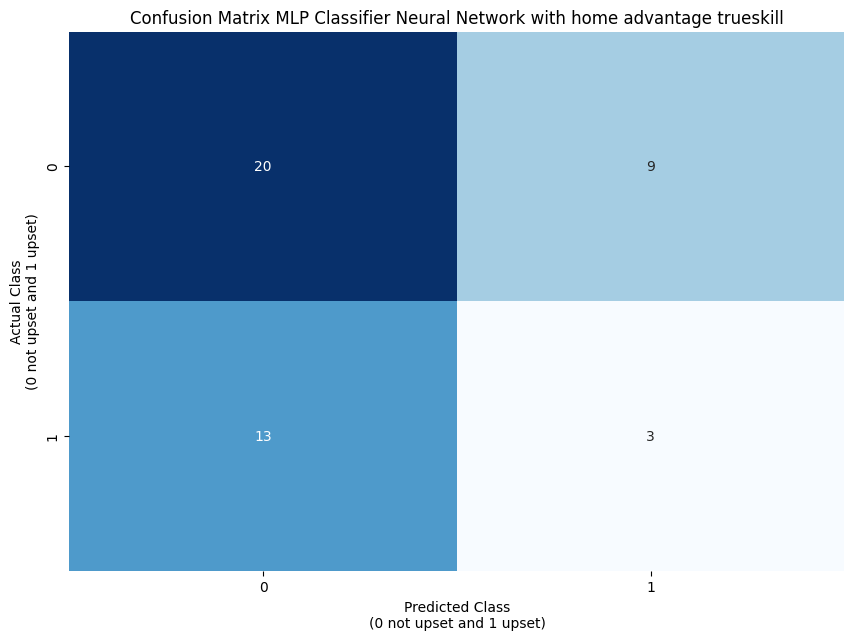

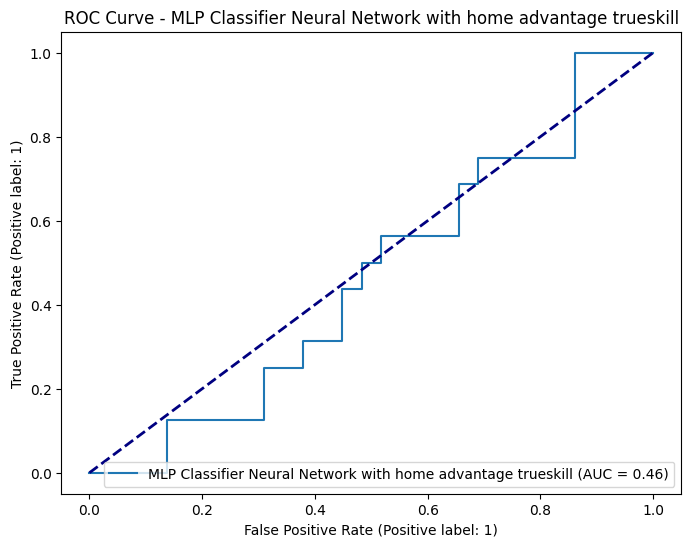

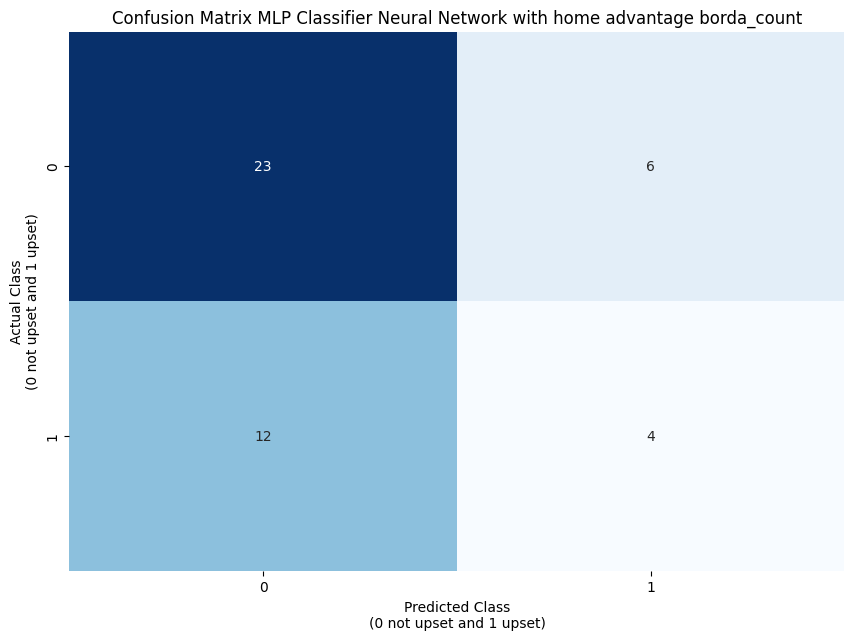

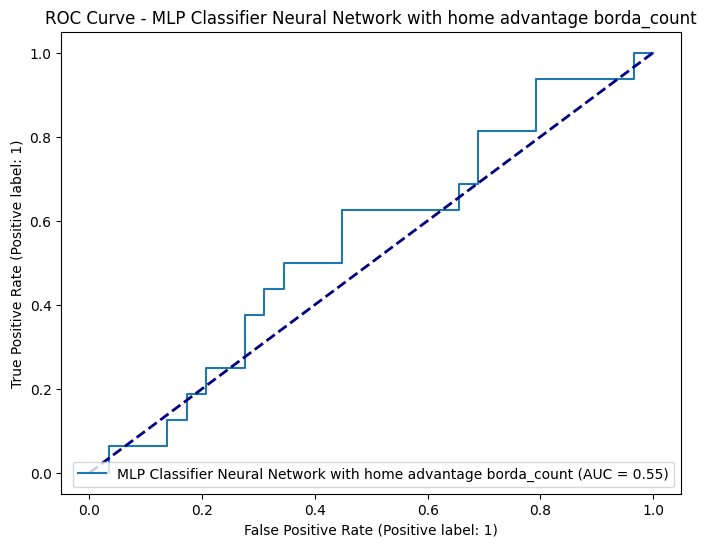

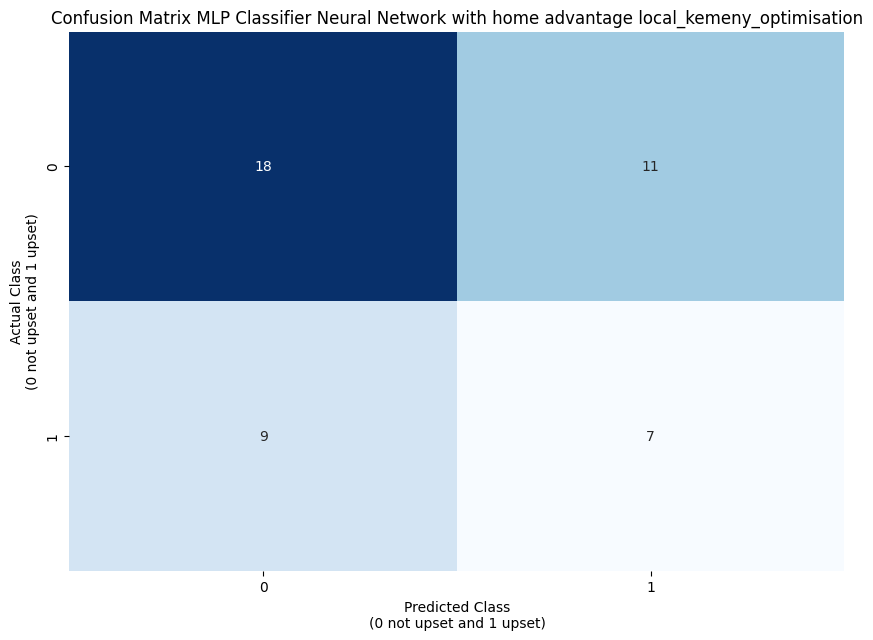

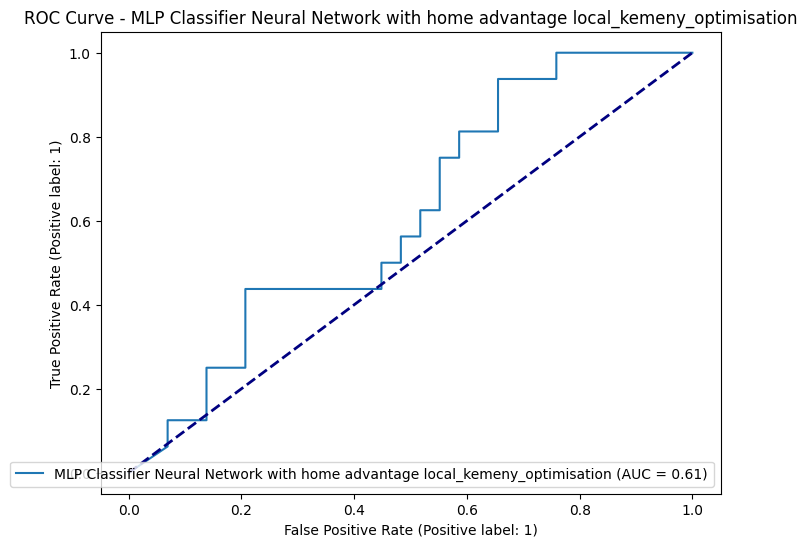

In [48]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = MLPClassifier(max_iter = 10000)

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_nnh = all_results_df
display(all_results_df_nnh)

all_data_act_pred_df_nnh = all_data_act_pred_df
display(all_data_act_pred_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")
all_data_act_pred_df_nnh.to_excel("fold_results_nnh.xlsx")

Random Forest Classifier no_ranking
Updated model parameters:
  bootstrap: True
  ccp_alpha: 0.0
  class_weight: None
  criterion: gini
  max_depth: None
  max_features: None
  max_leaf_nodes: None
  max_samples: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 2
  min_weight_fraction_leaf: 0.0
  n_estimators: 200
  n_jobs: None
  oob_score: False
  random_state: 47
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', '

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Random Forest Classifier no_ranking  \
0                                1.000   
1                                0.000   
2                                0.556   
3                                0.000   
4                                1.000   
5                                0.000   
6                                0.250   
7                                0.000   
8                                0.157   
9                                0.672   
10                               0.556   
11                              21.000   
12                               8.000   
13                              12.000   
14                               4.000   
15                               0.636   
16                               0.724   
17                               0.677   
18                               0.333   
19                               0.250   
20                               0.286   
21                               0.485   
22                               0.487   
23                               0.482   
24                               0.529   
25                               0.556   
26                               0.538   
27                               0.562   

   Random Forest Classifier round_3_position Random Forest Classifier massey  \
0                                      0.997                           1.000   
1                                      0.000                           0.000   
2                                      0.556                           0.578   
3                                      0.000                           0.000   
4                                      0.988                           1.000   
5                                      0.000                           0.000   
6                                      0.312                           0.250   
7                                      0.000                           0.000   
8                                      0.160                           0.149   
9                                      0.664                           0.657   
10                                     0.556                           0.578   
11                        

ml_name_ranking  Actual  Predicted  \
0                  Random Forest Classifier no_ranking       0          0   
1                  Random Forest Classifier no_ranking       0          0   
2                  Random Forest Classifier no_ranking       0          0   
3                  Random Forest Classifier no_ranking       0          0   
4                  Random Forest Classifier no_ranking       0          0   
..                                                 ...     ...        ...   
355  Random Forest Classifier local_kemeny_optimisa...       0          0   
356  Random Forest Classifier local_kemeny_optimisa...       0          1   
357  Random Forest Classifier local_kemeny_optimisa...       1          1   
358  Random Forest Classifier local_kemeny_optimisa...       0          0   
359  Random Forest Classifier local_kemeny_optimisa...       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

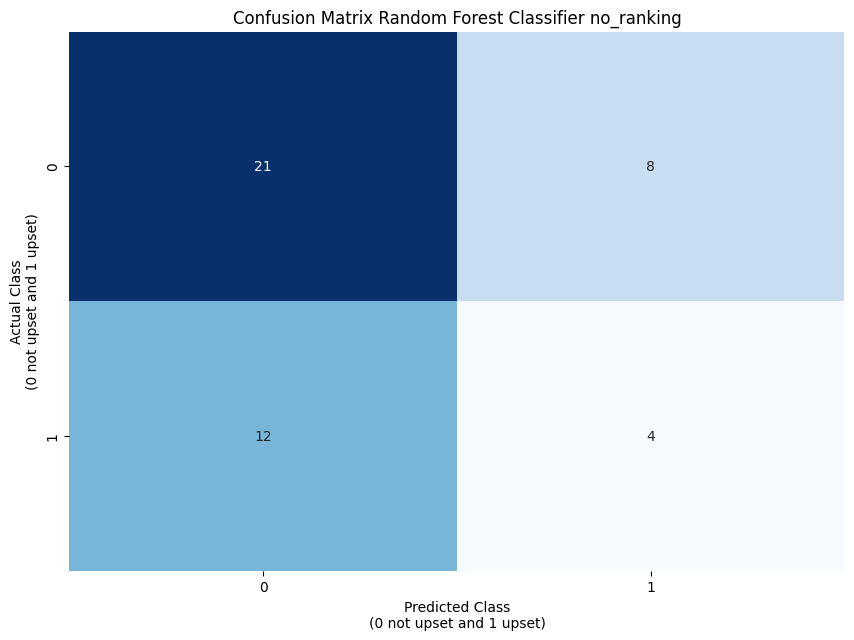

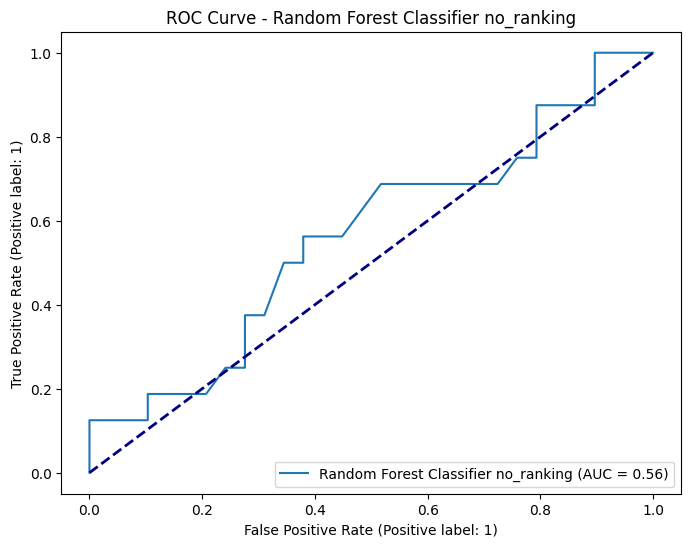

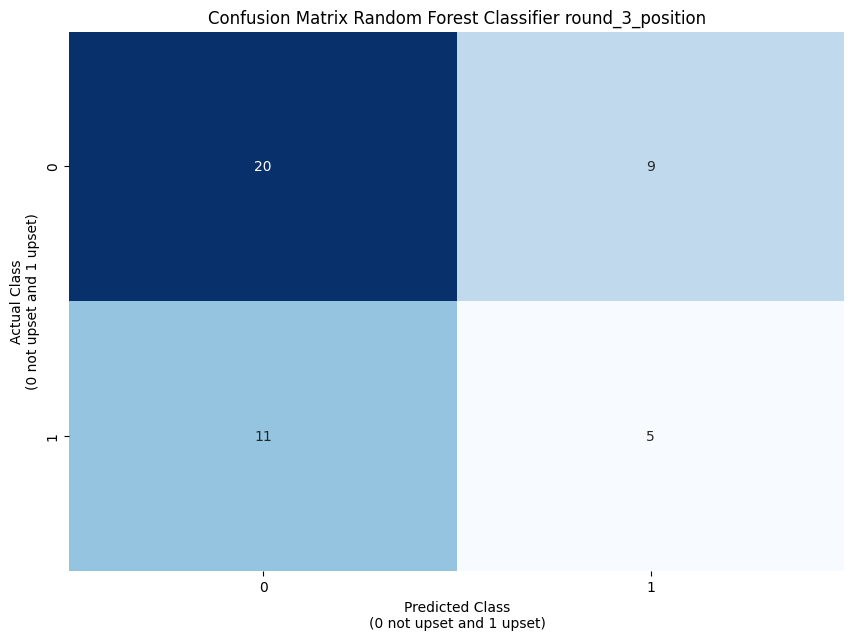

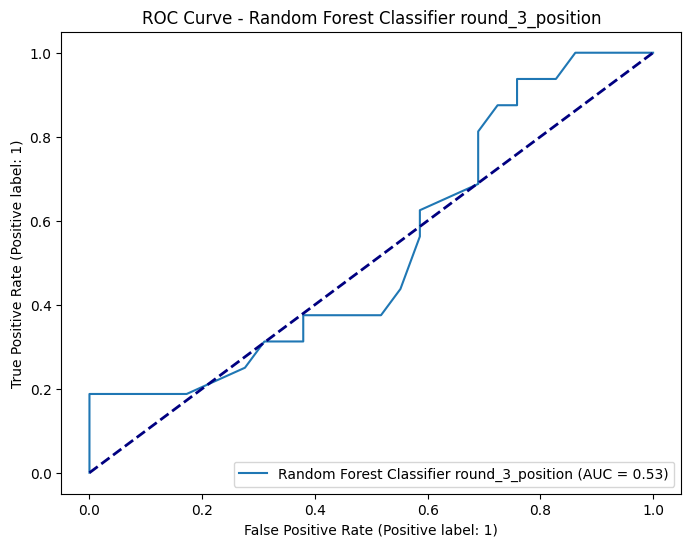

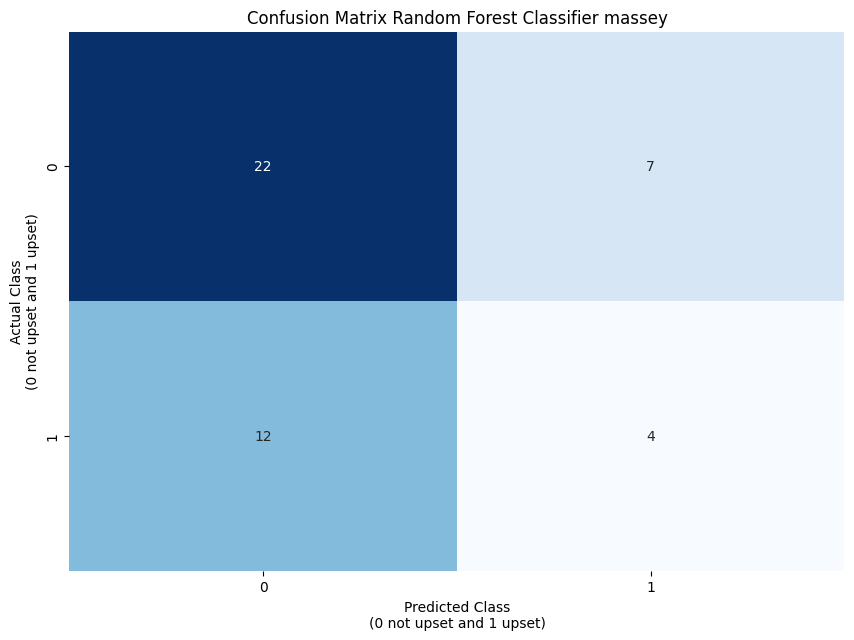

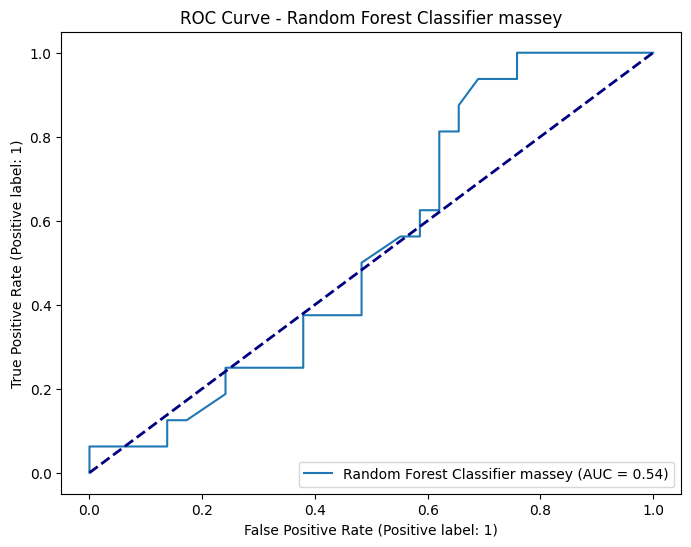

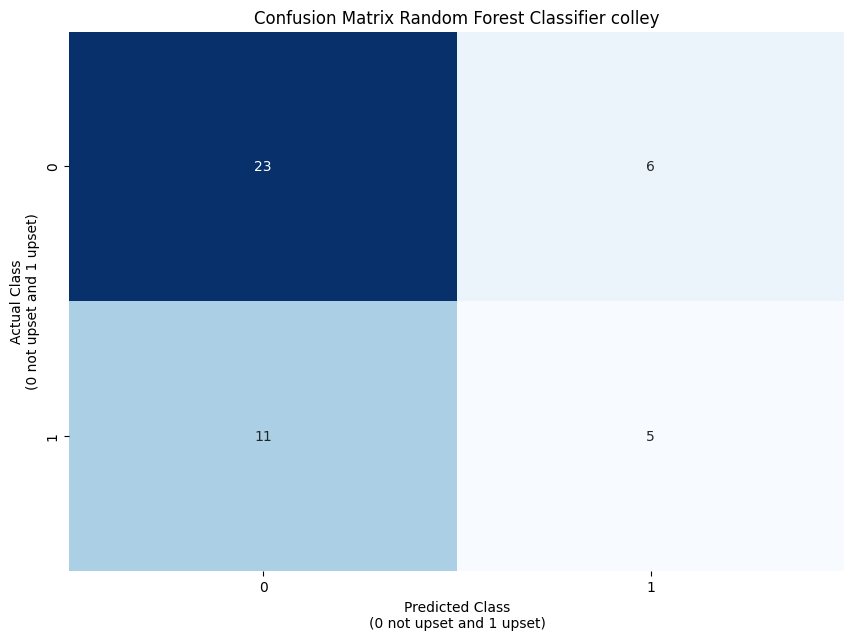

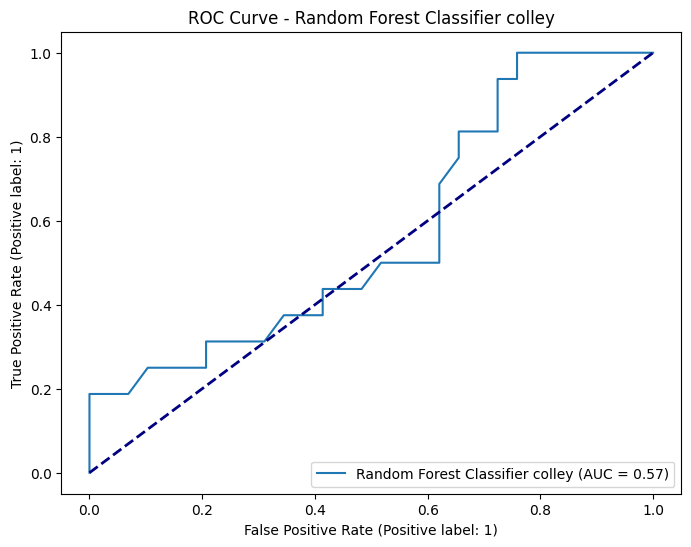

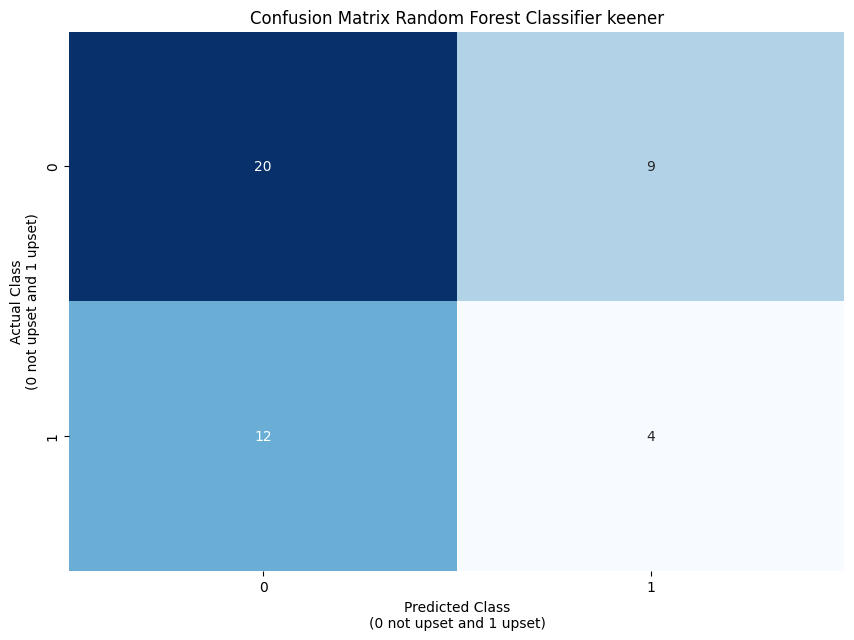

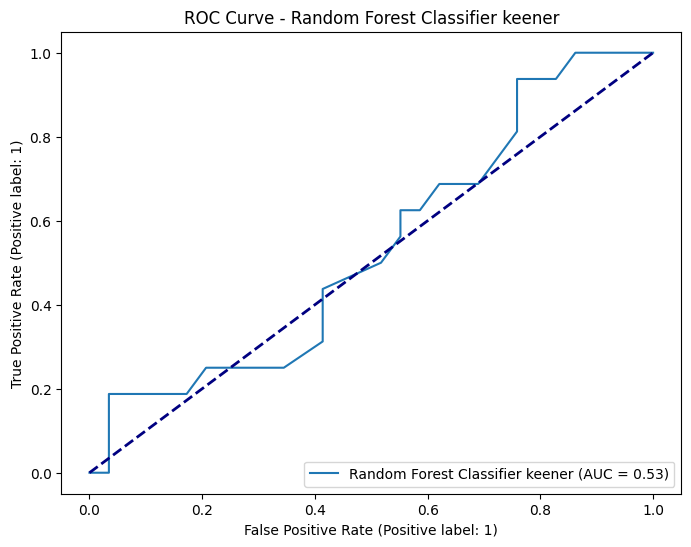

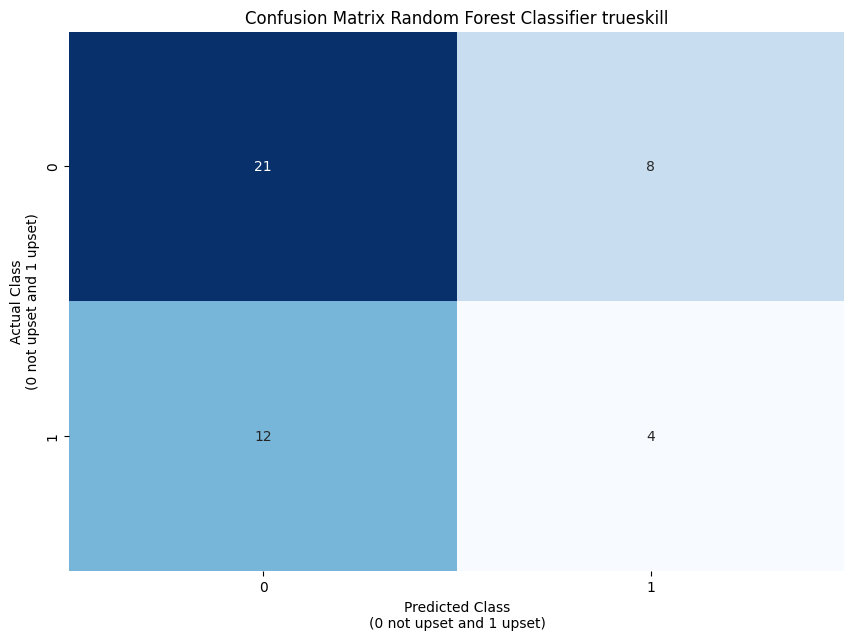

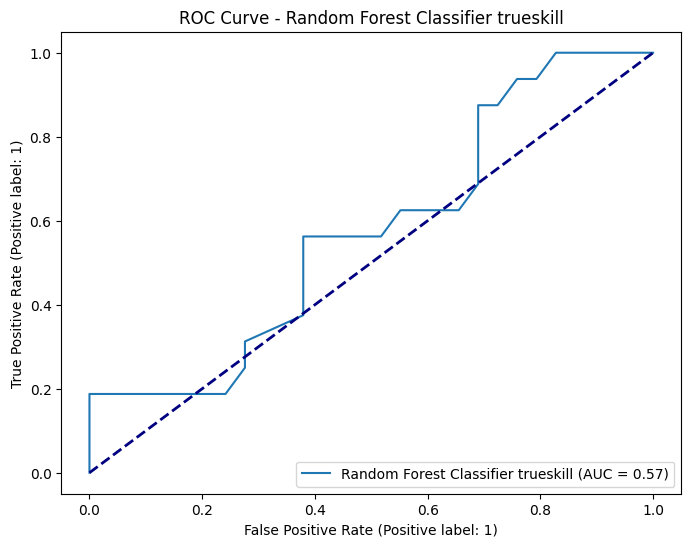

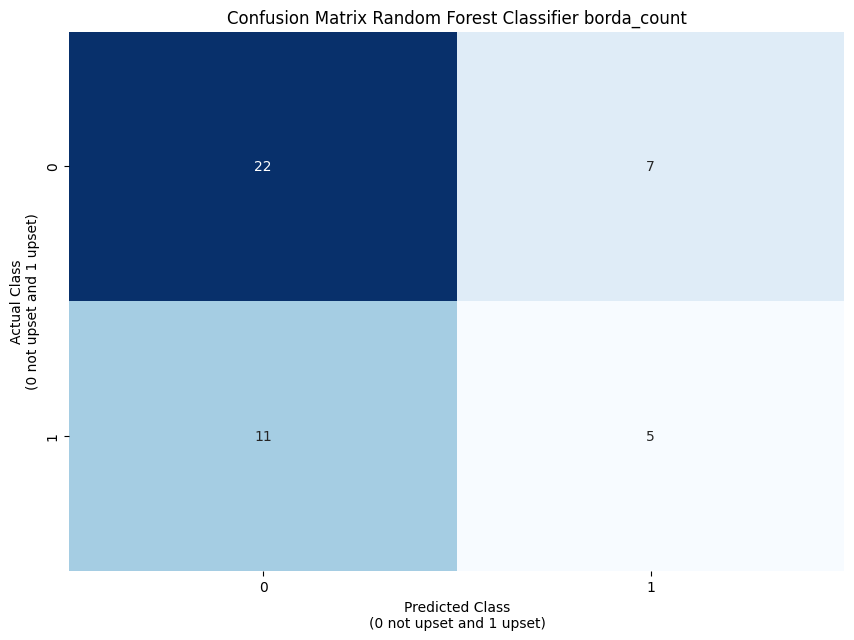

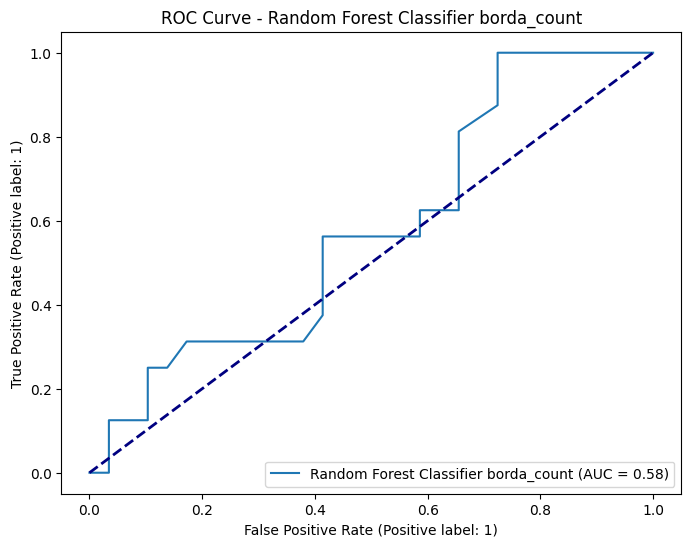

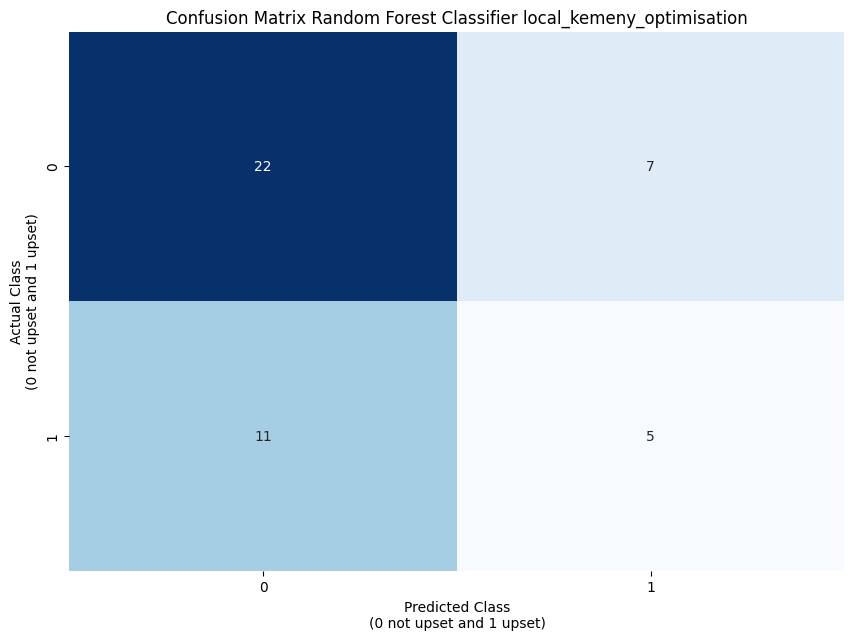

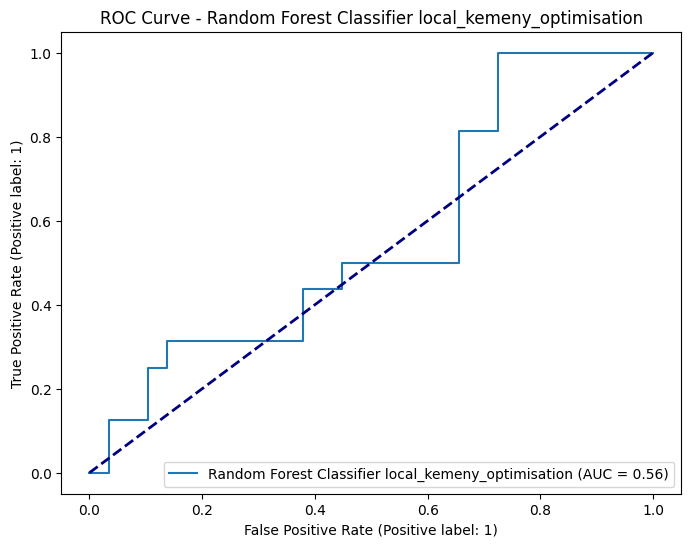

In [49]:
# Random Forest Classifier
model_name = "Random Forest Classifier"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)


all_results_df_rf = all_results_df
display(all_results_df_rf)

all_data_act_pred_df_rf = all_data_act_pred_df
display(all_data_act_pred_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
all_data_act_pred_df_rf.to_excel("fold_results_rf.xlsx")


Random Forest Classifier with home advantage no_ranking
Updated model parameters:
  bootstrap: True
  ccp_alpha: 0.0
  class_weight: None
  criterion: gini
  max_depth: None
  max_features: None
  max_leaf_nodes: None
  max_samples: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 2
  min_weight_fraction_leaf: 0.0
  n_estimators: 100
  n_jobs: None
  oob_score: False
  random_state: 47
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Random Forest Classifier with home advantage no_ranking  \
0                                               1.000        
1                                               0.000        
2                                               0.622        
3                                               0.000        
4                                               1.000        
5                                               0.000        
6                                               0.250        
7                                               0.000        
8                                               0.149        
9                                               0.636        
10                                              0.622        
11                                             24.000        
12                                              5.000        
13                                             12.000        
14                                              4.000        
15                                              0.667        
16                                              0.828        
17                                              0.738        
18                                              0.444        
19                                              0.250        
20                                              0.320        
21                                              0.556        
22                                              0.539        
23                                              0.529        
24                                              0.588        
25                                              0.622        
26                                              0.590        
27                                              0.591        

   Random Forest Classifier with home advantage round_3_position  \
0                                               1.000              
1                                               0.000              
2                                               0.578              
3                                               0.000              
4                                               1.000             

ml_name_ranking  Actual  Predicted  \
0    Random Forest Classifier with home advantage n...       0          0   
1    Random Forest Classifier with home advantage n...       0          0   
2    Random Forest Classifier with home advantage n...       0          0   
3    Random Forest Classifier with home advantage n...       0          0   
4    Random Forest Classifier with home advantage n...       0          0   
..                                                 ...     ...        ...   
355  Random Forest Classifier with home advantage l...       0          0   
356  Random Forest Classifier with home advantage l...       0          1   
357  Random Forest Classifier with home advantage l...       1          0   
358  Random Forest Classifier with home advantage l...       0          0   
359  Random Forest Classifier with home advantage l...       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

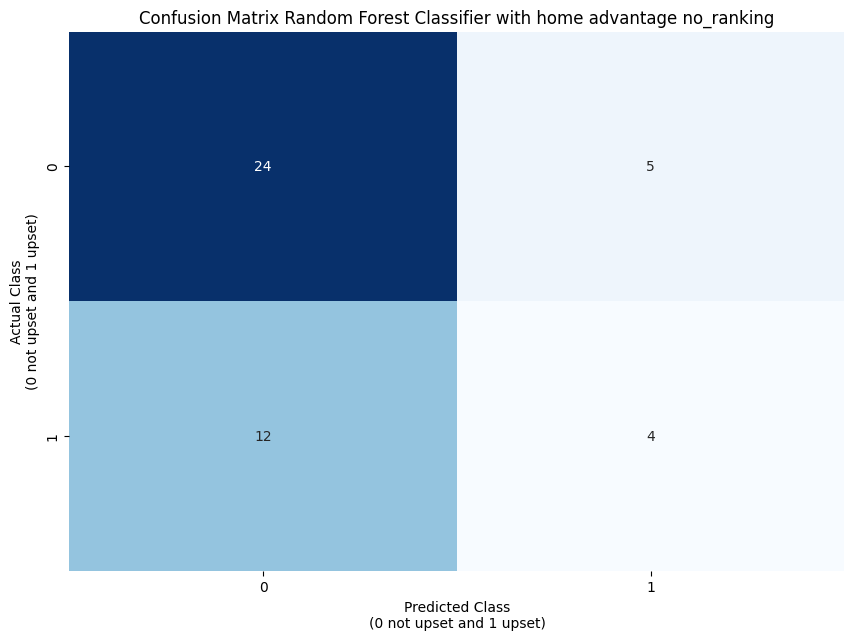

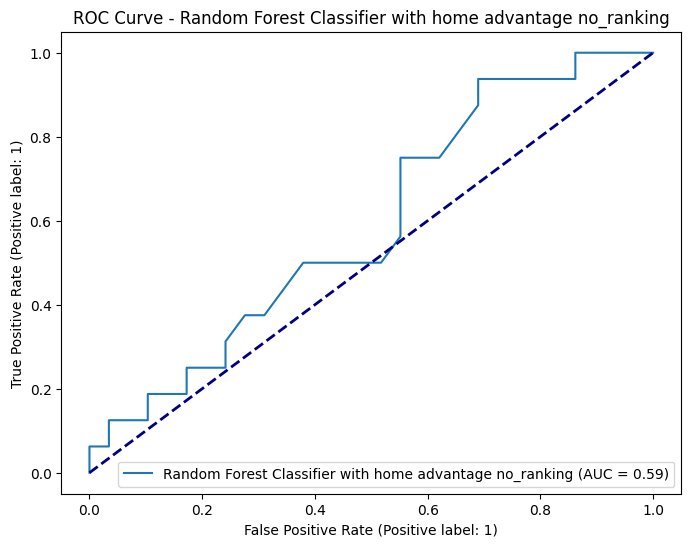

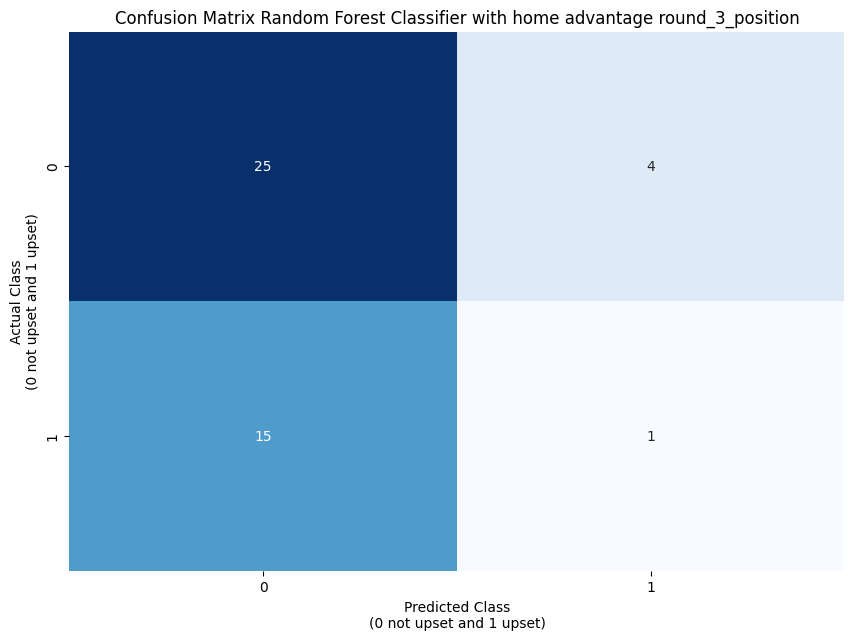

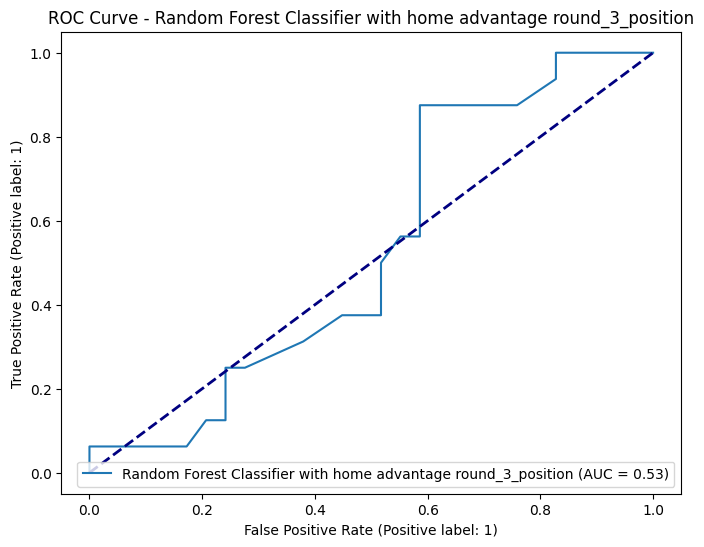

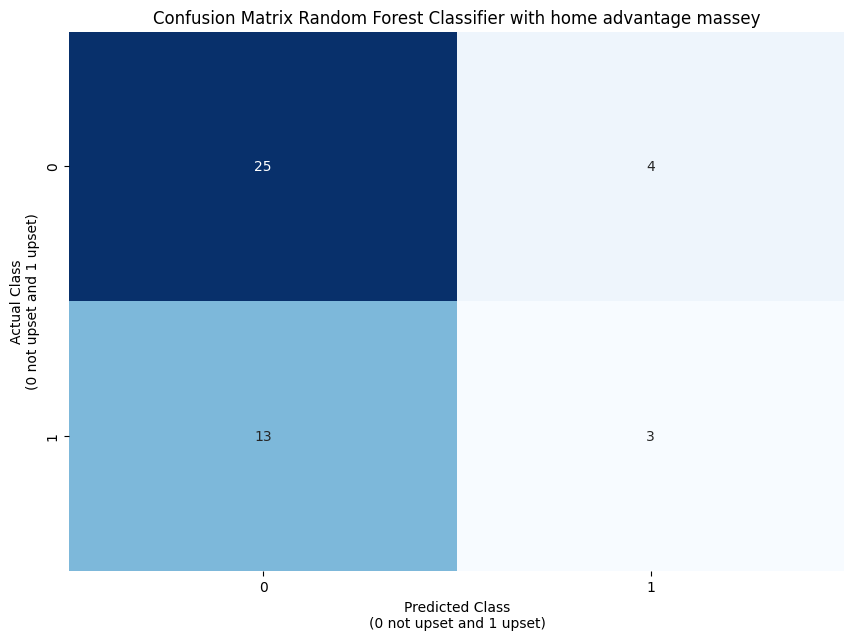

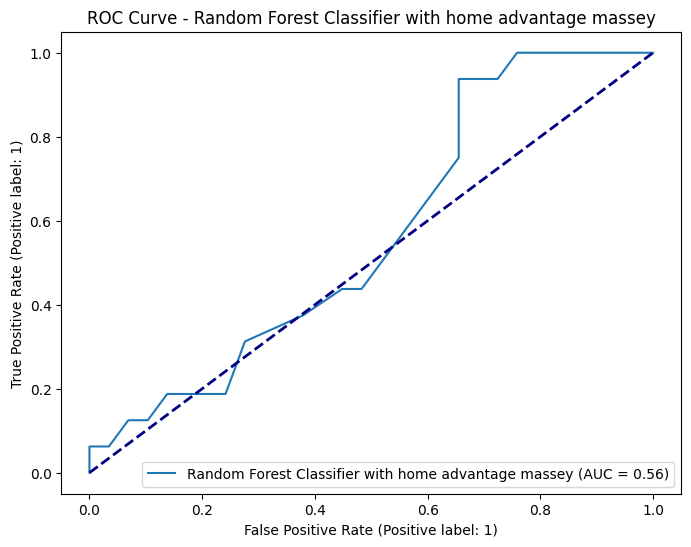

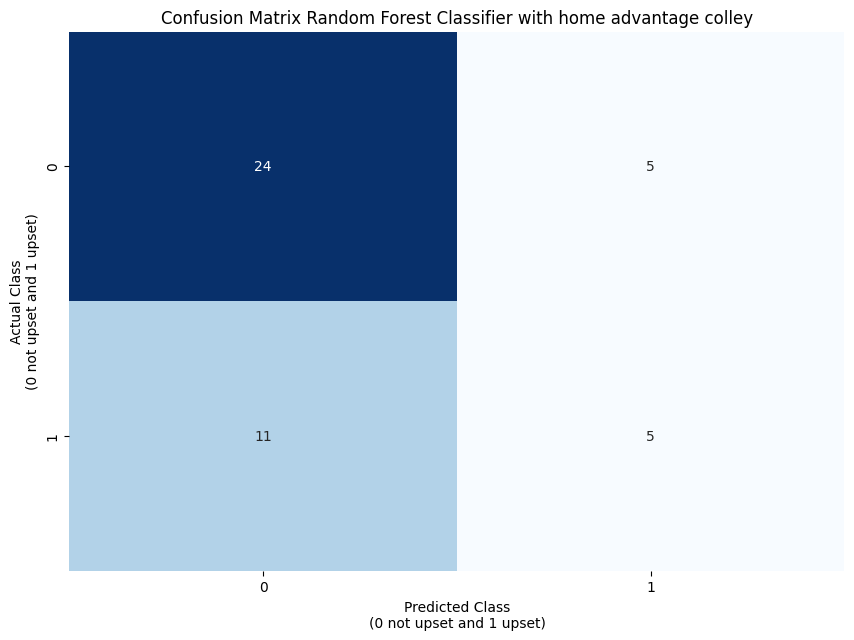

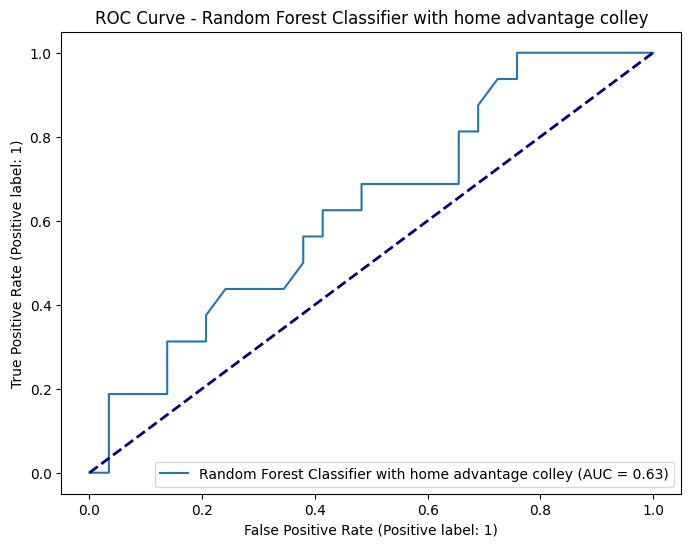

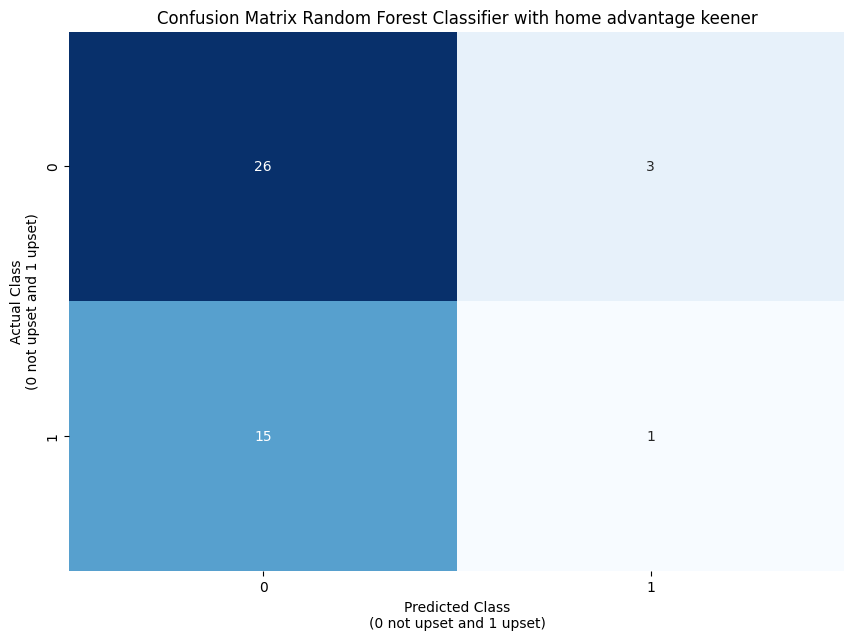

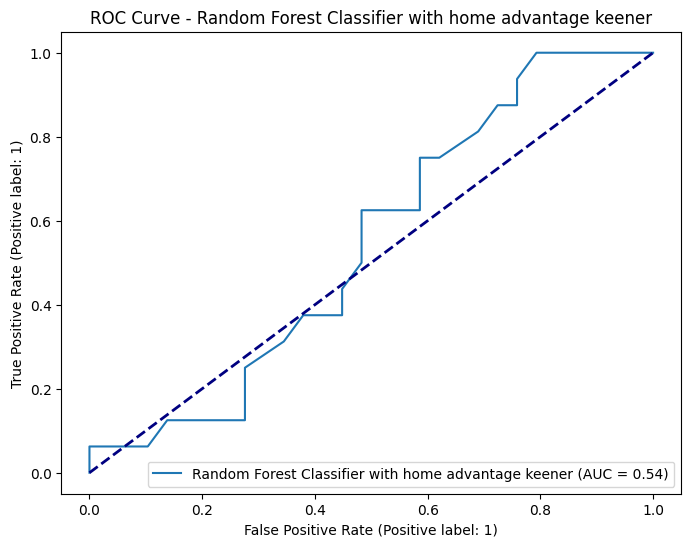

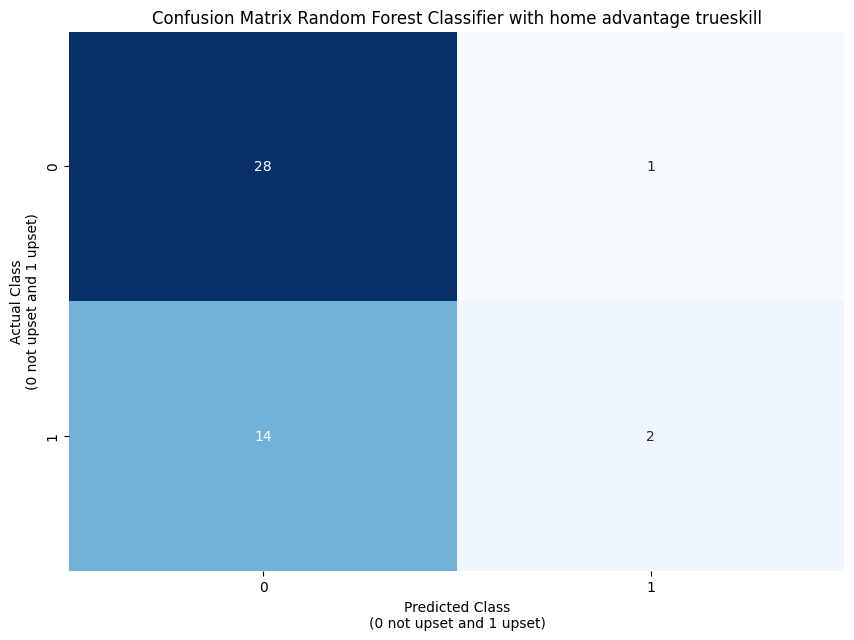

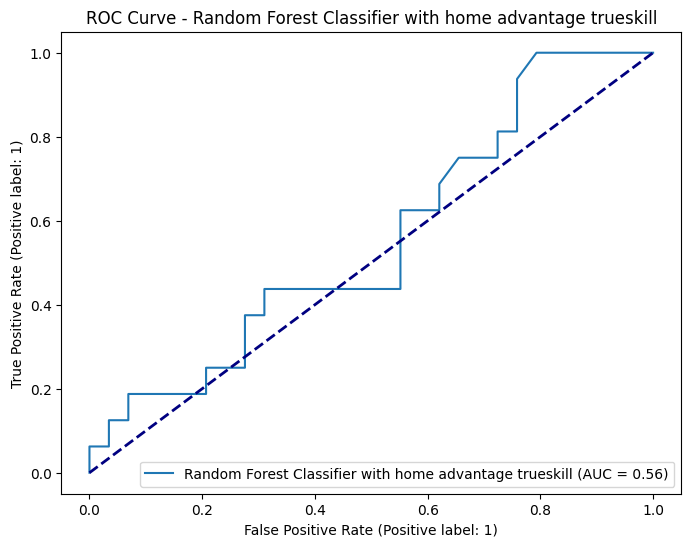

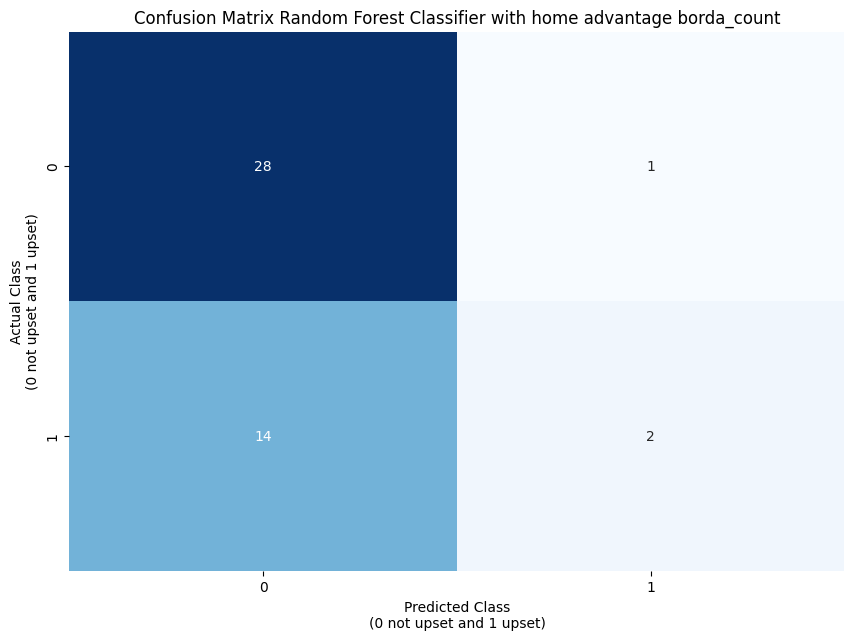

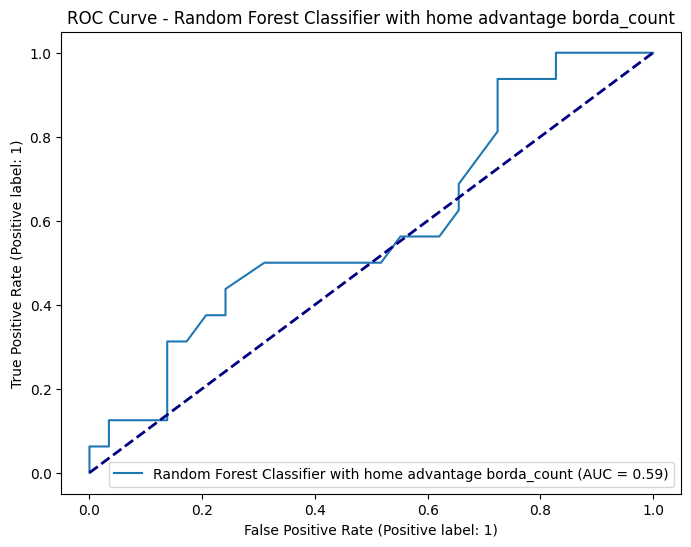

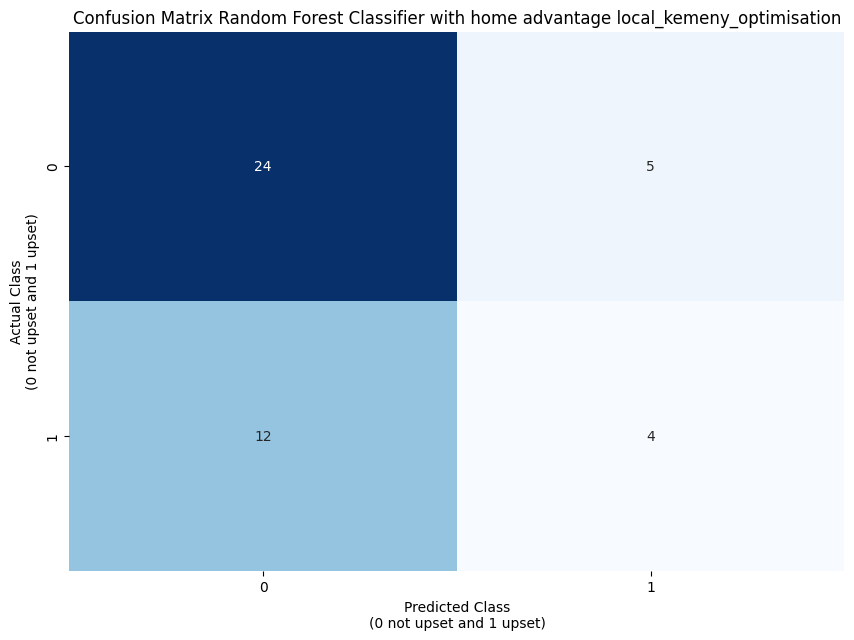

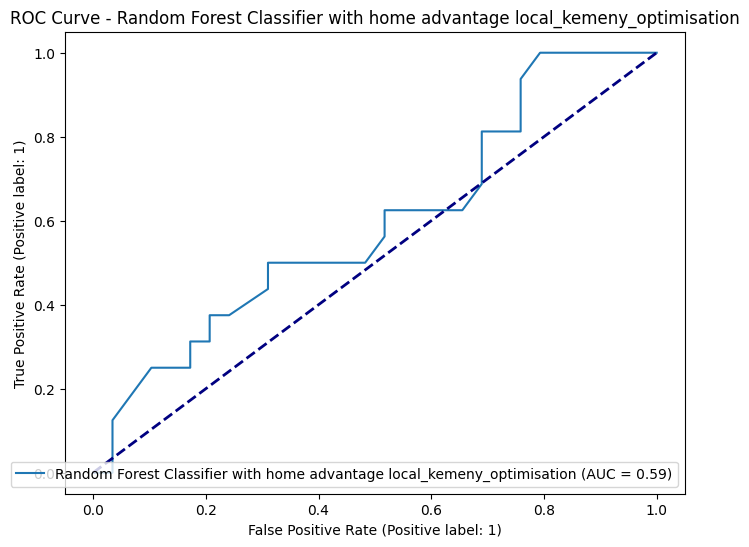

In [50]:
# Random Forest Classifier with home advantage
model_name = "Random Forest Classifier with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_rfh = all_results_df
display(all_results_df_rfh)

all_data_act_pred_df_rfh = all_data_act_pred_df
display(all_data_act_pred_df_rfh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rfh.to_excel("all_rfh_results.xlsx")
all_data_act_pred_df_rfh.to_excel("fold_results_rfh.xlsx")

XG Boost no_ranking
Updated model parameters:
  objective: binary:logistic
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: 1.0
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.1
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: 1
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: None
  n_jobs: None
  num_parallel_tree: None
  random_state: 47
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: 0.8
  tree_method: None
  validate_parameters: None
  verbosity: None
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_lea

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   XG Boost no_ranking XG Boost round_3_position XG Boost massey  \
0                0.993                     1.000           0.997   
1                0.000                     0.000           0.000   
2                0.489                     0.667           0.578   
3                0.000                     0.000           0.000   
4                0.976                     1.000           0.988   
5                0.000                     0.000           0.000   
6                0.312                     0.312           0.250   
7                0.000                     0.000           0.000   
8                0.114                     0.103           0.124   
9                0.930                     0.856           0.861   
10               0.489                     0.667           0.578   
11              17.000                    25.000          22.000   
12              12.000                     4.000           7.000   
13              11.000                    11.000          12.000   
14               5.000                     5.000           4.000   
15               0.607                     0.694           0.647   
16               0.586                     0.862           0.759   
17               0.596                     0.769           0.698   
18               0.294                     0.556           0.364   
19               0.312                     0.312           0.250   
20               0.303                     0.400           0.296   
21               0.451                     0.625           0.505   
22               0.449                     0.587           0.504   
23               0.450                     0.585           0.497   
24               0.496                     0.645           0.546   
25               0.489                     0.667           0.578   
26               0.492                     0.638           0.555   
27               0.459                     0.545           0.502   

   XG Boost colley XG Boost keener XG Boost trueskill XG Boost borda_count  \
0            0.997           0.970              1.000                1.000   
1            0.000           0.000              0.000                0.000  

ml_name_ranking  Actual  Predicted  \
0                   XG Boost no_ranking       0          0   
1                   XG Boost no_ranking       0          0   
2                   XG Boost no_ranking       0          0   
3                   XG Boost no_ranking       0          0   
4                   XG Boost no_ranking       0          0   
..                                  ...     ...        ...   
355  XG Boost local_kemeny_optimisation       0          0   
356  XG Boost local_kemeny_optimisation       0          0   
357  XG Boost local_kemeny_optimisation       1          1   
358  XG Boost local_kemeny_optimisation       0          0   
359  XG Boost local_kemeny_optimisation       1          1   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

     home_team_keener  away_team_keener  home_team_trueskill  \
0                <NA>              <NA>                 <NA>   
1                <NA>              <NA>

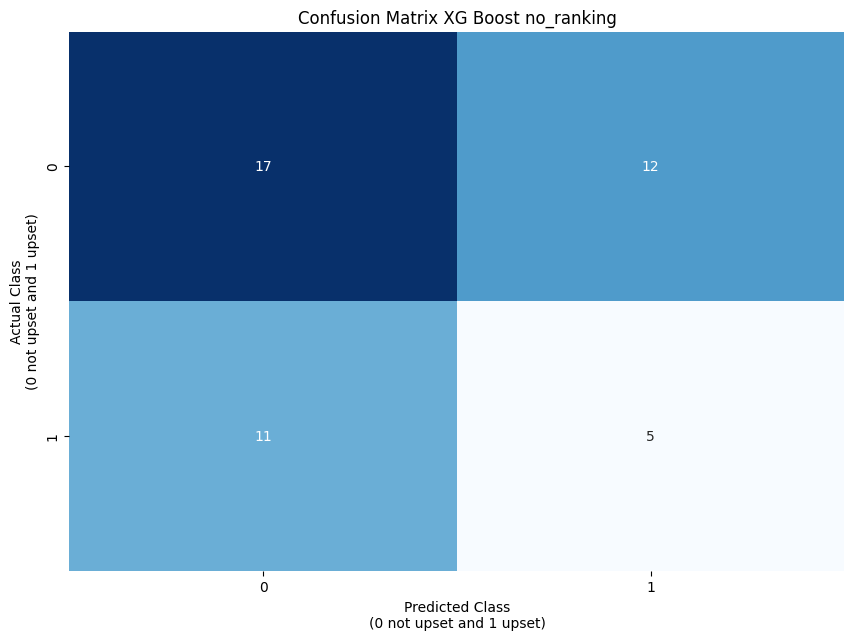

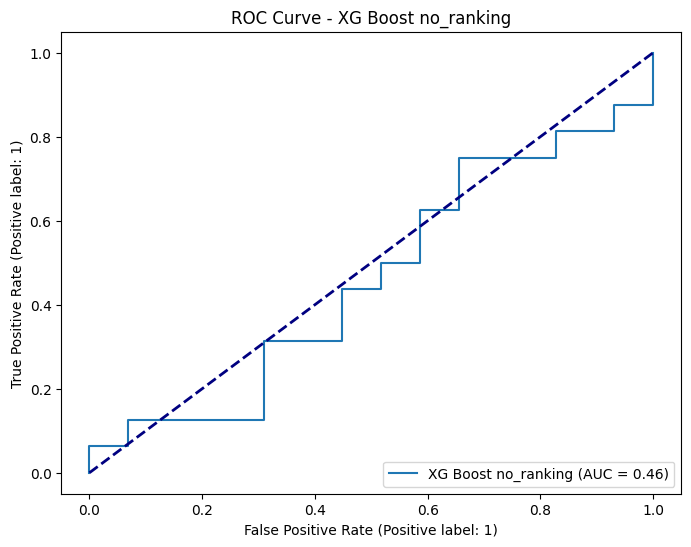

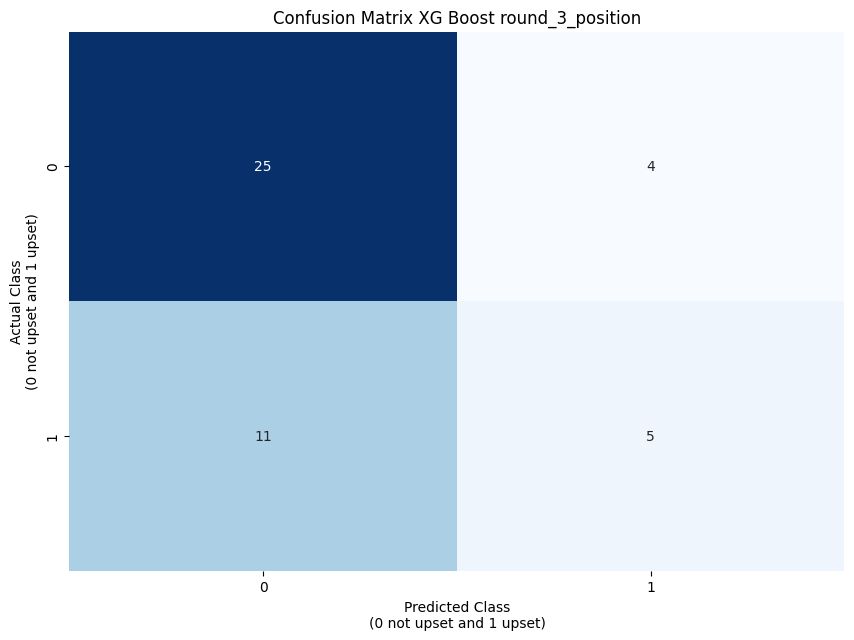

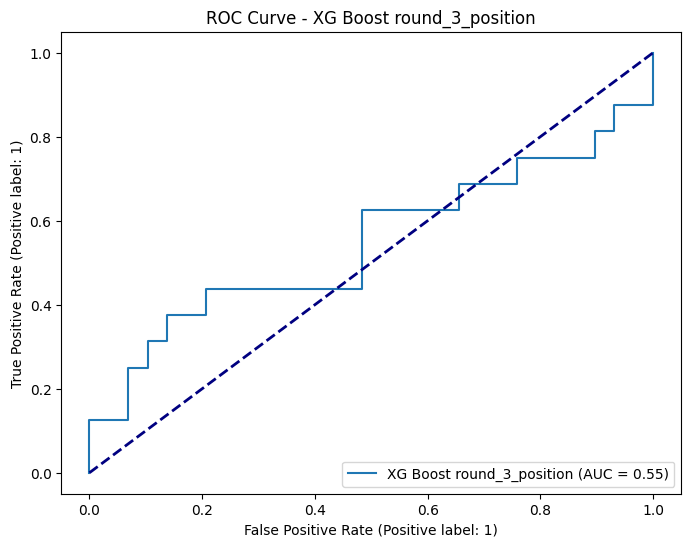

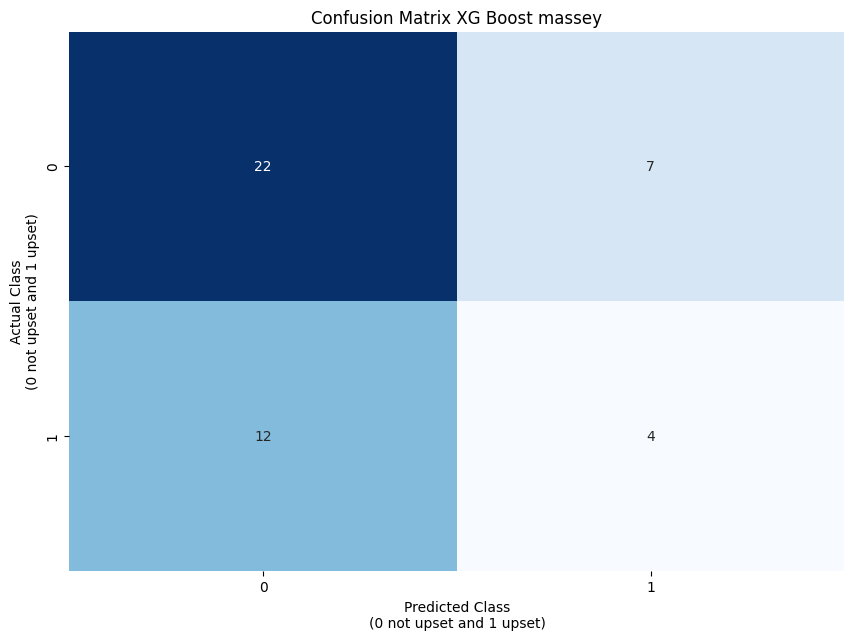

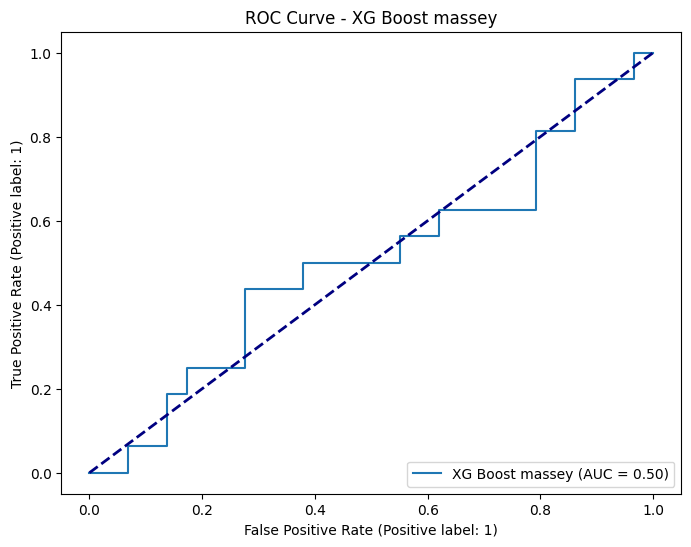

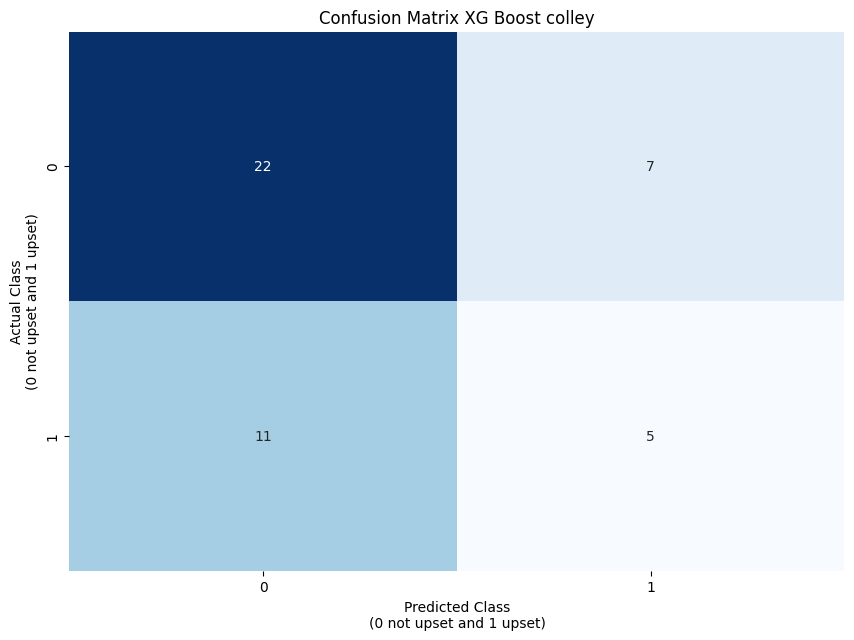

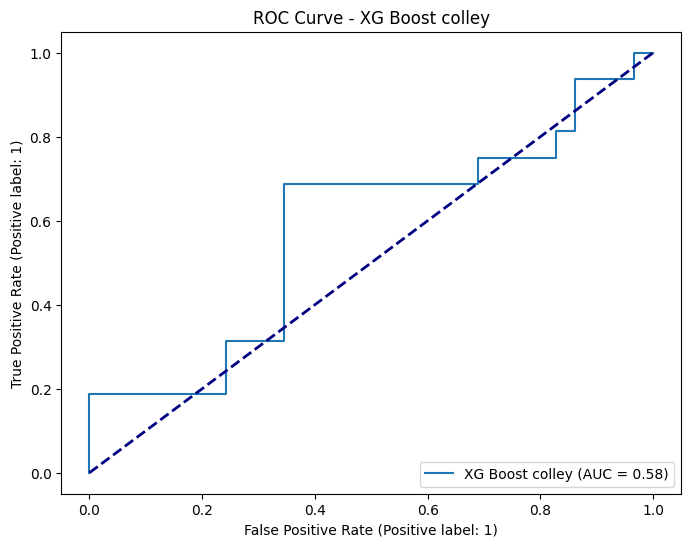

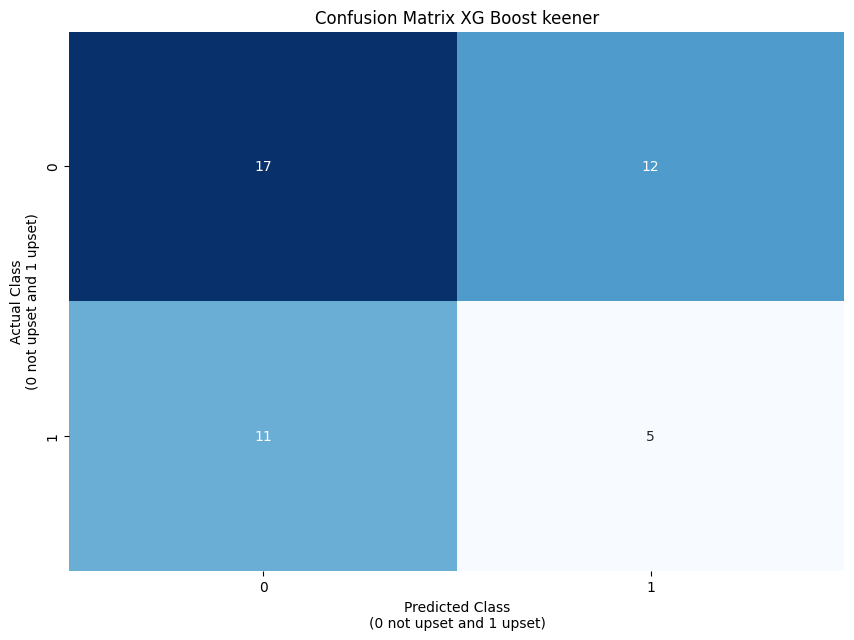

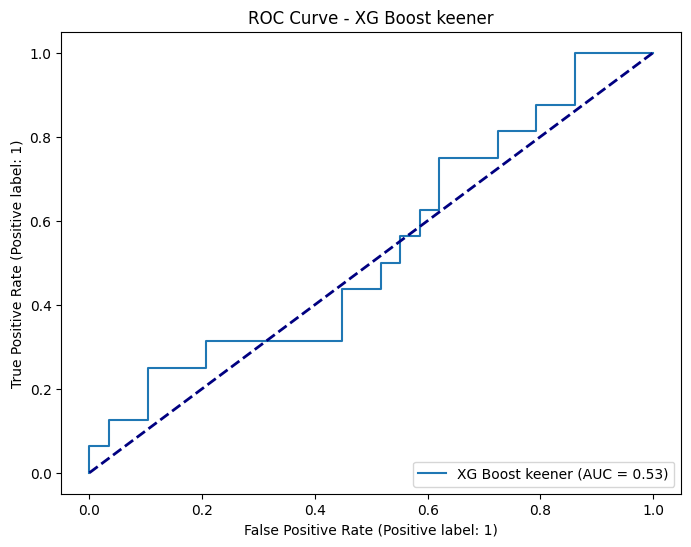

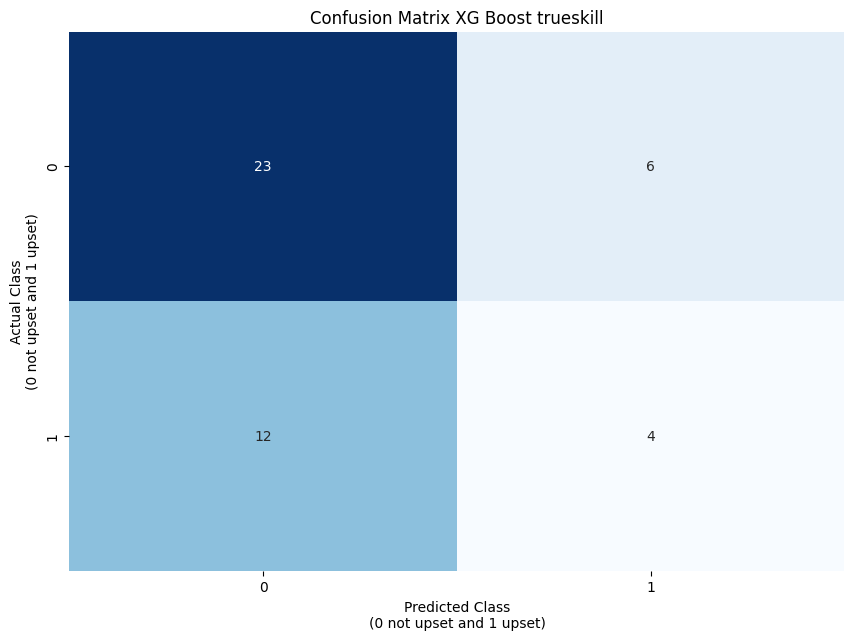

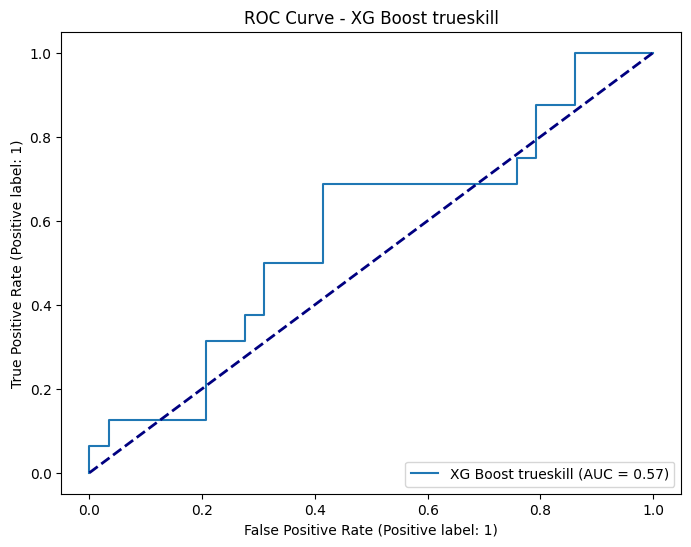

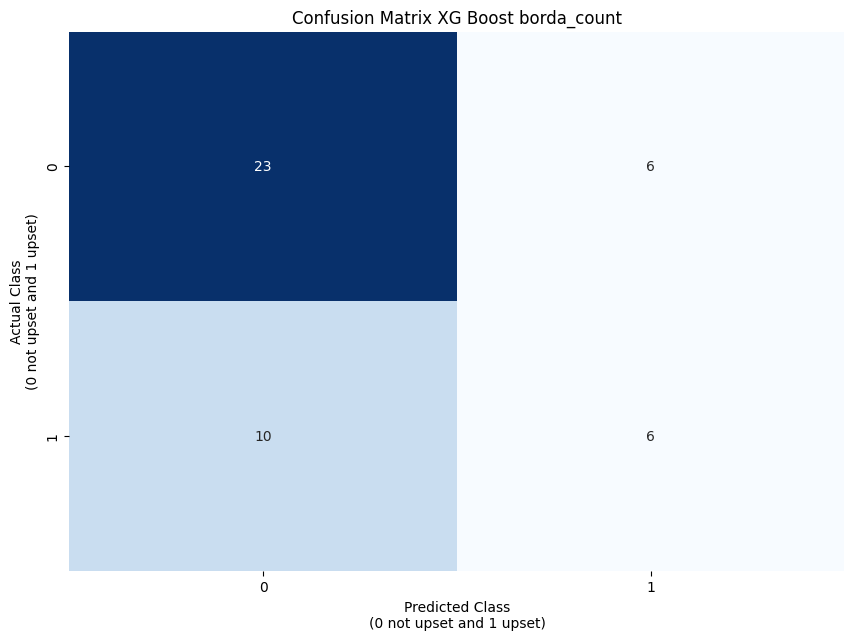

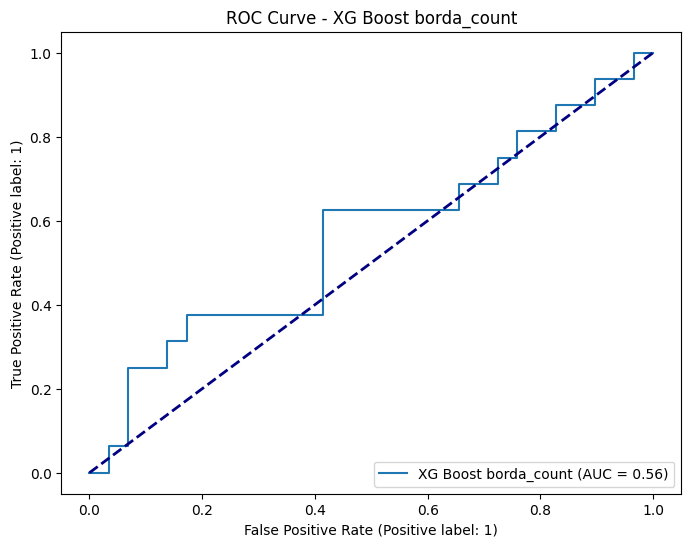

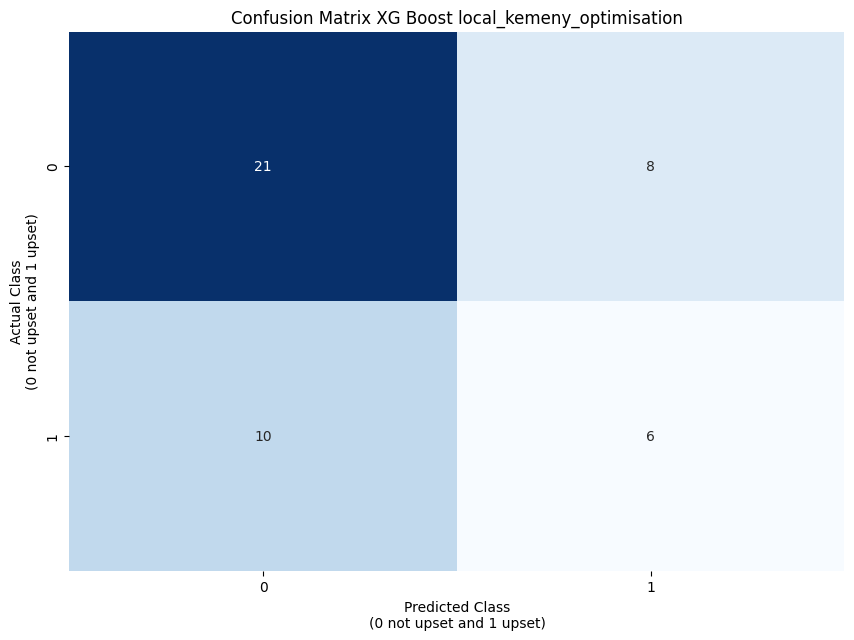

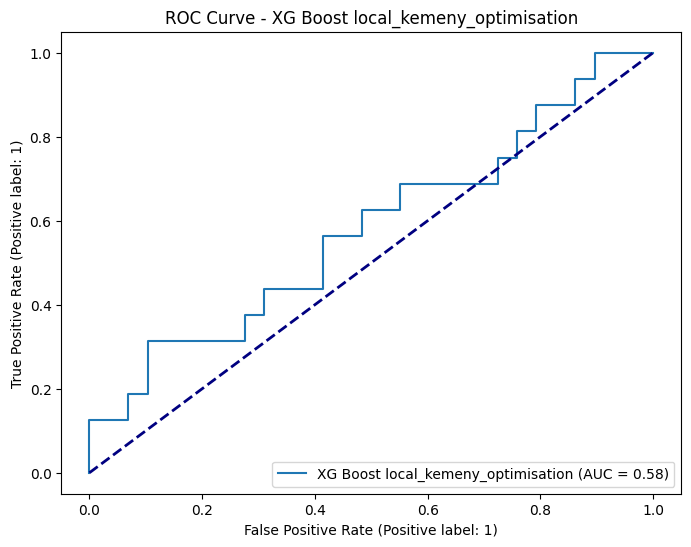

In [51]:
# XG Boost
model_name = "XG Boost"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_xg = all_results_df
display(all_results_df_xg)

all_data_act_pred_df_xg = all_data_act_pred_df
display(all_data_act_pred_df_xg)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xg.to_excel("all_xg_results.xlsx")
all_data_act_pred_df_xg.to_excel("fold_results_xg.xlsx")

XG Boost with home advantage no_ranking
Updated model parameters:
  objective: binary:logistic
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: 0.6
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.1
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: 2
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: None
  n_jobs: None
  num_parallel_tree: None
  random_state: 47
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: 1.0
  tree_method: None
  validate_parameters: None
  verbosity: None
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_f

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   XG Boost with home advantage no_ranking  \
0                                    0.990   
1                                    0.000   
2                                    0.533   
3                                    0.000   
4                                    0.963   
5                                    0.000   
6                                    0.188   
7                                    0.000   
8                                    0.151   
9                                    0.868   
10                                   0.533   
11                                  21.000   
12                                   8.000   
13                                  13.000   
14                                   3.000   
15                                   0.618   
16                                   0.724   
17                                   0.667   
18                                   0.273   
19                                   0.188   
20                                   0.222   
21                                   0.445   
22                                   0.456   
23                                   0.444   
24                                   0.495   
25                                   0.533   
26                                   0.509   
27                                   0.481   

   XG Boost with home advantage round_3_position  \
0                                          0.997   
1                                          0.000   
2                                          0.622   
3                                          0.000   
4                                          0.988   
5                                          0.000   
6                                          0.125   
7                                          0.000   
8                                          0.145   
9                                          0.728   
10                                         0.622   
11                                        26.000   
12                                         3.000   
13                                        14.000   
14                                         2.000   
15                                    

ml_name_ranking  Actual  Predicted  \
0              XG Boost with home advantage no_ranking       0          1   
1              XG Boost with home advantage no_ranking       0          0   
2              XG Boost with home advantage no_ranking       0          1   
3              XG Boost with home advantage no_ranking       0          0   
4              XG Boost with home advantage no_ranking       0          1   
..                                                 ...     ...        ...   
355  XG Boost with home advantage local_kemeny_opti...       0          0   
356  XG Boost with home advantage local_kemeny_opti...       0          0   
357  XG Boost with home advantage local_kemeny_opti...       1          0   
358  XG Boost with home advantage local_kemeny_opti...       0          0   
359  XG Boost with home advantage local_kemeny_opti...       1          0   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  home_team_colley  away_team_colley  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

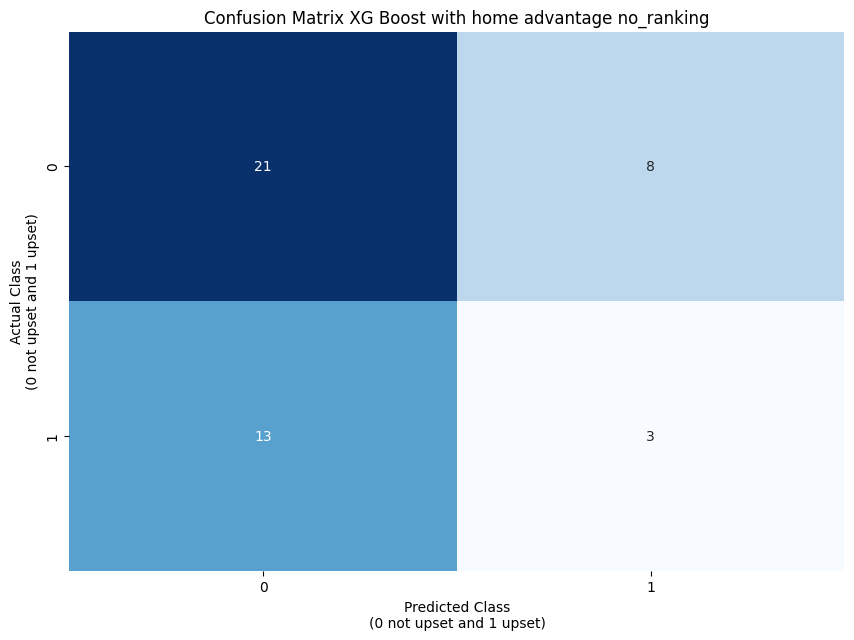

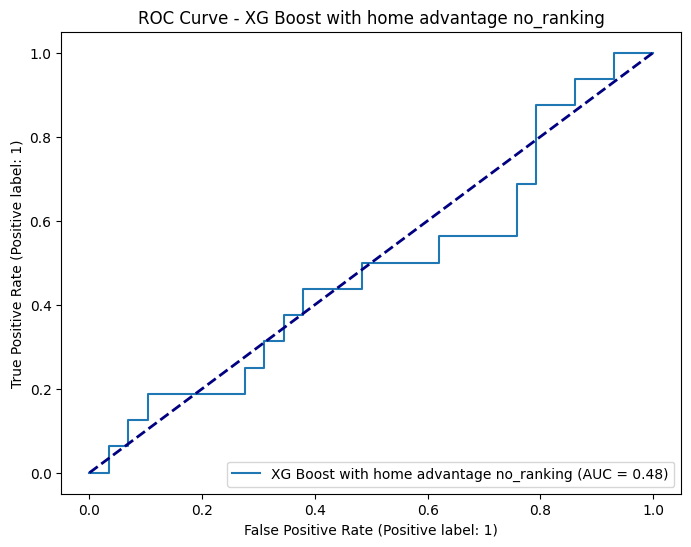

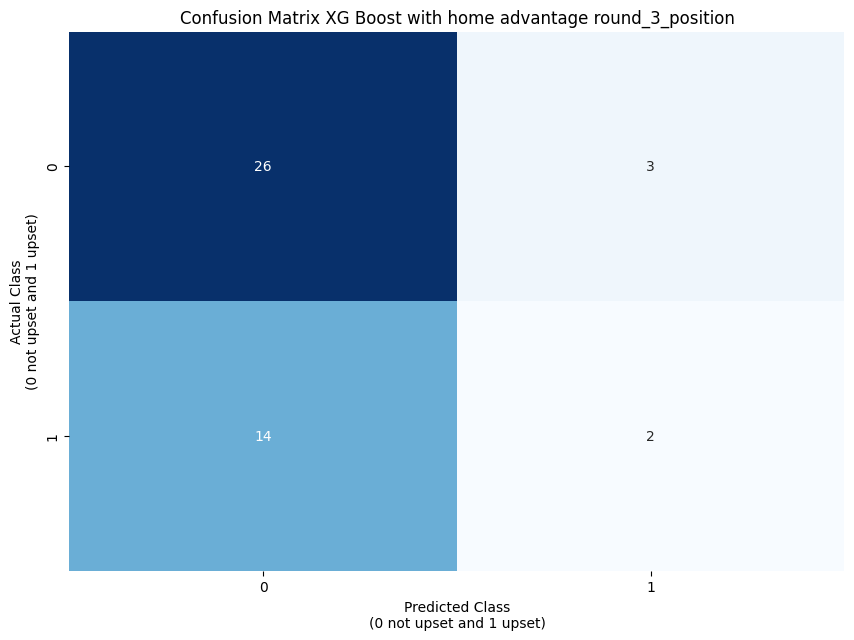

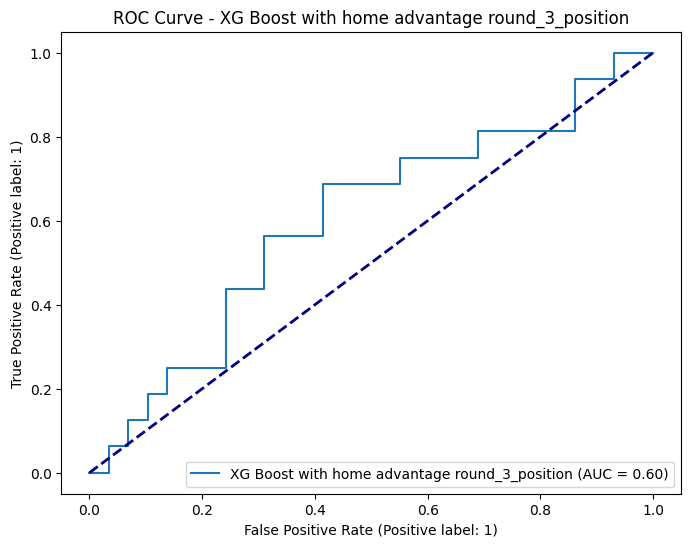

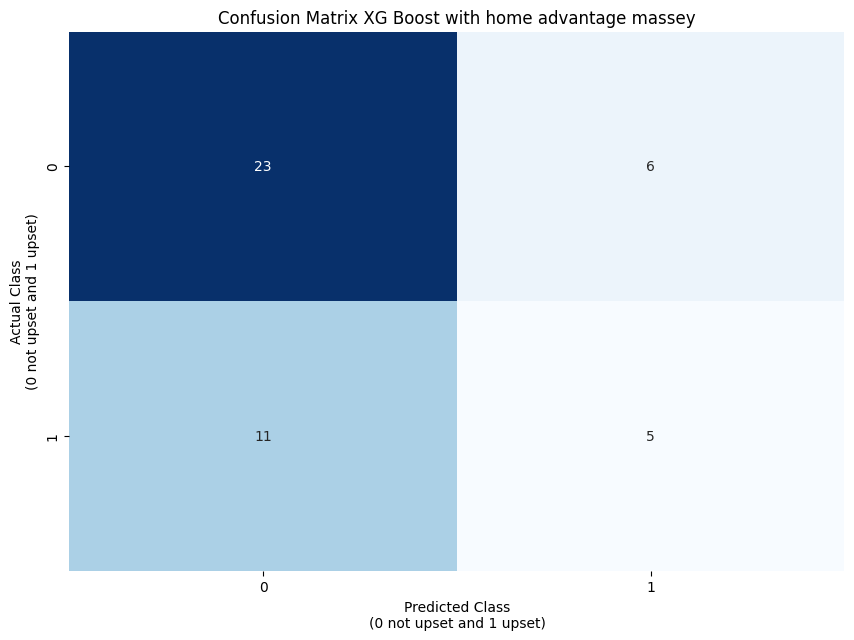

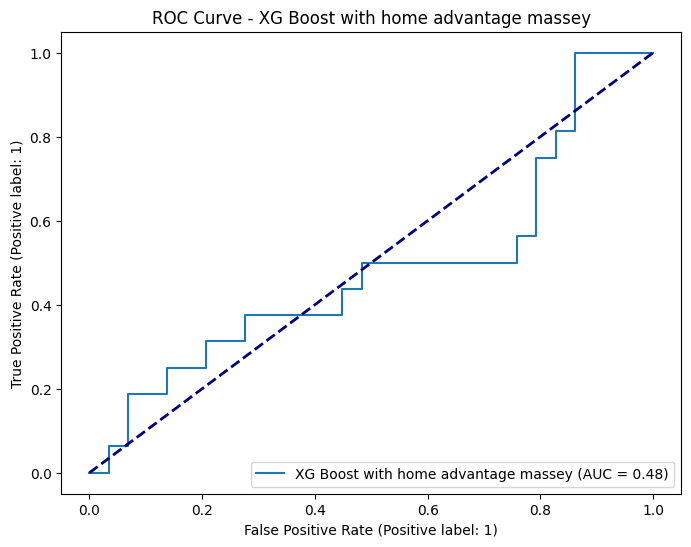

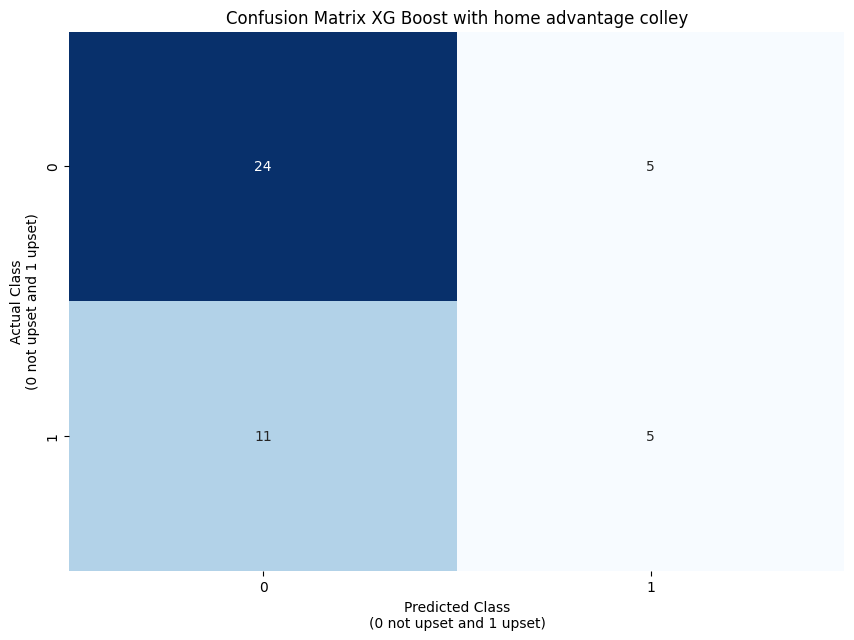

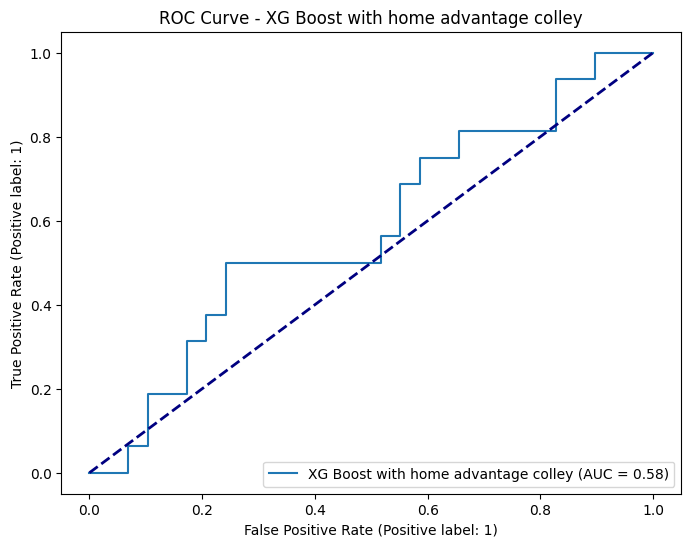

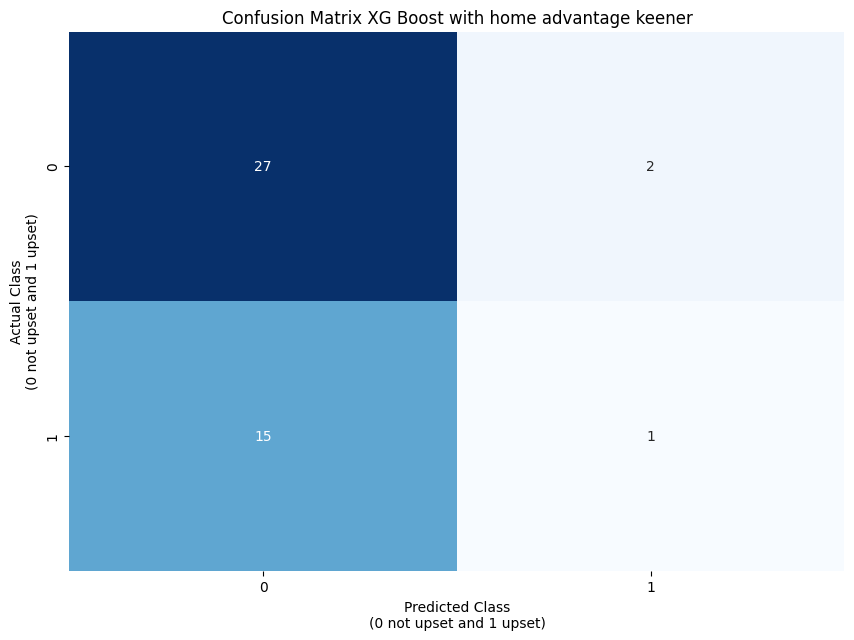

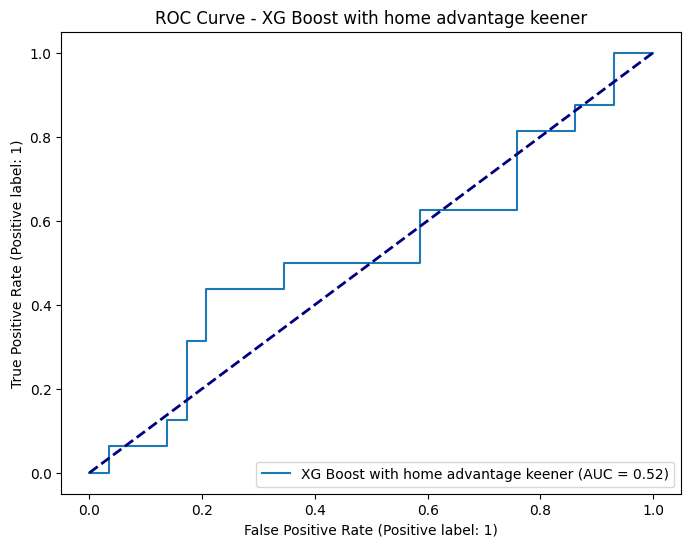

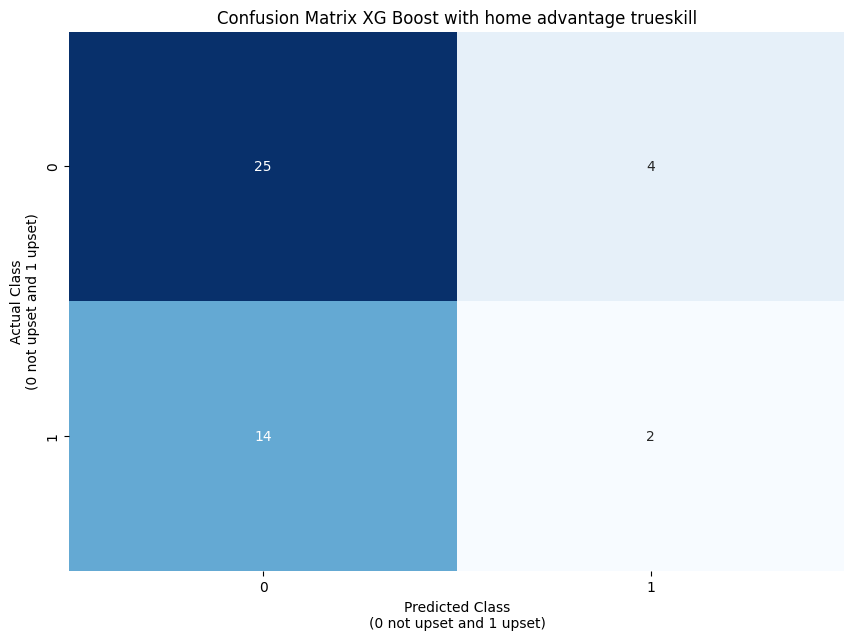

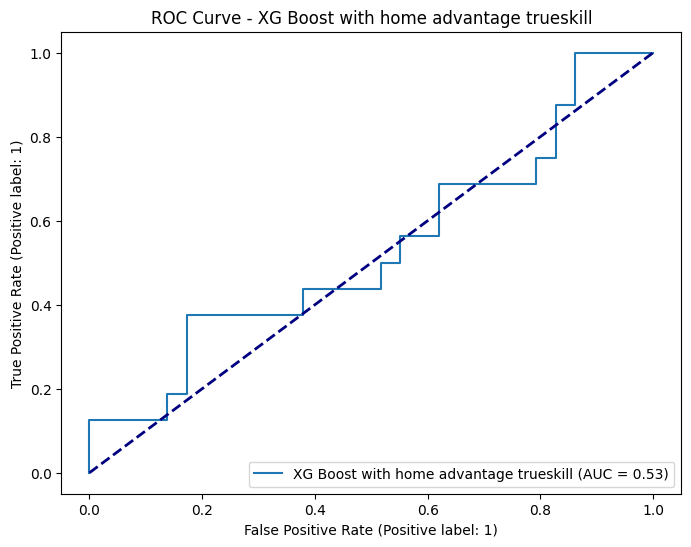

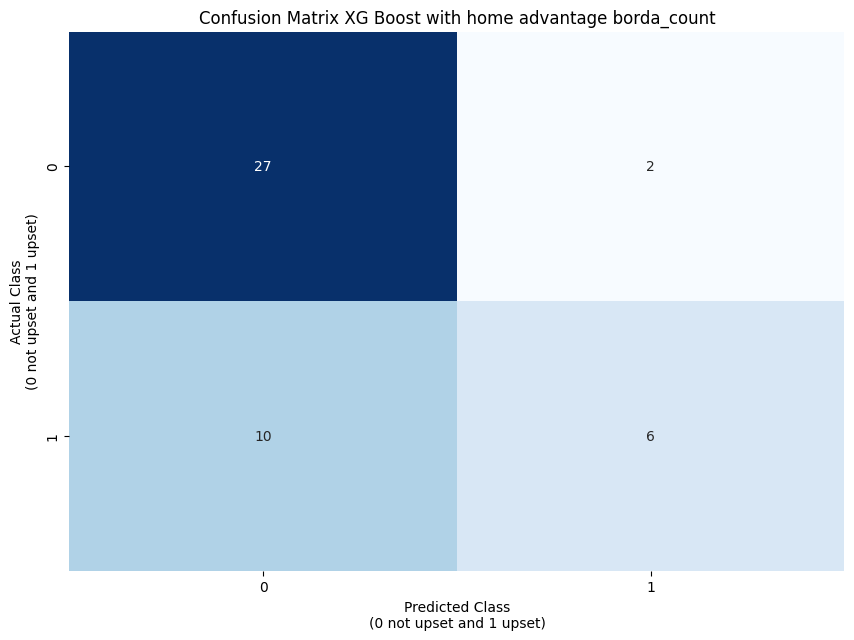

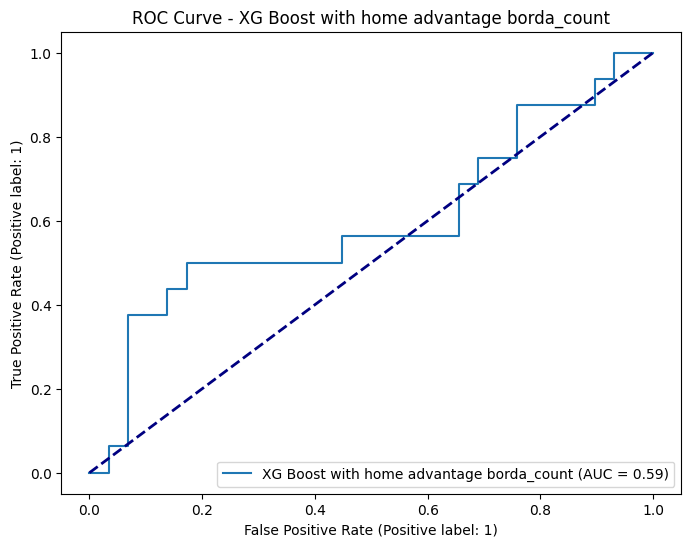

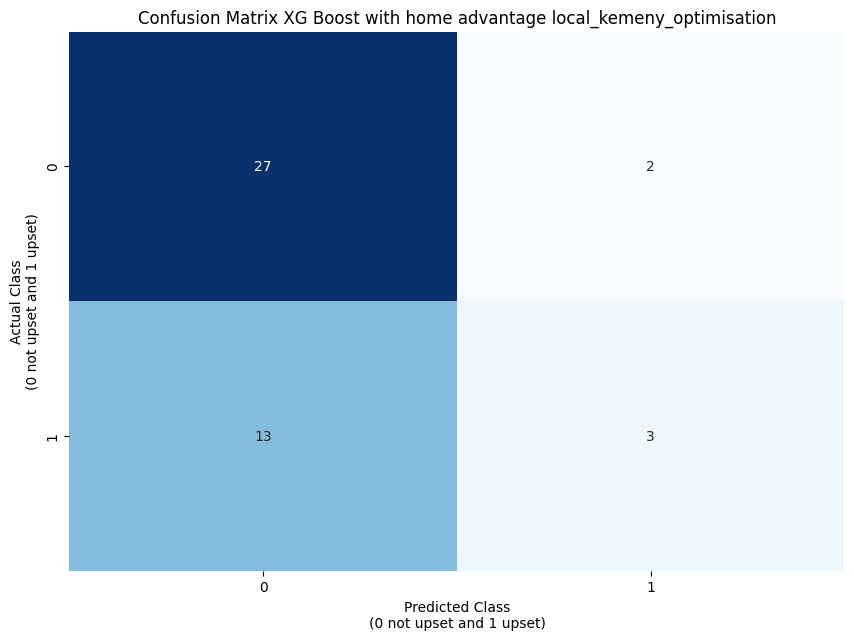

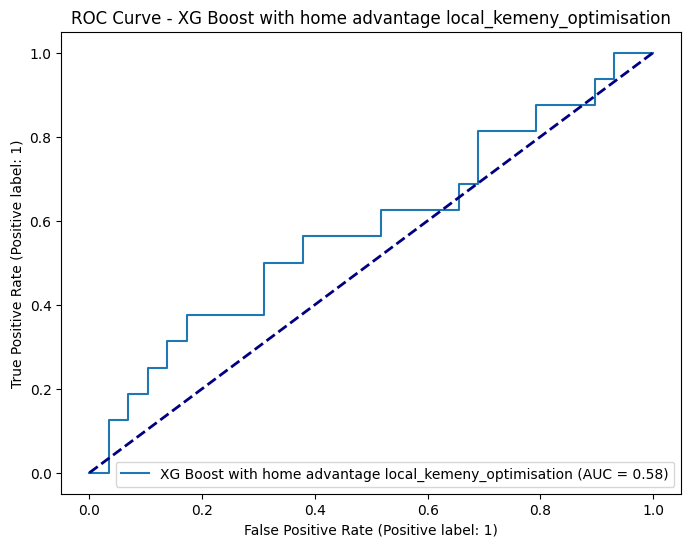

In [52]:
# XG Boost with home advantage
model_name = "XG Boost with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

all_results_df, all_data_act_pred_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_xgh = all_results_df
display(all_results_df_xgh)

all_data_act_pred_df_xgh = all_data_act_pred_df
display(all_data_act_pred_df_xgh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xgh.to_excel("all_xgh_results.xlsx")
all_data_act_pred_df_xgh.to_excel("fold_results_xgh.xlsx")

In [53]:
all_results_df = all_results_df_xg.merge(all_results_df_xgh, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rfh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rf.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nn.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')

all_results_df = all_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(all_results_df)
all_results_df.to_excel("ml_model_confusion_matrix_results_unseen.xlsx")

# Load data from Excel to Google BigQuery
all_results_from_excel = pd.read_excel("ml_model_confusion_matrix_results_unseen.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_confusion_matrix_results_unseen'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(all_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2              Unseen Train Standard Deviation   
2           3                    Unseen Test Accuracy Mean   
3           4      Unseen Test Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6       Unseen Train Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   standard_logisticregression_no_ranking  \
0                                   0.757   
1                                   0.000   
2                                   0.556   
3                                   0.000   
4                                   0.232   
5                                   0.000   
6                                   0.125   
7                                   0.000   
8                                   0.486   
9                                   1.454   
10                                  0.556   
11                                 23.000   
12                                  6.000   
13                                 14.000   
14                                  2.000   
15                                  0.622   
16                                  0.793   
17                                  0.697   
18                                  0.250   
19                                  0.125   
20                                  0.167   
21                                  0.436   
22                                  0.459   
23                                  0.432   
24                                  0.489   
25                                  0.556   
26                                  0.508   
27                                  0.459   

   standard_logisticregression_round_3_position  \
0                                         0.751   
1                                         0.000   
2                                         0.578   
3                                         0.000   
4                                         0.232   
5                                         0.000   
6                                         0.188   
7                                         0.000   
8                                         0.489   
9                                         0.850   
10                                        0.578   
11                                       23.000   
12                                        6.000   
13                                       13.000   
14                                        3.000   
15                                        0.639   
16                              

100%|██████████| 1/1 [00:00<00:00, 13107.20it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_confusion_matrix_results_unseen


In [54]:
# Load updated  prediction results to Google Big Query

# Merge fold results from each model
all_data_act_pred_df = pd.concat([all_data_act_pred_df_slr, all_data_act_pred_df_slrh, all_data_act_pred_df_wlr, all_data_act_pred_df_wlrh, all_data_act_pred_df_nn, all_data_act_pred_df_nnh, all_data_act_pred_df_rf, all_data_act_pred_df_rfh, all_data_act_pred_df_xg, all_data_act_pred_df_xgh])
all_data_act_pred_df = all_data_act_pred_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(all_data_act_pred_df)

# Write to Excel
all_data_act_pred_df.to_excel("ml_model_all_predictions_unseen.xlsx")

# Load fold results data from Excel to Google BigQuery
fold_results_from_excel = pd.read_excel("ml_model_all_predictions_unseen.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_all_predictions_unseen'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(fold_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


ml_name_ranking  actual  predicted  \
0               Standard LogisticRegression no_ranking       0          0   
1               Standard LogisticRegression no_ranking       0          0   
2               Standard LogisticRegression no_ranking       0          0   
3               Standard LogisticRegression no_ranking       0          0   
4               Standard LogisticRegression no_ranking       0          0   
..                                                 ...     ...        ...   
355  XG Boost with home advantage local_kemeny_opti...       0          0   
356  XG Boost with home advantage local_kemeny_opti...       0          0   
357  XG Boost with home advantage local_kemeny_opti...       1          0   
358  XG Boost with home advantage local_kemeny_opti...       0          0   
359  XG Boost with home advantage local_kemeny_opti...       1          0   

     arena_stadium_capacity  home_lineup_strength  home_team_league_form  \
0                     53394                  0.69                   0.83   
1                     41837                  0.67                   0.39   
2                     62850                   NaN                   0.00   
3                     62850                  0.88                   0.56   
4                     32050                  0.88                   0.00   
..                      ...                   ...                    ...   
355                   11582                   NaN                   0.00   
356                    7691                  0.62                   0.00   
357                    4502                  0.70                   0.00   
358                    9527                  0.72                   0.39   
359                    6238                   NaN                    NaN   

     home_team_league_form_home_and_away  \
0                                   0.44   
1                                   0.39   
2                                   0.39   
3                                   0.39   
4                                   0.72   
..                                   ...   
355                                 0.33   
356                                 0.39   
357                                 0.61   
358                                 0.17   
359                                  NaN   

     home_team_league_promotion_relegation  away_lineup_strength  \
0                                        0                  0.81   
1                                        0                  0.82   
2                                        0                   NaN   
3                                        0                  0.78   
4                                        1                  0.71   
..                                     ...                   ...   
355                                      0                   NaN   
356                                      0                  0.73   
357                                      0                  0.85   
358                                      1                  0.75   
359                                      0                  0.69   

     away_team_league_form  ...  away_team_colley  home_team_keener  \
0                     0.00  ...              <NA>              <NA>   
1                     0.56  ...              <NA>              <NA>   
2                     0.28  ...              <NA>              <NA>   
3                     0.22  ...              <NA>              <NA>   
4                     0.56  ...              <NA>              <NA>   
..                     ...  ...               ...               ...   
355                   0.00  ...              <NA>              <NA>   
356                   0.00  ...              <NA>              <NA>   
357                   0.28  ...              <NA>              <NA>   
358                   0.28  ...              <NA>              <NA>   
359                   0.00  ...              <NA>              <NA>   

  

100%|██████████| 1/1 [00:00<00:00, 13357.66it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_all_predictions_unseen
